# Analysis of variation in SARS-CoV2

## Prepping data

If you are running this notebook from [cloned GitHub repo](https://github.com/galaxyproject/SARS-CoV-2/tree/master/genomics/4-Variation) you should have all datafile inplace for this analysis. 

In [160]:
from datetime import date

today = date.today()
print("Last run:", today)

Last run: 2020-05-29


In [1]:
# Set display to the full length

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install --upgrade seaborn biopython pandasql
!pip install tabulate

Requirement already up-to-date: seaborn in /home/anton/anaconda3/lib/python3.7/site-packages (0.10.1)
Requirement already up-to-date: biopython in /home/anton/anaconda3/lib/python3.7/site-packages (1.77)
Requirement already up-to-date: pandasql in /home/anton/anaconda3/lib/python3.7/site-packages (0.7.3)


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import matplotlib.pyplot as plt
%matplotlib inline

# Panadas display options
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# Seaborn markers and colors:
fc_palette = {".":'b',"MISSENSE":'orange',"NONSENSE":'r','SILENT':'g'}
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}

In [4]:
# Import two datasets
# The number inside `get()` function corresponds to history ID

var_file = 17     # Number of history item with variant list
gb_file = 4      # Number of histoiry item containing genbank annoration for NC_045512

try:
    # In Galaxy
    var_path = get(var_file)
    gb_path = get(gb_file)
    IN_GALAXY = True
except NameError:
    # Local notebook execution
    var_path = 'variant_list.tsv.gz'
    gb_path = 'NC_045512.2.genbank'
    IN_GALAXY = False

In [5]:
# Clean artifacts of SNPeff from file headers

if var_path.endswith('gz'):
    !gunzip -c {var_path} | sed s/EFF\\\[\\\*\\\]\.//g > var.tab
else:
    !cat {var_path} | sed s/EFF\\\[\\\*\\\]\.//g > var.tab

In [6]:
# Create dataframe with variants and only keep variants with allele frequency above 5%
var  = pd.read_csv('var.tab', sep='\t')
!rm var.tab

In [7]:
# Restrict variants to those above 5% AF
var = var[ var['AF']>=0.05]

In [8]:
var['change'] = var['REF']+var['ALT']

In [9]:
var.head()

Sample      CHROM   POS REF ALT    QUAL   DP        AF  SB  \
0   SRR11517432  NC_045512   160   G   A  5015.0  159  0.937107   4   
1   SRR11517432  NC_045512   241   C   T  9603.0  291  0.958763   0   
14  SRR11517432  NC_045512  1486   A   G    93.0  156  0.051282   4   
18  SRR11517432  NC_045512  1680   A   G   154.0  251  0.067729  28   
33  SRR11517432  NC_045512  3037   C   T  9753.0  300  0.976667   0   

            DP4    IMPACT  FUNCLASS                 EFFECT    GENE    CODON  \
0    6,0,112,41         .         .                      .       .        .   
1   0,0,147,140         .         .                      .       .        .   
14   118,26,8,0       LOW    SILENT      SYNONYMOUS_CODING  orf1ab  ggA/ggG   
18  97,120,1,16  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab  gAg/gGg   
33  1,0,152,144       LOW    SILENT      SYNONYMOUS_CODING  orf1ab  ttC/ttT   

   change  
0      GA  
1      CT  
14     AG  
18     AG  
33     CT

In [10]:
# Extract metadata from SRA accessions and stick into a dataframe
# This is a cumbersome and slow process
# Here we first extract not very detailed metadata using SRR accession
# This because extracting using --detailed flag fails

cmd = 'pysradb metadata {} --saveto all.txt'.format(' '.join(var['Sample'].unique()))
!{cmd}
md = pd.read_csv('all.txt',sep="\t")
!rm all.txt

/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [11]:
# Next we extract deatiled metadata about individual projects (SRP accessions) one by one
# It is expected that some will fail
# This step takes a while! (~ 30 min)

for item in md['study_accession'].unique():
    cmd = 'pysradb metadata {0} --detailed --expand --saveto {0}.mdata'.format(item)
    !{cmd}

/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: Futur

/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: Futur

/home/anton/anaconda3/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [12]:
# Now now we squeeze contact of multiple metadata files into a single dataframe

import os 
li = []
for file in os.listdir():
    if file.endswith('.mdata'):
        df = pd.read_csv(file,sep="\t",index_col=None,header=0)
        li.append(df)
srp_md = pd.concat(li,axis=0,ignore_index=True)

In [13]:
srp_md = srp_md.drop(['isolate'],axis=1)

In [14]:
srp_md.columns

Index(['study_accession', 'experiment_accession', 'experiment_title',
       'experiment_desc', 'organism_taxid ', 'organism_name',
       'library_strategy', 'library_source', 'library_selection',
       'sample_accession', 'sample_title_x', 'instrument', 'total_spots',
       'total_size', 'run_accession', 'run_total_spots', 'run_total_bases',
       'run_alias', 'sra_url_alt1', 'sra_url_alt2', 'sra_url',
       'experiment_alias', 'collection_date', 'description', 'env_broad_scale',
       'env_local_scale', 'env_medium', 'geo_loc_name', 'host', 'host_disease',
       'host_taxid', 'isol_growth_condt', 'isolation_source', 'lat_lon',
       'propagation', 'sample_title_y', 'seq_methods', 'source_uvig', 'strain',
       'virus_enrich_appr', 'BioSampleModel', 'ena_fastq_url_1',
       'ena_fastq_url_2', 'ena_fastq_ftp_1', 'ena_fastq_ftp_2', 'sample_title',
       'collected_by', 'age', 'biomaterial_provider', 'sex', 'tissue',
       'sra_url_alt', 'ena_fastq_url', 'ena_fastq_ftp', 'hos

In [15]:
## First low-level metadata add metadata
var = pysqldf('select var.*, study_accession,library_strategy,library_source,library_selection from var left join md on Sample = run_accession')

In [16]:
## And now add collection date and geo_loc_name
var = pysqldf('select var.*, collection_date, geo_loc_name from var left join srp_md on Sample = run_accession ')

In [17]:
var

Sample      CHROM    POS REF ALT     QUAL    DP        AF  SB  \
0      SRR11517432  NC_045512    160   G   A   5015.0   159  0.937107   4   
1      SRR11517432  NC_045512    241   C   T   9603.0   291  0.958763   0   
2      SRR11517432  NC_045512   1486   A   G     93.0   156  0.051282   4   
3      SRR11517432  NC_045512   1680   A   G    154.0   251  0.067729  28   
4      SRR11517432  NC_045512   3037   C   T   9753.0   300  0.976667   0   
...            ...        ...    ...  ..  ..      ...   ...       ...  ..   
83781  SRR11801823  NC_045512  28881   G   A  49314.0  4842  0.948781   9   
83782  SRR11801823  NC_045512  28882   G   A  49314.0  4836  0.943342   1   
83783  SRR11801823  NC_045512  28883   G   C  49314.0  4989  0.970134   0   
83784  SRR11801823  NC_045512  29360   T   G   8419.0  6728  0.062128  14   
83785  SRR11801823  NC_045512  29364   C   A   9761.0  6518  0.074563  24   

                     DP4    IMPACT  FUNCLASS                 EFFECT    GENE  \
0             6,0,112,41         .         .                      .       .   
1            0,0,147,140         .         .                      .       .   
2             118,26,8,0       LOW    SILENT      SYNONYMOUS_CODING  orf1ab   
3            97,120,1,16  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab   
4            1,0,152,144       LOW    SILENT      SYNONYMOUS_CODING  orf1ab   
...                  ...       ...       ...                    ...     ...   
83781      7,3,2056,2761  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING       N   
83782      3,3,2059,2756       LOW    SILENT      SYNONYMOUS_CODING       N   
83783      0,0,2138,2839  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING       N   
83784  2520,3769,148,277  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING       N   
83785  2422,3463,173,328  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING       N   

         CODON change study_accession library_strategy      library_source  \
0            .     GA       SRP255853          RNA-Seq  METATRANSCRIPTOMIC   
1            .     CT       SRP255853          RNA-Seq  METATRANSCRIPTOMIC   
2      ggA/ggG     AG       SRP255853          RNA-Seq  METATRANSCRIPTOMIC   
3      gAg/gGg     AG       SRP255853          RNA-Seq  METATRANSCRIPTOMIC   
4      ttC/ttT     CT       SRP255853          RNA-Seq  METATRANSCRIPTOMIC   
...        ...    ...             ...              ...                 ...   
83781  aGg/aAg     GA       SRP261949            OTHER         METAGENOMIC   
83782  agG/agA     GA       SRP261949            OTHER         METAGENOMIC   
83783  Gga/Cga     GC       SRP261949            OTHER         METAGENOMIC   
83784  Ttc/Gtc     TG       SRP261949            OTHER         METAGENOMIC   
83785  cCa/cAa     CA       SRP261949            OTHER         METAGENOMIC   

      library_selection collection_date geo_loc_name  
0                RANDOM     19-MAR-2020      Germany  
1                RANDOM     19-MAR-2020      Germany  
2                RANDOM     19-MAR-2020      Germany  
3                RANDOM     19-MAR-2020      Germany  
4                RANDOM     19-MAR-2020      Germany  
...                 ...             ...          ...  
83781               PCR     18-Apr-2020   Bangladesh  
83782               PCR     18-Apr-2020   Bangladesh  
83783               PCR     18-Apr-2020   Bangladesh  
83784               PCR     18-Apr-2020   Bangladesh  
83785               PCR     18-Apr-2020   Bangladesh  

[83786 rows x 22 columns]

Remove australian data that has too many stops (see [this post](http://virological.org/t/gained-stops-in-data-from-the-peter-doherty-institute-for-infection-and-immunity/486/10))

In [18]:
# Remove australian data
var = var[var['study_accession']!='SRP253798']

In [19]:
var.head()

Sample      CHROM   POS REF ALT    QUAL   DP        AF  SB  \
0  SRR11517432  NC_045512   160   G   A  5015.0  159  0.937107   4   
1  SRR11517432  NC_045512   241   C   T  9603.0  291  0.958763   0   
2  SRR11517432  NC_045512  1486   A   G    93.0  156  0.051282   4   
3  SRR11517432  NC_045512  1680   A   G   154.0  251  0.067729  28   
4  SRR11517432  NC_045512  3037   C   T  9753.0  300  0.976667   0   

           DP4    IMPACT  FUNCLASS                 EFFECT    GENE    CODON  \
0   6,0,112,41         .         .                      .       .        .   
1  0,0,147,140         .         .                      .       .        .   
2   118,26,8,0       LOW    SILENT      SYNONYMOUS_CODING  orf1ab  ggA/ggG   
3  97,120,1,16  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab  gAg/gGg   
4  1,0,152,144       LOW    SILENT      SYNONYMOUS_CODING  orf1ab  ttC/ttT   

  change study_accession library_strategy      library_source  \
0     GA       SRP255853          RNA-Seq  METATRANSCRIPTOMIC   
1     CT       SRP255853          RNA-Seq  METATRANSCRIPTOMIC   
2     AG       SRP255853          RNA-Seq  METATRANSCRIPTOMIC   
3     AG       SRP255853          RNA-Seq  METATRANSCRIPTOMIC   
4     CT       SRP255853          RNA-Seq  METATRANSCRIPTOMIC   

  library_selection collection_date geo_loc_name  
0            RANDOM     19-MAR-2020      Germany  
1            RANDOM     19-MAR-2020      Germany  
2            RANDOM     19-MAR-2020      Germany  
3            RANDOM     19-MAR-2020      Germany  
4            RANDOM     19-MAR-2020      Germany

In [20]:
# Create annotation dictionary

from collections import defaultdict
from Bio import SeqIO
from Bio.SeqUtils import GC
annot = defaultdict(list)

genome = SeqIO.read("NC_045512.2.genbank", "genbank")

for feature in genome.features:
    annot['type'].append(feature.type)
    annot['start'].append(feature.location.start)
    annot['end'].append(feature.location.end)
    annot['gc'].append( GC(genome.seq[feature.location.start:feature.location.end]))
    for base in ['A','C','G','T']:
        annot[base].append(genome.seq[feature.location.start:feature.location.end].count(base))
    if feature.type in ['mat_peptide','CDS']:
        annot['func'].append(feature.qualifiers['product'][0])
        annot['gene'].append(feature.qualifiers['gene'][0])
    elif feature.type == 'stem_loop':
        annot['func'].append(feature.qualifiers['function'][0])
        annot['gene'].append('.')
    elif feature.type == 'gene':
        annot['gene'].append(feature.qualifiers['gene'][0])
        annot['func'].append('.')
    else:
        annot['func'].append('.')
        annot['gene'].append('.')
    annot['strandedness'].append('.')

In [21]:
# Annotations of step-loop structures in frameshifting region

sl = [['head','13469','13474','ss','head'],
['stem','13475','13484','ds','stem 1'],
['loop','13485','13487','ss', 'loop 1'],
['stem','13488','13494','ds', 'stem 2'],
['stem','13495','13504','ds', 'stem 1'],
['stem','13505','13513','ds', 'stem 3'],
['loop','13514','13522','ss', 'loop 2'],
['stem','13523','13532','ds', 'stem 3'],
['loop','13533','13534','ss', 'loop 3'],
['stem','13535','13542','ds', 'stem 2'],
['tail','13543','13546','ss', 'tail']]

In [22]:
# Adding step-loop annotations 

for row in sl:
    annot['type'].append(row[0])
    annot['start'].append(row[1])
    annot['end'].append(row[2])
    annot['gc'].append( GC(genome.seq[int(row[1]):int(row[2])]))
    for base in ['A','C','G','T']:
        annot[base].append(genome.seq[int(row[1]):int(row[2])].count(base))
    annot['func'].append(row[4])
    annot['gene'].append('orf1ab')
    annot['strandedness'].append(row[3])

In [23]:
# Converting to a dataframe

annot = pd.DataFrame.from_dict(annot)

In [24]:
annot

type  start    end          gc     A     C     G     T  \
0        source      0  29903   37.972779  8954  5492  5863  9594   
1         5'UTR      0    265   44.528302    67    63    55    80   
2          gene    265  21555   37.454204  6425  3744  4230  6891   
3           CDS    265  21555   37.454204  6425  3744  4230  6891   
4   mat_peptide    265    805   48.518519   135   116   146   143   
5   mat_peptide    805   2719   39.864159   571   353   410   580   
6   mat_peptide   2719   8554   35.904027  1874   978  1117  1866   
7   mat_peptide   8554  10054   36.466667   399   266   281   554   
8   mat_peptide  10054  10972   38.126362   258   163   187   310   
9   mat_peptide  10972  11842   36.321839   210   144   172   344   
10  mat_peptide  11842  12091   38.152610    79    49    46    75   
11  mat_peptide  12091  12685   38.383838   193   107   121   173   
12  mat_peptide  12685  13024   40.117994   105    64    72    98   
13  mat_peptide  13024  13441   42.446043   116    84    93   124   
14  mat_peptide  13441  16236   37.280859   846   501   541   907   
15  mat_peptide  16236  18039   38.158625   547   337   351   568   
16  mat_peptide  18039  19620   38.266920   464   289   316   512   
17  mat_peptide  19620  20658   34.007707   344   150   203   341   
18  mat_peptide  20658  21552   35.458613   282   143   174   295   
19          CDS    265  13483   37.728855  3950  2331  2656  4281   
20  mat_peptide  13441  13480   46.153846     8     7    11    13   
21    stem_loop  13475  13503   60.714286     5     9     8     6   
22    stem_loop  13487  13542   56.363636    12    16    15    12   
23         gene  21562  25384   37.310309  1125   723   703  1271   
24          CDS  21562  25384   37.310309  1125   723   703  1271   
25         gene  25392  26220   39.492754   225   174   153   276   
26          CDS  25392  26220   39.492754   225   174   153   276   
27         gene  26244  26472   38.157895    49    45    42    92   
28          CDS  26244  26472   38.157895    49    45    42    92   
29         gene  26522  27191   42.600897   171   146   139   213   
30          CDS  26522  27191   42.600897   171   146   139   213   
31         gene  27201  27387   27.956989    68    26    26    66   
32          CDS  27201  27387   27.956989    68    26    26    66   
33         gene  27393  27759   38.251366   108    79    61   118   
34          CDS  27393  27759   38.251366   108    79    61   118   
35         gene  27755  27887   31.060606    31    24    17    60   
36          CDS  27755  27887   31.060606    31    24    17    60   
37         gene  27893  28259   35.792350   101    64    67   134   
38          CDS  27893  28259   35.792350   101    64    67   134   
39         gene  28273  29533   47.222222   400   315   280   265   
40          CDS  28273  29533   47.222222   400   315   280   265   
41         gene  29557  29674   34.188034    35    21    19    42   
42          CDS  29557  29674   34.188034    35    21    19    42   
43    stem_loop  29608  29644   36.111111    13     7     6    10   
44    stem_loop  29628  29657   31.034483    12     4     5     8   
45        3'UTR  29674  29903   36.244541    93    36    47    53   
46    stem_loop  29727  29768   56.097561    11    10    13     7   
47         head  13469  13474   40.000000     0     0     2     3   
48         stem  13475  13484   55.555556     2     1     4     2   
49         loop  13485  13487  100.000000     0     1     1     0   
50         stem  13488  13494   83.333333     0     3     2     1   
51         stem  13495  13504   44.444444     2     3     1     3   
52         stem  13505  13513   75.000000     2     3     3     0   
53         loop  13514  13522   37.500000     3     2     1     2   
54         stem  13523  13532   44.444444     1     1     3     4   
55         loop  13533  13534    0.000000     0     0     0     1   
56         stem  13535  13542   71.428571     1     2     3     1   
57       

In [25]:
# Clean annotations by removing redundancy

annot.drop(index=[0,3,19],inplace=True)
annot.drop(index=annot[annot['type']=='gene'].index,inplace=True)

In [26]:
annot

type  start    end          gc     A    C     G     T  \
1         5'UTR      0    265   44.528302    67   63    55    80   
4   mat_peptide    265    805   48.518519   135  116   146   143   
5   mat_peptide    805   2719   39.864159   571  353   410   580   
6   mat_peptide   2719   8554   35.904027  1874  978  1117  1866   
7   mat_peptide   8554  10054   36.466667   399  266   281   554   
8   mat_peptide  10054  10972   38.126362   258  163   187   310   
9   mat_peptide  10972  11842   36.321839   210  144   172   344   
10  mat_peptide  11842  12091   38.152610    79   49    46    75   
11  mat_peptide  12091  12685   38.383838   193  107   121   173   
12  mat_peptide  12685  13024   40.117994   105   64    72    98   
13  mat_peptide  13024  13441   42.446043   116   84    93   124   
14  mat_peptide  13441  16236   37.280859   846  501   541   907   
15  mat_peptide  16236  18039   38.158625   547  337   351   568   
16  mat_peptide  18039  19620   38.266920   464  289   316   512   
17  mat_peptide  19620  20658   34.007707   344  150   203   341   
18  mat_peptide  20658  21552   35.458613   282  143   174   295   
20  mat_peptide  13441  13480   46.153846     8    7    11    13   
21    stem_loop  13475  13503   60.714286     5    9     8     6   
22    stem_loop  13487  13542   56.363636    12   16    15    12   
24          CDS  21562  25384   37.310309  1125  723   703  1271   
26          CDS  25392  26220   39.492754   225  174   153   276   
28          CDS  26244  26472   38.157895    49   45    42    92   
30          CDS  26522  27191   42.600897   171  146   139   213   
32          CDS  27201  27387   27.956989    68   26    26    66   
34          CDS  27393  27759   38.251366   108   79    61   118   
36          CDS  27755  27887   31.060606    31   24    17    60   
38          CDS  27893  28259   35.792350   101   64    67   134   
40          CDS  28273  29533   47.222222   400  315   280   265   
42          CDS  29557  29674   34.188034    35   21    19    42   
43    stem_loop  29608  29644   36.111111    13    7     6    10   
44    stem_loop  29628  29657   31.034483    12    4     5     8   
45        3'UTR  29674  29903   36.244541    93   36    47    53   
46    stem_loop  29727  29768   56.097561    11   10    13     7   
47         head  13469  13474   40.000000     0    0     2     3   
48         stem  13475  13484   55.555556     2    1     4     2   
49         loop  13485  13487  100.000000     0    1     1     0   
50         stem  13488  13494   83.333333     0    3     2     1   
51         stem  13495  13504   44.444444     2    3     1     3   
52         stem  13505  13513   75.000000     2    3     3     0   
53         loop  13514  13522   37.500000     3    2     1     2   
54         stem  13523  13532   44.444444     1    1     3     4   
55         loop  13533  13534    0.000000     0    0     0     1   
56         stem  13535  13542   71.428571     1    2     3     1   
57         tail  13543  13546   33.333333     0    0     1     2   

                                                 func    gene strandedness  
1                                                   .       .            .  
4                                      leader protein  orf1ab            .  
5                                                nsp2  orf1ab            .  
6                                                nsp3  orf1ab            .  
7                                                nsp4  orf1ab            .  
8                                  3C-like proteinase  orf1ab            .  
9                                                nsp6  orf1ab            .  
10                                               nsp7  orf1ab            .  
11                                               nsp8  orf1ab            .  
12                                               nsp9  orf1ab            .  
13                                              nsp10  orf1ab            .  
14                       R

In [27]:
# Create translation dict to shorted the names of functional elements

translate_names = {'.':'.',
 'leader protein':'leader',
 'nsp2':'nsp2',
 'nsp3':'nsp3',
 'nsp4':'nsp4',
 '3C-like proteinase':'3Cpro',
 'nsp6':'nsp6',
 'nsp7':'nsp7',
 'nsp8':'nsp8',
 'nsp9':'nsp9',
 'nsp10':'nsp10',
 'RNA-dependent RNA polymerase':'RdRp',
 'helicase':'helicase',
 "3'-to-5' exonuclease":'ExoN',
 'endoRNAse':'endoR',
 "2'-O-ribose methyltransferase":"MethTr",
 'nsp11':'nsp11',
 'Coronavirus frameshifting stimulation element stem-loop 1':'FS SL1',
 'Coronavirus frameshifting stimulation element stem-loop 2':'FS SL2',
 'surface glycoprotein':'S',
 'ORF3a protein':'orf3a',
 'envelope protein':'E',
 'membrane glycoprotein':'M',
 'ORF6 protein':'orf6',
 'ORF7a protein':'orf7a',
 'ORF7b':'orf7b',
 'ORF8 protein':'orf8',
 'nucleocapsid phosphoprotein':'N',
 'ORF10 protein':'orf10',
 "Coronavirus 3' UTR pseudoknot stem-loop 1":'3-UTR SL1',
 "Coronavirus 3' UTR pseudoknot stem-loop 2":'3-UTR SL2',
 '.':'.',
 "Coronavirus 3' stem-loop II-like motif (s2m)":'S2M',
 'head':'head',
 'stem 1':'S1a',
 'loop 1':'L1',
 'stem 2':'S2a',
 'stem 1':'S1b',
 'stem 3':'S3a',
 'loop 2':'L2',
 'stem 3':'S3b',
 'loop 3':'L3',
 'stem 2':'S2b',
 'tail':'tail'}

In [28]:
annot['start'] = annot['start'].astype(int)
annot['end'] = annot['end'].astype(int)
annot['L'] = annot['end']-annot['start']

In [29]:
for key in translate_names.keys():
    annot.loc[annot.func == key, 'func'] = translate_names[key]

In [30]:
annot

type  start    end          gc     A    C     G     T       func  \
1         5'UTR      0    265   44.528302    67   63    55    80          .   
4   mat_peptide    265    805   48.518519   135  116   146   143     leader   
5   mat_peptide    805   2719   39.864159   571  353   410   580       nsp2   
6   mat_peptide   2719   8554   35.904027  1874  978  1117  1866       nsp3   
7   mat_peptide   8554  10054   36.466667   399  266   281   554       nsp4   
8   mat_peptide  10054  10972   38.126362   258  163   187   310      3Cpro   
9   mat_peptide  10972  11842   36.321839   210  144   172   344       nsp6   
10  mat_peptide  11842  12091   38.152610    79   49    46    75       nsp7   
11  mat_peptide  12091  12685   38.383838   193  107   121   173       nsp8   
12  mat_peptide  12685  13024   40.117994   105   64    72    98       nsp9   
13  mat_peptide  13024  13441   42.446043   116   84    93   124      nsp10   
14  mat_peptide  13441  16236   37.280859   846  501   541   907       RdRp   
15  mat_peptide  16236  18039   38.158625   547  337   351   568   helicase   
16  mat_peptide  18039  19620   38.266920   464  289   316   512       ExoN   
17  mat_peptide  19620  20658   34.007707   344  150   203   341      endoR   
18  mat_peptide  20658  21552   35.458613   282  143   174   295     MethTr   
20  mat_peptide  13441  13480   46.153846     8    7    11    13      nsp11   
21    stem_loop  13475  13503   60.714286     5    9     8     6     FS SL1   
22    stem_loop  13487  13542   56.363636    12   16    15    12     FS SL2   
24          CDS  21562  25384   37.310309  1125  723   703  1271          S   
26          CDS  25392  26220   39.492754   225  174   153   276      orf3a   
28          CDS  26244  26472   38.157895    49   45    42    92          E   
30          CDS  26522  27191   42.600897   171  146   139   213          M   
32          CDS  27201  27387   27.956989    68   26    26    66       orf6   
34          CDS  27393  27759   38.251366   108   79    61   118      orf7a   
36          CDS  27755  27887   31.060606    31   24    17    60      orf7b   
38          CDS  27893  28259   35.792350   101   64    67   134       orf8   
40          CDS  28273  29533   47.222222   400  315   280   265          N   
42          CDS  29557  29674   34.188034    35   21    19    42      orf10   
43    stem_loop  29608  29644   36.111111    13    7     6    10  3-UTR SL1   
44    stem_loop  29628  29657   31.034483    12    4     5     8  3-UTR SL2   
45        3'UTR  29674  29903   36.244541    93   36    47    53          .   
46    stem_loop  29727  29768   56.097561    11   10    13     7        S2M   
47         head  13469  13474   40.000000     0    0     2     3       head   
48         stem  13475  13484   55.555556     2    1     4     2        S1b   
49         loop  13485  13487  100.000000     0    1     1     0         L1   
50         stem  13488  13494   83.333333     0    3     2     1        S2b   
51         stem  13495  13504   44.444444     2    3     1     3        S1b   
52         stem  13505  13513   75.000000     2    3     3     0        S3b   
53         loop  13514  13522   37.500000     3    2     1     2         L2   
54         stem  13523  13532   44.444444     1    1     3     4        S3b   
55         loop  13533  13534    0.000000     0    0     0     1         L3   
56         stem  13535  13542   71.428571     1    2     3     1        S2b   
57         tail  13543  13546   33.333333     0    0     1     2       tail   

      gene strandedness     L  
1        .            .   265  
4   orf1ab            .   540  
5   orf1ab            .  1914  
6   orf1ab            .  5835  
7   orf1ab            .  1500  
8   orf1ab            .   918  
9   orf1ab            .   870  
10  orf1ab            .   249  
11  orf1ab            .   594  
12  orf1ab            .   339  
13  orf1ab            .   417  
14  orf1ab            .  2795  
15  orf1ab            .  1803  
16  orf

In [31]:
# Create variatuion annotation (va) dataframe that is used throughout downstream analysis

va = pysqldf('select var.*, type, func, start,end,A, C, G, T from var left join annot on var.POS >= start-1 and var.POS <= end where type != "source"')

In [32]:
va

Sample      CHROM    POS REF ALT     QUAL    DP        AF  SB  \
0      SRR11517432  NC_045512    160   G   A   5015.0   159  0.937107   4   
1      SRR11517432  NC_045512    241   C   T   9603.0   291  0.958763   0   
2      SRR11597164  NC_045512    170   A   T     95.0    60  0.066667   0   
3      SRR11676316  NC_045512    241   C   T  28423.0   834  0.962830   0   
4      SRR11728606  NC_045512    241   C   T  34744.0   985  0.984772   0   
...            ...        ...    ...  ..  ..      ...   ...       ...  ..   
11054  SRR11621877  NC_045512  13536   C   T   3423.0   105  0.971429   0   
11055   ERR4082867  NC_045512  13537   A   T     97.0    53  0.075472   0   
11056  SRR11676285  NC_045512  13534   T   C   3985.0  1604  0.105985   4   
11057  SRR11676288  NC_045512  13536   C   T  47807.0  1296  0.983025   0   
11058  SRR11676289  NC_045512  13536   C   T  49314.0  1638  0.954212   2   

                  DP4    IMPACT  FUNCLASS                 EFFECT    GENE  \
0          6,0,112,41         .         .                      .       .   
1         0,0,147,140         .         .                      .       .   
2           27,26,2,2         .         .                      .       .   
3         0,0,362,472         .         .                      .       .   
4         0,0,430,554         .         .                      .       .   
...               ...       ...       ...                    ...     ...   
11054       0,0,58,47       LOW    SILENT      SYNONYMOUS_CODING  orf1ab   
11055       24,25,2,2  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab   
11056  459,974,61,110  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab   
11057     0,1,371,923       LOW    SILENT      SYNONYMOUS_CODING  orf1ab   
11058  15,31,443,1149       LOW    SILENT      SYNONYMOUS_CODING  orf1ab   

         CODON change study_accession library_strategy      library_source  \
0            .     GA       SRP255853          RNA-Seq  METATRANSCRIPTOMIC   
1            .     CT       SRP255853          RNA-Seq  METATRANSCRIPTOMIC   
2            .     AT       SRP258105         AMPLICON           VIRAL RNA   
3            .     CT       SRP253926         AMPLICON           VIRAL RNA   
4            .     CT       SRP253926         AMPLICON           VIRAL RNA   
...        ...    ...             ...              ...                 ...   
11054  taC/taT     CT       SRP251618          RNA-Seq           VIRAL RNA   
11055  Agg/Tgg     AT       ERP121228         AMPLICON           VIRAL RNA   
11056  Tac/Cac     TC       SRP253926         AMPLICON           VIRAL RNA   
11057  taC/taT     CT       SRP253926         AMPLICON           VIRAL RNA   
11058  taC/taT     CT       SRP253926         AMPLICON           VIRAL RNA   

      library_selection collection_date    geo_loc_name   type func  start  \
0                RANDOM     19-MAR-2020         Germany  5'UTR    .      0   
1                RANDOM     19-MAR-2020         Germany  5'UTR    .      0   
2                   PCR      2020-02-01  China:Shanghai  5'UTR    .      0   
3                   PCR            None            None  5'UTR    .      0   
4                   PCR            None            None  5'UTR    .      0   
...                 ...             ...             ...    ...  ...    ...   
11054       unspecified         missing             USA   stem  S2b  13535   
11055               PCR            None            None   stem  S2b  13535   
11056               PCR            None            None   stem  S2b  13535   
11057               PCR            None            None   stem  S2b  13535   
11058               PCR            None            None   stem  S2b  13535   

         end   A   C   G   T  
0        265  67  63  55  80  
1        265  67  63  55  80  
2        265  67  63  55  80  
3        265  67  63  55  80  
4        265  67  63  55  80  
...      ...  ..  ..  ..  ..  
11054  13542   1   2   3   1  
11055  13542   1   2   3   1  
11056  13542   1   2 

In [33]:
samples_per_change = pysqldf('select POS, change, count(distinct Sample) as Samples from va group by POS, change')
studies_per_change = pysqldf('select POS, change, count(distinct study_accession) as Studies from va group by POS, change')
strategies_per_change = pysqldf('select POS, change, count(distinct library_strategy) as Strategies from va group by POS, change')

In [34]:
va = pysqldf('select va.*, Samples from va left join samples_per_change on va.POS = samples_per_change.POS and va.change = samples_per_change.change')
va = pysqldf('select va.*, Studies from va left join studies_per_change on va.POS = studies_per_change.POS and va.change = studies_per_change.change')
va = pysqldf('select va.*, Strategies from va left join strategies_per_change on va.POS = strategies_per_change.POS and va.change = strategies_per_change.change')
va.drop(columns=['CHROM'],inplace=True)

In [35]:
# A little function for displaying things

import matplotlib.pyplot as plt
from matplotlib import rcParams
def minimap(variants,x,y,annot,size_col,hue_col,style_col,title):
    sns.set_context("poster")
    sns.set_style("whitegrid")
    plt.figure(figsize=(30,10))
    markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
    sns.relplot(x=x,y=y,data=variants,legend='brief',alpha=0.6,sizes=(200,2000),markers=markers,palette=fc_palette,height=10,aspect=3,size=size_col,hue=hue_col,style=style_col)
    i = 0
    for index,row in annot.iterrows():
        i += 1
        gene_name = row['func']
        if i % 2 == 0:
            color ='tomato'
            y = -.1
        else:
            color ='deepskyblue'
            y = -.2
        plt.hlines(y,int(row['start']), int(row['end']), linewidth=40,color=color)
        plt.text(int(row['start'])+(int(row['end'])-int(row['start']))//2, y, gene_name,horizontalalignment='center',verticalalignment='center',fontsize=15)
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #ticks = [tick for tick in plt.gca().get_yticks() if ( tick >=0 and tick <= 1)]
    ticks = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1]
    plt.gca().set_yticks(ticks)
    plt.ylim(-0.27, 1)
    plt.xlim(0, 30000)
    plt.suptitle(title,y=1.02)
    plt.show()
    
#sns.relplot(x='POS',y='AFrange',data=pysqldf('select *, maxAF-minAF as AFrange from va where maxAF >= 0.95 and minAF < 0.95 and FUNCLASS != "SILENT"'),height=10,aspect=3,size="Studies",sizes=(500,5000),style='FUNCLASS',alpha=0.5,hue='FUNCLASS',palette=fc_palette,markers=markers)

## Basic descriptive statistics of SARS-CoV2 variants

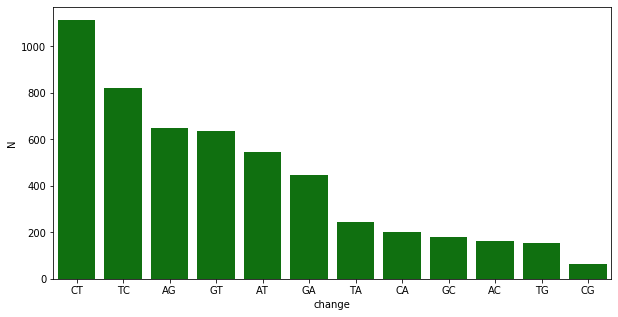

In [36]:
plt.figure(figsize=(10,5))
sns.barplot(x='change',data = pysqldf('select change,count(distinct POS) as N from va group by change order by N desc'),y='N',color='g')

In [37]:
# Total number of variants across all samples
summary = []
summary.append(['Total sites',pysqldf('select count(*) from va').to_numpy()[0][0]])
# Number of distinct positions with variants
summary.append(['Distinct positions',pysqldf('select count(distinct POS) from va').to_numpy()[0][0]])
# Number of samples containing variants
summary.append(['Distinct samples',pysqldf('select count(distinct Sample) from va').to_numpy()[0][0]])
# Number of fixed sites
summary.append(['Distinct studies',pysqldf('select count(distinct study_accession) from va').to_numpy()[0][0]])
# Number of geographic locations
summary.append(['Distinct geographic locations',pysqldf('select count(distinct geo_loc_name) from va').to_numpy()[0][0]])

In [38]:
summary

[['Total sites', 11059],
 ['Distinct positions', 4899],
 ['Distinct samples', 1093],
 ['Distinct studies', 28],
 ['Distinct geographic locations', 24]]

In [39]:
print(va['geo_loc_name'].unique())

['Germany' 'China:Shanghai' None 'USA:Virginia' 'USA: Hamilton, MT' 'USA'
 'USA:Minnesota' 'USA: Washington' 'Peru: Lima' 'USA: New York'
 'Germany: Dusseldorf' 'Bangladesh' 'USA:Los Angeles' 'China: Hubei'
 'China: Wuhan' 'Malaysia' 'India: Rajkot' 'Israel' 'Germany: Heinsberg'
 'USA: WA' 'USA: Seattle, WA' 'Cambodia:Sihanoukville'
 'Malaysia: Kuala Lumpur' 'Egypt' 'Nepal: Kathmandu']


In [40]:
from IPython.display import HTML, display
import tabulate
print(tabulate.tabulate(summary, tablefmt='md',headers=['Sites','Counts']))

Sites                            Counts
-----------------------------  --------
Total sites                       11059
Distinct positions                 4899
Distinct samples                   1093
Distinct studies                     28
Distinct geographic locations        24


In [41]:
distinct_sites = pysqldf('select POS, change, FUNCLASS, func, end-start as len, min(AF) as minAF, max(AF) as maxAF from va group by POS, change')

In [42]:
pysqldf('select count(*) from distinct_sites')

count(*)
0      5210

In [43]:
summary=pd.DataFrame()
summary = pysqldf('select FUNCLASS, count(*) as N, "fixed" as type from distinct_sites where minAF >= 0.95 group by FUNCLASS')
summary = summary.append(pysqldf('select FUNCLASS, count(*) as N, "polymorphic" as type from distinct_sites where maxAF < 0.95 group by FUNCLASS'),ignore_index=True)
summary = summary.append(pysqldf('select FUNCLASS, count(*) as N, "mixed" as type from distinct_sites where maxAF >= 0.95 and minAF < 0.95 group by FUNCLASS'),ignore_index=True)

In [44]:
print(summary.to_markdown())

|    | FUNCLASS   |    N | type        |
|---:|:-----------|-----:|:------------|
|  0 | .          |    5 | fixed       |
|  1 | MISSENSE   |  203 | fixed       |
|  2 | NONSENSE   |    1 | fixed       |
|  3 | SILENT     |  132 | fixed       |
|  4 | .          |   74 | polymorphic |
|  5 | MISSENSE   | 3207 | polymorphic |
|  6 | NONSENSE   |  192 | polymorphic |
|  7 | SILENT     | 1243 | polymorphic |
|  8 | .          |    5 | mixed       |
|  9 | MISSENSE   |   90 | mixed       |
| 10 | SILENT     |   58 | mixed       |


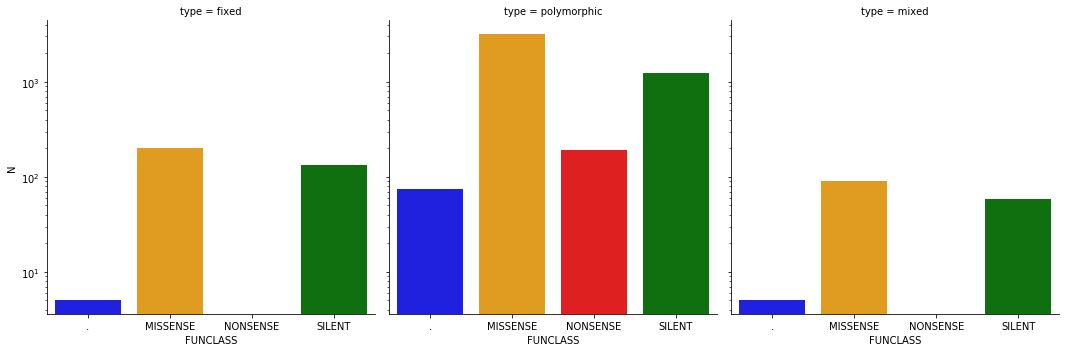

In [45]:
sns.catplot(x='FUNCLASS',col='type',y='N',data=summary,kind='bar',palette=fc_palette)
plt.yscale('log')

In [46]:
t = pysqldf('select func,FUNCLASS, count(*) as N,len from distinct_sites group by func,FUNCLASS')
t['rlen']=t['N']/t['len']
t

func  FUNCLASS    N   len      rlen
0          .         .   83   265  0.313208
1      3Cpro  MISSENSE  113   918  0.123094
2      3Cpro  NONSENSE    2   918  0.002179
3      3Cpro    SILENT   51   918  0.055556
4          E  MISSENSE   38   228  0.166667
5          E  NONSENSE    1   228  0.004386
6          E    SILENT   13   228  0.057018
7       ExoN  MISSENSE  193  1581  0.122075
8       ExoN  NONSENSE   13  1581  0.008223
9       ExoN    SILENT   94  1581  0.059456
10         M  MISSENSE   82   669  0.122571
11         M  NONSENSE    7   669  0.010463
12         M    SILENT   42   669  0.062780
13    MethTr  MISSENSE   81   894  0.090604
14    MethTr  NONSENSE    5   894  0.005593
15    MethTr    SILENT   43   894  0.048098
16         N  MISSENSE  187  1260  0.148413
17         N  NONSENSE   17  1260  0.013492
18         N    SILENT   91  1260  0.072222
19      RdRp  MISSENSE  349  2795  0.124866
20      RdRp  NONSENSE   10  2795  0.003578
21      RdRp    SILENT  138  2795  0.049374
22         S         .    1  3822  0.000262
23         S  MISSENSE  450  3822  0.117739
24         S  NONSENSE   30  3822  0.007849
25         S    SILENT  184  3822  0.048142
26     endoR  MISSENSE  113  1038  0.108863
27     endoR  NONSENSE    4  1038  0.003854
28     endoR    SILENT   29  1038  0.027938
29  helicase  MISSENSE  209  1803  0.115918
30  helicase  NONSENSE   11  1803  0.006101
31  helicase    SILENT   78  1803  0.043261
32    leader  MISSENSE   80   540  0.148148
33    leader  NONSENSE    9   540  0.016667
34    leader    SILENT   41   540  0.075926
35     nsp10  MISSENSE   65   417  0.155875
36     nsp10  NONSENSE    2   417  0.004796
37     nsp10    SILENT   22   417  0.052758
38      nsp2  MISSENSE  203  1914  0.106061
39      nsp2  NONSENSE   10  1914  0.005225
40      nsp2    SILENT   76  1914  0.039707
41      nsp3  MISSENSE  602  5835  0.103171
42      nsp3  NONSENSE   42  5835  0.007198
43      nsp3    SILENT  244  5835  0.041817
44      nsp4  MISSENSE  139  1500  0.092667
45      nsp4  NONSENSE    5  1500  0.003333
46      nsp4    SILENT   50  1500  0.033333
47      nsp6  MISSENSE  120   870  0.137931
48      nsp6  NONSENSE    3   870  0.003448
49      nsp6    SILENT   53   870  0.060920
50      nsp7  MISSENSE   38   249  0.152610
51      nsp7  NONSENSE    4   249  0.016064
52      nsp7    SILENT   19   249  0.076305
53      nsp8  MISSENSE   92   594  0.154882
54      nsp8  NONSENSE    3   594  0.005051
55      nsp8    SILENT   28   594  0.047138
56      nsp9  MISSENSE   44   339  0.129794
57      nsp9  NONSENSE    5   339  0.014749
58      nsp9    SILENT   21   339  0.061947
59     orf10  MISSENSE   13   117  0.111111
60     orf10  NONSENSE    1   117  0.008547
61     orf10    SILENT    4   117  0.034188
62     orf3a  MISSENSE  145   828  0.175121
63     orf3a  NONSENSE    4   828  0.004831
64     orf3a    SILENT   53   828  0.064010
65      orf6  MISSENSE   32   186  0.172043
66      orf6  NONSENSE    3   186  0.016129
67      orf6    SILENT   13   186  0.069892
68     orf7a  MISSENSE   41   366  0.112022
69     orf7a  NONSENSE    1   366  0.002732
70     orf7a    SILENT   10   366  0.027322
71     orf7b  MISSENSE    8   132  0.060606
72     orf7b    SILENT    8   132  0.060606
73      orf8  MISSENSE   63   366  0.172131
74      orf8  NONSENSE    1   366  0.002732
75      orf8    SILENT   28   366  0.076503

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

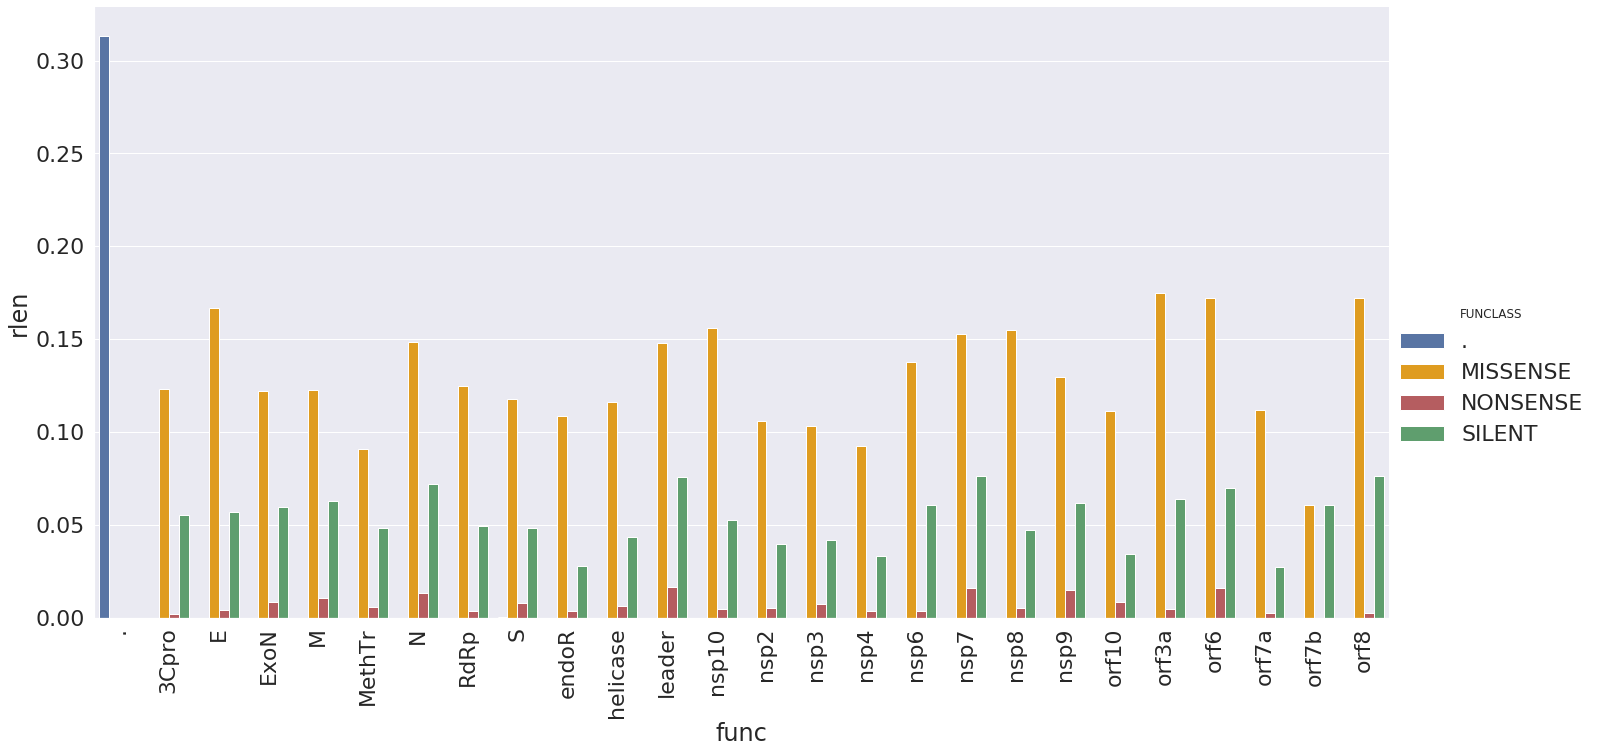

In [47]:
sns.set(font_scale=2)
sns.catplot(x='func',y='rlen',hue='FUNCLASS',data=t.sort_values(by='func'),height=10,kind='bar',aspect=2,palette=fc_palette)
plt.xticks(rotation=90)

## What's up with stops?

In [48]:
print(pysqldf('select study_accession, library_strategy, count(*) as Stops, count(distinct Sample) as Samples from va where FUNCLASS = "NONSENSE" group by study_accession order by stops desc').to_markdown())

|    | study_accession   | library_strategy   |   Stops |   Samples |
|---:|:------------------|:-------------------|--------:|----------:|
|  0 | SRP258105         | AMPLICON           |      73 |        46 |
|  1 | SRP253926         | AMPLICON           |      70 |        38 |
|  2 | SRP251618         | RNA-Seq            |      61 |        27 |
|  3 | ERP121228         | AMPLICON           |      33 |        22 |
|  4 | SRP261417         | Targeted-Capture   |      31 |        19 |
|  5 | SRP256957         | AMPLICON           |       8 |         4 |
|  6 | SRP248092         | RNA-Seq            |       6 |         3 |
|  7 | SRP255151         | AMPLICON           |       3 |         3 |
|  8 | SRP261949         | OTHER              |       2 |         1 |
|  9 | SRP258006         | AMPLICON           |       1 |         1 |
| 10 | SRP254688         | RNA-Seq            |       1 |         1 |
| 11 | SRP254488         | AMPLICON           |       1 |         1 |
| 12 | SRP242226    

<Figure size 2160x720 with 0 Axes>

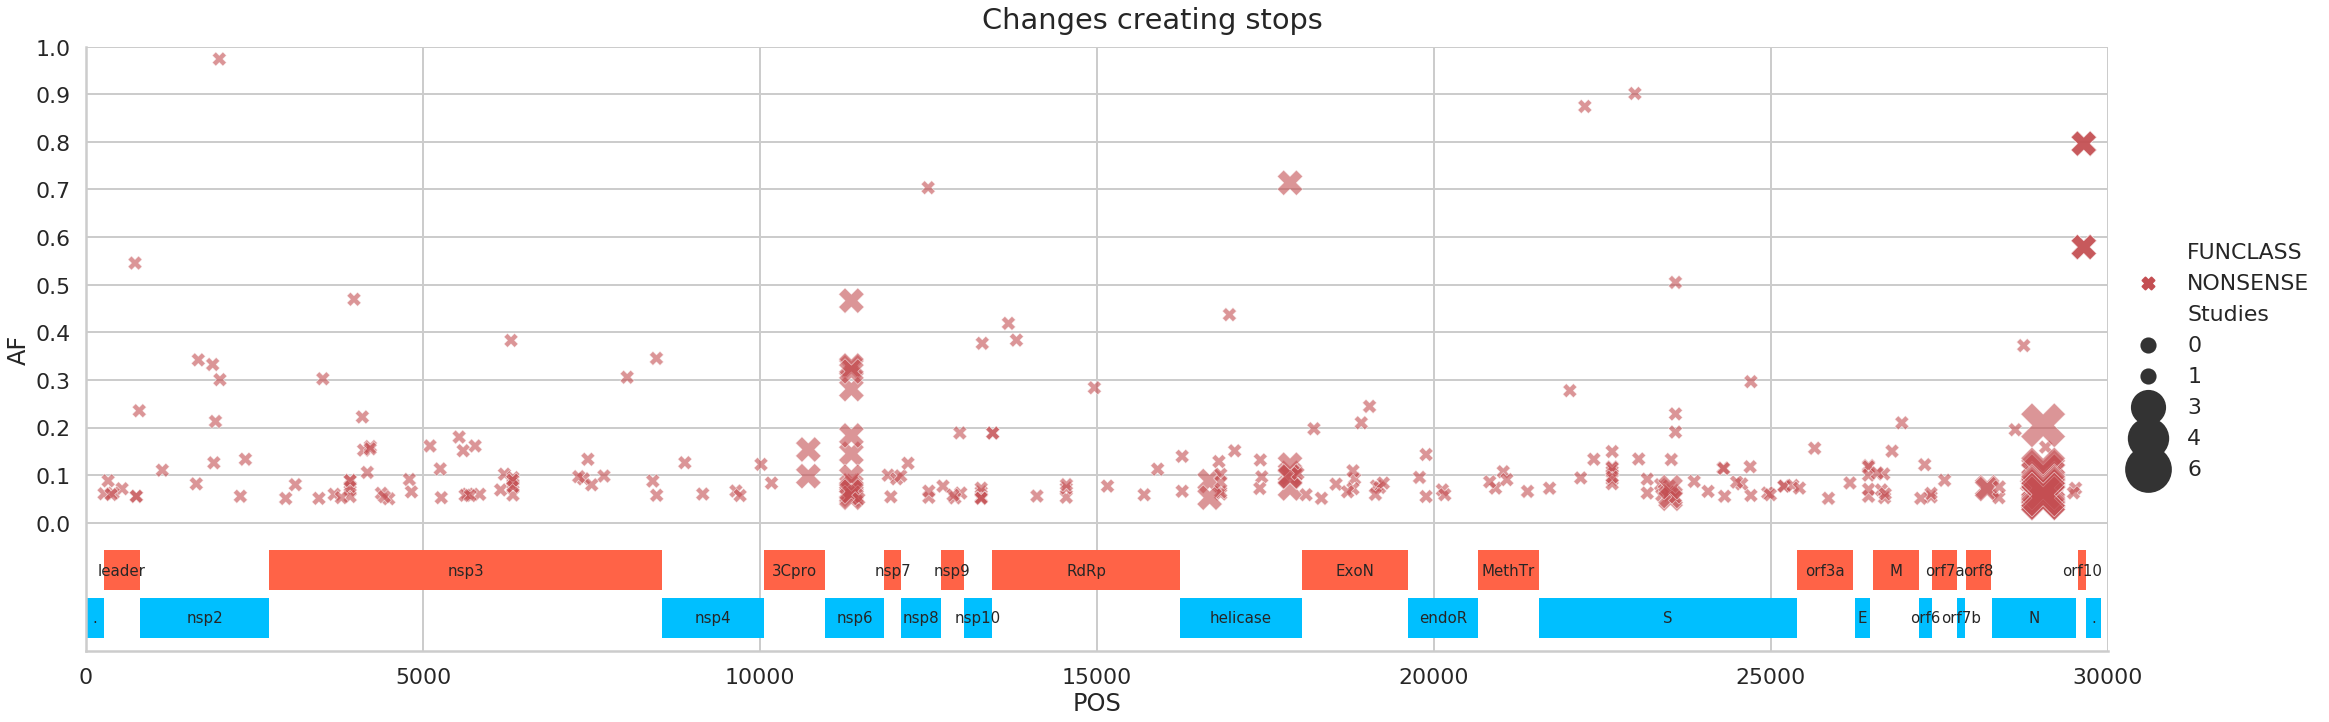

In [49]:
minimap(va[va['FUNCLASS']=='NONSENSE'],'POS','AF',annot[annot['L']>100],'Studies','FUNCLASS','FUNCLASS', 'Changes creating stops')

In [50]:
print(pysqldf('select POS, change, Samples, Studies, Strategies, GENE, func from va where FUNCLASS="NONSENSE" group by POS, change order by Studies desc').head(15).to_markdown())

|    |   POS | change   |   Samples |   Studies |   Strategies | GENE   | func     |
|---:|------:|:---------|----------:|----------:|-------------:|:-------|:---------|
|  0 | 29039 | AT       |        29 |         5 |            3 | N      | N        |
|  1 | 10718 | CT       |         2 |         2 |            1 | orf1ab | 3Cpro    |
|  2 | 11357 | AT       |        14 |         2 |            2 | orf1ab | nsp6     |
|  3 | 16672 | AT       |         2 |         2 |            2 | orf1ab | helicase |
|  4 | 17865 | TA       |         6 |         2 |            2 | orf1ab | helicase |
|  5 | 23511 | TG       |         3 |         2 |            1 | S      | S        |
|  6 | 28209 | GT       |         2 |         2 |            1 | ORF8   | orf8     |
|  7 | 29120 | CT       |         2 |         2 |            1 | N      | N        |
|  8 | 29642 | CT       |         2 |         2 |            2 | ORF10  | orf10    |
|  9 |   269 | GT       |         1 |         1 |            1 | 

In [51]:
print(pysqldf('select Sample, DP, AF, SB, DP4, GENE, CODON, study_accession, library_strategy, library_source, library_selection from va where POS = 29039 and change = "AT"').to_markdown())

|    | Sample      |   DP |       AF |   SB | DP4              | GENE   | CODON   | study_accession   | library_strategy   | library_source   | library_selection   |
|---:|:------------|-----:|---------:|-----:|:-----------------|:-------|:--------|:------------------|:-------------------|:-----------------|:--------------------|
|  0 | SRR11597150 |   52 | 0.057692 |    2 | 31,18,3,0        | N      | Aag/Tag | SRP258105         | AMPLICON           | VIRAL RNA        | PCR                 |
|  1 | SRR11597171 |   62 | 0.096774 |    2 | 43,12,6,0        | N      | Aag/Tag | SRP258105         | AMPLICON           | VIRAL RNA        | PCR                 |
|  2 | SRR11597195 |   53 | 0.056604 |    5 | 32,16,1,2        | N      | Aag/Tag | SRP258105         | AMPLICON           | VIRAL RNA        | PCR                 |
|  3 | SRR11783573 | 2015 | 0.074442 |  146 | 834,1003,28,148  | N      | Aag/Tag | SRP261417         | Targeted-Capture   | VIRAL RNA        | RT-PCR              |
|  4

In [53]:
pysqldf('select * from va where study_accession="SRP251618" and Samples>14 and Studies=1')

Sample    POS REF ALT   QUAL   DP        AF  SB         DP4  \
0   SRR11771994   5765   G   A  202.0  119  0.109244  21  47,59,11,2   
1   SRR11771994   5766   G   C  180.0  120  0.100000  18  49,59,10,2   
2   SRR11772009   5765   G   A  120.0  130  0.069231  14   57,64,8,1   
3   SRR11772009   5766   G   C  114.0  130  0.069231  10   57,63,8,2   
4   SRR11772031   5765   G   A  143.0  100  0.100000  13   40,50,8,2   
5   SRR11772031   5766   G   C  158.0  100  0.100000  13   41,49,8,2   
6   SRR11772045   5765   G   A  142.0  132  0.060606  26   56,68,8,0   
7   SRR11772045   5766   G   C  122.0  132  0.053030  22   57,68,7,0   
8   SRR11772046   5765   G   A  119.0  107  0.065421  17   52,48,7,0   
9   SRR11772051   5765   G   A  151.0  106  0.084906   7   51,46,7,2   
10  SRR11772051   5766   G   C  151.0  105  0.085714   7   51,45,7,2   
11  SRR11772053   5765   G   A  182.0  124  0.096774  11   48,64,9,3   
12  SRR11772053   5766   G   C  182.0  124  0.096774  11   49,63,9,3   
13  SRR11772055   5765   G   A  141.0  112  0.080357  12   47,55,8,2   
14  SRR11772055   5766   G   C  160.0  113  0.088496  12   48,55,8,2   
15  SRR11772057   5765   G   A  185.0  117  0.102564  25  41,63,11,2   
16  SRR11772057   5766   G   C  205.0  117  0.111111  25  41,63,11,2   
17  SRR11772058   5765   G   A  115.0  119  0.067227   8   51,59,6,2   
18  SRR11772058   5766   G   C   80.0  120  0.058333   5   53,60,5,2   
19  SRR11772059   5765   G   A  120.0  110  0.063636  24   44,59,7,0   
20  SRR11772059   5766   G   C  121.0  110  0.063636  23   45,58,7,0   
21  SRR11772063   5765   G   A  162.0  117  0.085470  21   48,59,9,1   
22  SRR11772063   5766   G   C  120.0  116  0.068966  15   50,58,7,1   
23  SRR11779978   5766   G   C   91.0  139  0.050360  12   62,70,6,1   
24  SRR11780031   5765   G   A   97.0  125  0.056000   1   61,57,3,4   
25  SRR11780031   5766   G   C  114.0  125  0.064000   3   61,56,3,5   
26  SRR11780041   5765   G   A   66.0  109  0.055046  15   50,53,6,0   
27  SRR11780041   5766   G   C   81.0  111  0.063063   9   50,54,6,1   
28  SRR11780045   5765   G   A   76.0  141  0.056738   0   65,68,4,4   
29  SRR11780045   5766   G   C   76.0  141  0.056738   0   66,67,4,4   
30  SRR11771993  29049   G   A  137.0  108  0.074074   5   51,49,6,2   
31  SRR11772009  29049   G   A  186.0  139  0.079137   0   63,64,6,5   
32  SRR11772020  29049   G   A  169.0  124  0.080645   4   57,57,7,3   
33  SRR11772031  29049   G   A  105.0  133  0.060150   7   60,65,6,2   
34  SRR11772046  29049   G   A  103.0  135  0.051852   0   64,64,4,3   
35  SRR11772048  29049   G   A   93.0  120  0.050000   3   53,61,4,2   
36  SRR11772051  29049   G   A   96.0  119  0.050420   1   56,57,4,2   
37  SRR11772053  29049   G   A  142.0  137  0.065693  10   61,67,7,2   
38  SRR11772055  29049   G   A  110.0  143  0.055944   8   63,71,6,2   
39  SRR11772057  29049   G   A  192.0  121  0.082645  34  47,64,10,0   
40  SRR11772058  29049   G   A  127.0  144  0.055556   7   67,68,7,2   
41  SRR11772059  29049   G   A  158.0  131  0.068702   7   59,63,7,2   
42  SRR11772061  29049   G   A  117.0  129  0.054264   5   58,64,5,2   
43  SRR11772065  29049   G   A  102.0  118  0.050847   9   51,61,5,1   
44  SRR11780016  29049   G   A   74.0  132  0.053030   1   60,65,4,3   

      IMPACT  FUNCLASS                 EFFECT    GENE    CODON change  \
0   MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab  Ggt/Agt     GA   
1   MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab  gGt/gCt     GC   
2   MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab  Ggt/Agt     GA   
3   MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab  gGt/gCt     GC   
4   MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab  Ggt/Agt     GA   
5   MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab  gGt/gCt     GC   
6   MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab  Ggt/Agt     GA   
7   MODERATE  MISSENSE  NON_SYNONYMOUS_CODING  orf1ab  gGt/gCt     GC   
8   MODERATE  MISSENSE  NON_SYNONYMOUS_

Text(0.5, 1.02, 'Alternatiove allele frequencies at sites shared among >= 5 Samples within study SRP251618')

<Figure size 2160x1080 with 0 Axes>

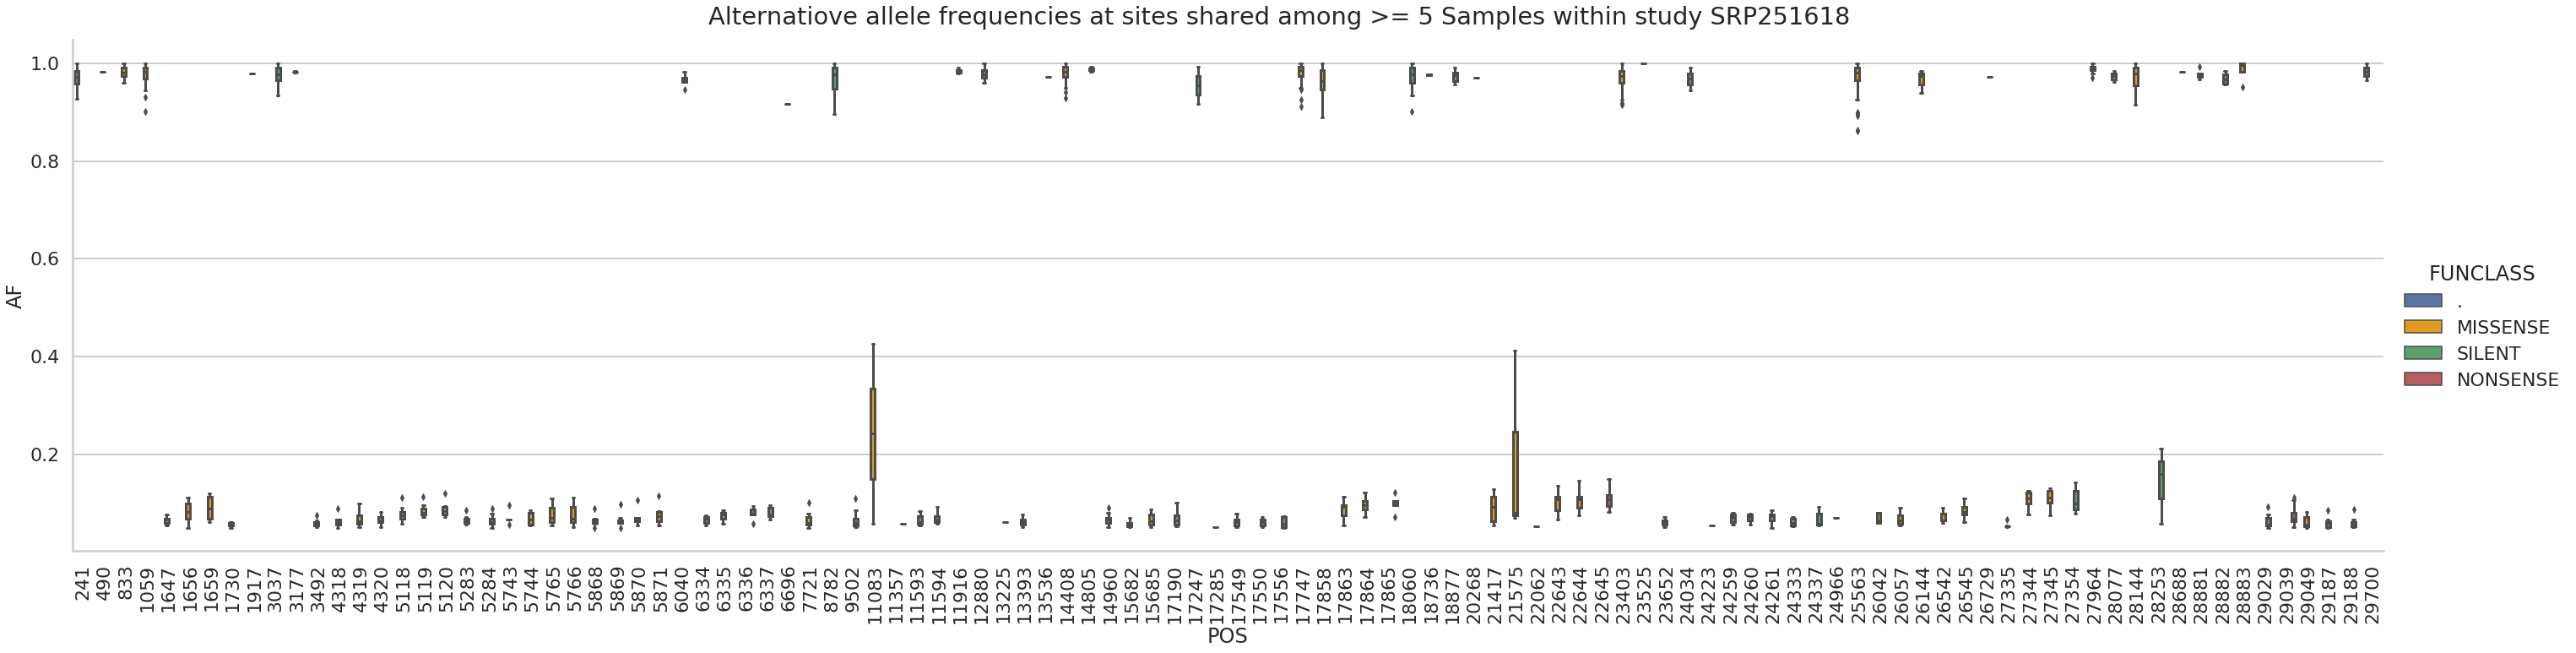

In [54]:
plt.figure(figsize=(30,15))
sns.catplot(x='POS',y='AF',data=pysqldf('select * from va where study_accession="SRP251618" and Samples>5'),height=10,aspect=4,kind='box',hue='FUNCLASS',palette=fc_palette)
plt.xticks(rotation=90)
plt.suptitle('Alternatiove allele frequencies at sites shared among >= 5 Samples within study SRP251618',y=1.02)

In [55]:
va.head()

Sample  POS REF ALT     QUAL   DP        AF  SB          DP4 IMPACT  \
0  SRR11517432  160   G   A   5015.0  159  0.937107   4   6,0,112,41      .   
1  SRR11517432  241   C   T   9603.0  291  0.958763   0  0,0,147,140      .   
2  SRR11597164  170   A   T     95.0   60  0.066667   0    27,26,2,2      .   
3  SRR11676316  241   C   T  28423.0  834  0.962830   0  0,0,362,472      .   
4  SRR11728606  241   C   T  34744.0  985  0.984772   0  0,0,430,554      .   

  FUNCLASS EFFECT GENE CODON change study_accession library_strategy  \
0        .      .    .     .     GA       SRP255853          RNA-Seq   
1        .      .    .     .     CT       SRP255853          RNA-Seq   
2        .      .    .     .     AT       SRP258105         AMPLICON   
3        .      .    .     .     CT       SRP253926         AMPLICON   
4        .      .    .     .     CT       SRP253926         AMPLICON   

       library_source library_selection collection_date    geo_loc_name  \
0  METATRANSCRIPTOMIC            RANDOM     19-MAR-2020         Germany   
1  METATRANSCRIPTOMIC            RANDOM     19-MAR-2020         Germany   
2           VIRAL RNA               PCR      2020-02-01  China:Shanghai   
3           VIRAL RNA               PCR            None            None   
4           VIRAL RNA               PCR            None            None   

    type func  start  end   A   C   G   T  Samples  Studies  Strategies  
0  5'UTR    .      0  265  67  63  55  80        1        1           1  
1  5'UTR    .      0  265  67  63  55  80      413       12           5  
2  5'UTR    .      0  265  67  63  55  80        1        1           1  
3  5'UTR    .      0  265  67  63  55  80      413       12           5  
4  5'UTR    .      0  265  67  63  55  80      413       12           5

Text(0.5, 1.02, 'Changes leading to stop versus number of STUDIES that are shared across')

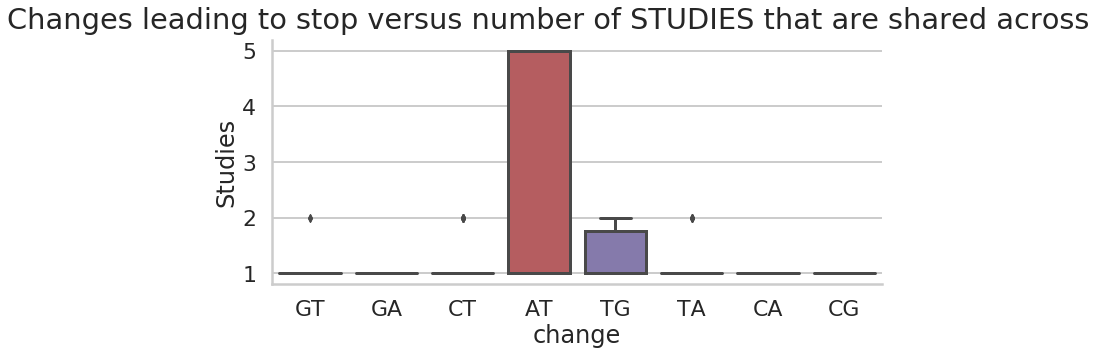

In [56]:
sns.catplot(x='change',y="Studies",kind='box',data=pysqldf('select POS, change, Samples, Studies, Strategies from va where FUNCLASS="NONSENSE"'),height=5,aspect=2)
plt.suptitle('Changes leading to stop versus number of STUDIES that are shared across',y=1.02)

Text(0.5, 1.02, 'Changes leading to stop versus number of SAMPLES that are shared across')

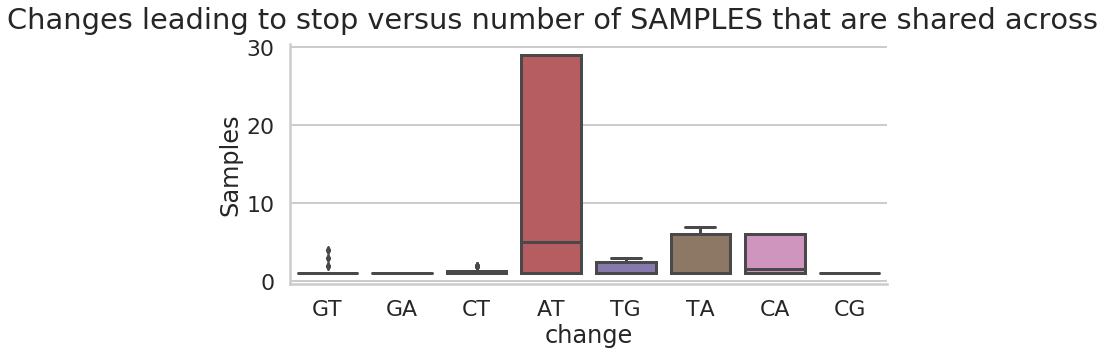

In [57]:
sns.catplot(x='change',y="Samples",kind='box',data=pysqldf('select POS, change, Samples, Studies, Strategies from va where FUNCLASS="NONSENSE"'),height=5,aspect=2)
plt.suptitle('Changes leading to stop versus number of SAMPLES that are shared across',y=1.02)

Text(0.5, 1.02, 'Changes leading to stop versus number of LIBRARY STRATEGIES that are shared across')

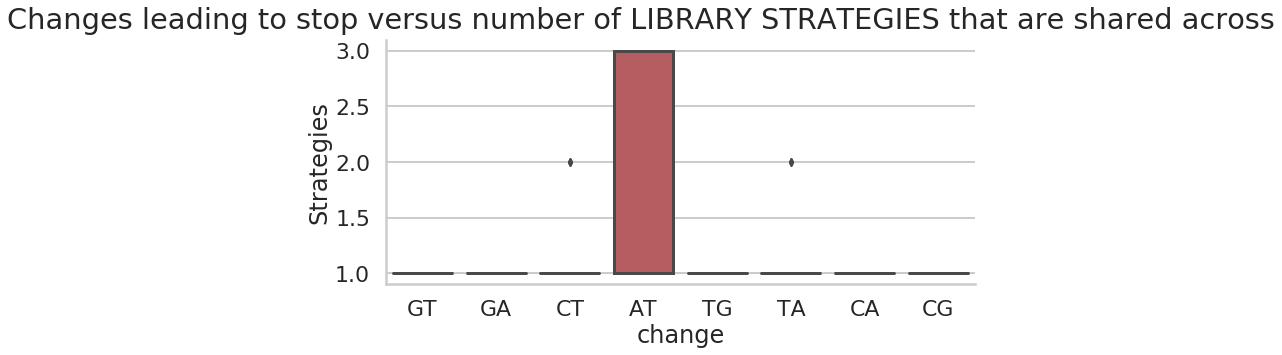

In [58]:
sns.catplot(x='change',y="Strategies",kind='box',data=pysqldf('select POS, change, Samples, Studies, Strategies from va where FUNCLASS="NONSENSE"'),height=5,aspect=2)
plt.suptitle('Changes leading to stop versus number of LIBRARY STRATEGIES that are shared across',y=1.02)

In [59]:
pysqldf('select POS, change, func, count(*) as N from va where FUNCLASS = "NONSENSE" group by POS,change order by N desc')

POS change      func   N
0    29039     AT         N  29
1    11357     AT      nsp6  14
2    22645     TA         S   7
3     6336     CA      nsp3   6
4    17865     TA  helicase   6
5    29642     CT     orf10   6
6     3920     AT      nsp3   5
7    13283     AT     nsp10   5
8    26449     AT         E   5
9    16837     GT  helicase   4
10   23584     TA         S   4
11   23511     TG         S   3
12   29240     GT         N   3
13   10718     CT     3Cpro   2
14   12506     AT      nsp8   2
15   13454     CT      RdRp   2
16   14545     AT      RdRp   2
17   16265     CA  helicase   2
18   16672     AT  helicase   2
19   18799     CT      ExoN   2
20   19884     CA     endoR   2
21   23165     AT         S   2
22   23492     CT         S   2
23   24703     TA         S   2
24   27376     GT      orf6   2
25   28209     GT      orf8   2
26   29120     CT         N   2
27     269     GT    leader   1
28     329     CT    leader   1
29     374     GT    leader   1
30     404     AT    leader   1
31     536     GT    leader   1
32     728     GT    leader   1
33     747     GA    leader   1
34     748     GA    leader   1
35     791     GT    leader   1
36    1133     AT      nsp2   1
37    1637     AT      nsp2   1
38    1667     AT      nsp2   1
39    1880     GT      nsp2   1
40    1898     CT      nsp2   1
41    1922     GT      nsp2   1
42    1979     GT      nsp2   1
43    1988     CT      nsp2   1
44    2291     CT      nsp2   1
45    2366     AT      nsp2   1
46    2964     GA      nsp3   1
47    3107     GT      nsp3   1
48    3457     CA      nsp3   1
49    3515     CT      nsp3   1
50    3683     CT      nsp3   1
51    3789     TG      nsp3   1
52    3977     GT      nsp3   1
53    4101     TA      nsp3   1
54    4120     TG      nsp3   1
55    4175     AT      nsp3   1
56    4217     AT      nsp3   1
57    4220     AT      nsp3   1
58    4384     GA      nsp3   1
59    4428     TG      nsp3   1
60    4493     AT      nsp3   1
61    4799     AT      nsp3   1
62    4829     CT      nsp3   1
63    5105     GT      nsp3   1
64    5256     TA      nsp3   1
65    5272     GA      nsp3   1
66    5537     CT      nsp3   1
67    5597     CT      nsp3   1
68    5626     TA      nsp3   1
69    5666     GT      nsp3   1
70    5702     CT      nsp3   1
71    5774     AT      nsp3   1
72    5842     CA      nsp3   1
73    6153     TA      nsp3   1
74    6209     GT      nsp3   1
75    6307     GA      nsp3   1
76    6330     CA      nsp3   1
77    7311     TA      nsp3   1
78    7382     CT      nsp3   1
79    7447     GA      nsp3   1
80    7504     CA      nsp3   1
81    7686     CA      nsp3   1
82    8030     AT      nsp3   1
83    8411     AT      nsp3   1
84    8465     AT      nsp3   1
85    8468     AT      nsp3   1
86    8886     TA      nsp4   1
87    9152     CT      nsp4   1
88    9644     CT      nsp4   1
89    9706     TA      nsp4   1
90   10016     CT      nsp4   1
91   10172     AT     3Cpro   1
92   11368     TG      nsp6   1
93   11466     GA      nsp6   1
94   11903     AT      nsp7   1
95   11942     CT      nsp7   1
96   12029     CT      nsp7   1
97   12089     CT      nsp7   1
98   12197     AT      nsp8   1
99   12496     TA      nsp8   1
100  12716     CT      nsp9   1
101  12866     GT      nsp9   1
102  12893     GT      nsp9   1
103  12966     TA      nsp9   1
104  12980     AT      nsp9   1
105  13299     TA     nsp10   1
106  13687     GT      RdRp   1
107  13806     CA      RdRp   1
108  14110     CT      RdRp   1
109  14548     GT      RdRp   1
110  14962     AT      RdRp   1
111  15157     CT      RdRp   1
112  15701     CA      RdRp   1
113  15901     AT      RdRp   1
114  16810     AT  helicase   1
115  16966     GT  helicase   1
116  17044     CT  helicase   1
117  17416     AT  helicase   1
118  17424     TG  helicase   1
119  17446     CT  helicase   1
120  17982     TA  helicase   1
121  18103     CT      ExoN   1
122  18220     AT      ExoN   1
123  18331     AT      ExoN   1
124  18

## Filtering scheme

In [60]:
pysqldf('select change,count(distinct POS) as N from va group by change order by N desc')['N'].sum()

5210

In [61]:
pysqldf('select change,count(distinct POS) as N from va where Studies > 1 group by change order by N desc')['N'].sum()

458

In [62]:
pysqldf('select change,count(distinct POS) as N from va where Studies > 1 and ( change = "CT" or change="GA" ) group by change order by N desc')['N'].sum()

215

In [63]:
pysqldf('select change,count(distinct POS) as N from va where Studies > 1 and ( change = "AG" or change="TC" ) group by change order by N desc')['N'].sum()

110

Text(0.5, 1.02, 'Distinct positions shared across 1 or more studies')

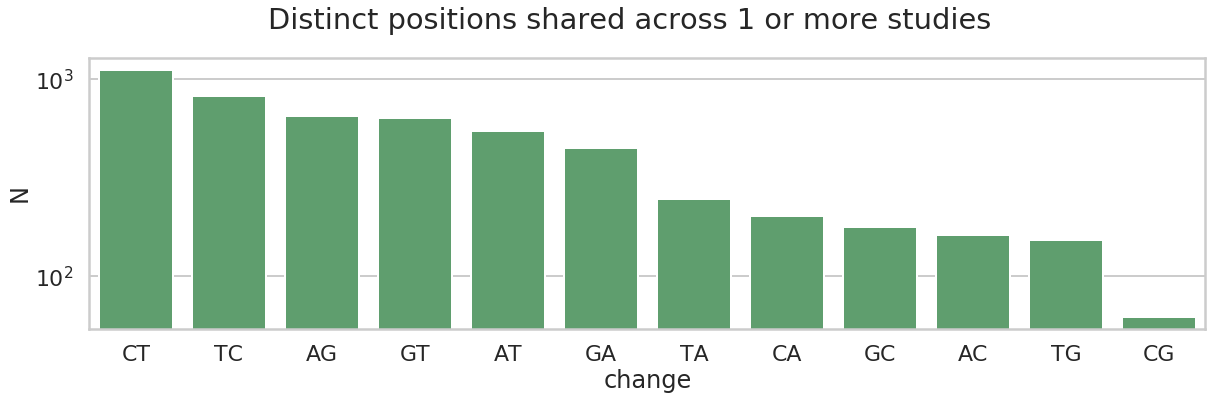

In [64]:
plt.figure(figsize=(20,5))
sns.barplot(x='change',data = pysqldf('select change,count(distinct POS) as N from va group by change order by N desc'),y='N',color='g')
plt.yscale('log')
plt.suptitle('Distinct positions shared across 1 or more studies',y=1.02)

Text(0.5, 1.02, 'Distinct positions shared across 2 or more studies')

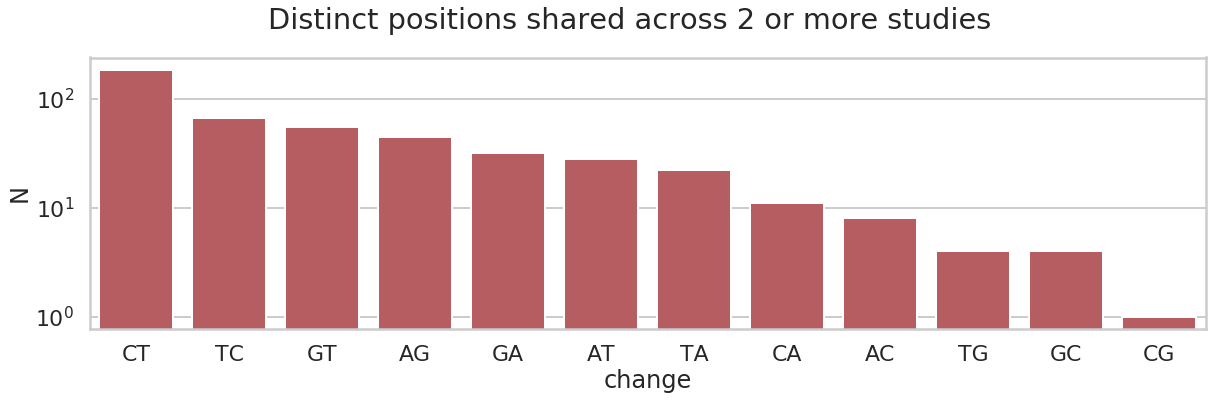

In [65]:
plt.figure(figsize=(20,5))
sns.barplot(x='change',data = pysqldf('select Studies,change,count(distinct POS) as N from va where Studies>1 group by change order by N desc'),y='N',color='r')
plt.yscale('log')
plt.suptitle('Distinct positions shared across 2 or more studies',y=1.02)

In [66]:
pysqldf('select count(distinct Sample) from va')

count(distinct Sample)
0                    1093

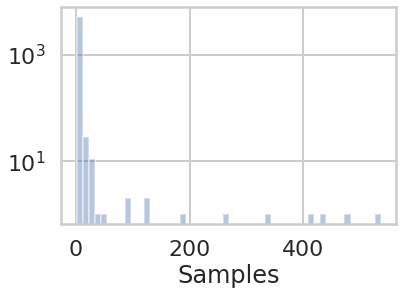

In [67]:
sns.distplot(samples_per_change['Samples'],kde=False)
plt.yscale('log')

In [68]:
pysqldf('select count(distinct study_accession) from va')

count(distinct study_accession)
0                               28

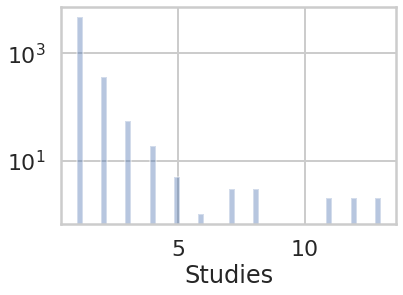

In [69]:
sns.distplot(studies_per_change['Studies'],kde=False)
plt.yscale('log')

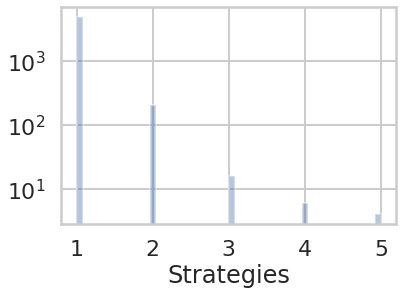

In [70]:
sns.distplot(strategies_per_change['Strategies'],kde=False)
plt.yscale('log')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38]),
 <a list of 39 Text xticklabel objects>)

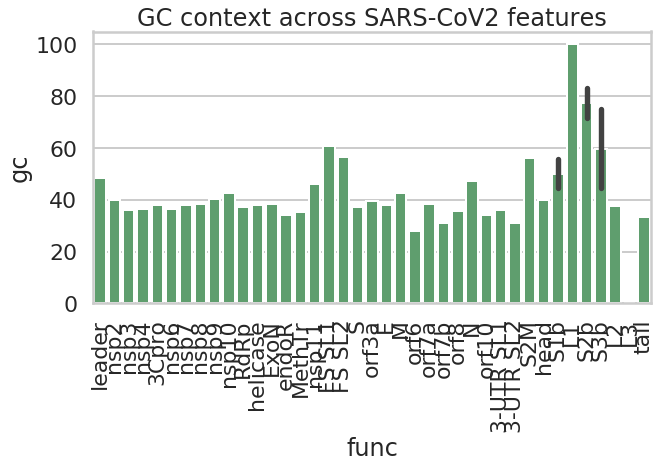

In [71]:
plt.figure(figsize=(10,5))
sns.barplot(x='func',y='gc',data=annot[annot['func']!='.'],color='g').set_title('GC context across SARS-CoV2 features')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

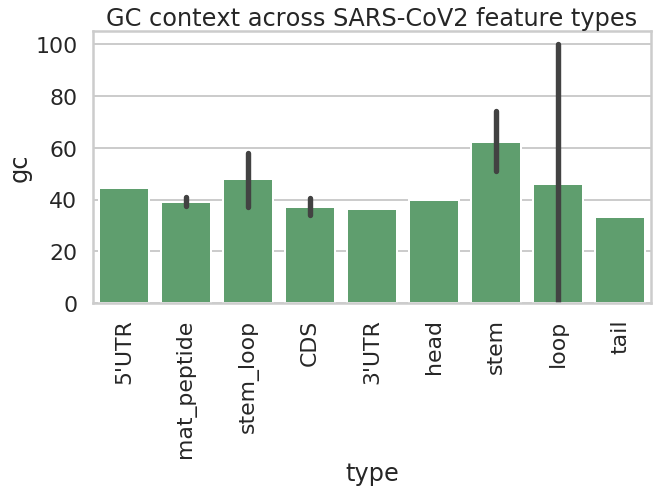

In [72]:
plt.figure(figsize=(10,5))
sns.barplot(x='type',y='gc',data=annot,color='g').set_title('GC context across SARS-CoV2 feature types')
plt.xticks(rotation=90)

In [73]:
va.head()

Sample  POS REF ALT     QUAL   DP        AF  SB          DP4 IMPACT  \
0  SRR11517432  160   G   A   5015.0  159  0.937107   4   6,0,112,41      .   
1  SRR11517432  241   C   T   9603.0  291  0.958763   0  0,0,147,140      .   
2  SRR11597164  170   A   T     95.0   60  0.066667   0    27,26,2,2      .   
3  SRR11676316  241   C   T  28423.0  834  0.962830   0  0,0,362,472      .   
4  SRR11728606  241   C   T  34744.0  985  0.984772   0  0,0,430,554      .   

  FUNCLASS EFFECT GENE CODON change study_accession library_strategy  \
0        .      .    .     .     GA       SRP255853          RNA-Seq   
1        .      .    .     .     CT       SRP255853          RNA-Seq   
2        .      .    .     .     AT       SRP258105         AMPLICON   
3        .      .    .     .     CT       SRP253926         AMPLICON   
4        .      .    .     .     CT       SRP253926         AMPLICON   

       library_source library_selection collection_date    geo_loc_name  \
0  METATRANSCRIPTOMIC            RANDOM     19-MAR-2020         Germany   
1  METATRANSCRIPTOMIC            RANDOM     19-MAR-2020         Germany   
2           VIRAL RNA               PCR      2020-02-01  China:Shanghai   
3           VIRAL RNA               PCR            None            None   
4           VIRAL RNA               PCR            None            None   

    type func  start  end   A   C   G   T  Samples  Studies  Strategies  
0  5'UTR    .      0  265  67  63  55  80        1        1           1  
1  5'UTR    .      0  265  67  63  55  80      413       12           5  
2  5'UTR    .      0  265  67  63  55  80        1        1           1  
3  5'UTR    .      0  265  67  63  55  80      413       12           5  
4  5'UTR    .      0  265  67  63  55  80      413       12           5

In [74]:
pysqldf('select type, count(*) from va group by type')

type  count(*)
0        3'UTR        76
1        5'UTR       459
2          CDS      3576
3         loop         4
4  mat_peptide      6850
5         stem        25
6    stem_loop        69

In [75]:
# Add sequence context for plus and minus
for index,row in va.iterrows():
    start_up = row['POS']-3
    end_up = row['POS']
    start_dn = row['POS']-1
    end_dn = row['POS']+2
    start_mid = row['POS']-2
    end_mid = row['POS']+1
    va.loc[index,'up'] = str(genome.seq[start_up:end_up])
    va.loc[index,'down'] = str(genome.seq[start_dn:end_dn])
    va.loc[index,'mid'] = str(genome.seq[start_mid:end_mid])
    va.loc[index,'left'] = str(genome.seq[start_mid:start_mid+1])
    va.loc[index,'right'] = str(genome.seq[start_dn+1:start_dn+2])

In [76]:
va.head()

Sample  POS REF ALT     QUAL   DP        AF  SB          DP4 IMPACT  \
0  SRR11517432  160   G   A   5015.0  159  0.937107   4   6,0,112,41      .   
1  SRR11517432  241   C   T   9603.0  291  0.958763   0  0,0,147,140      .   
2  SRR11597164  170   A   T     95.0   60  0.066667   0    27,26,2,2      .   
3  SRR11676316  241   C   T  28423.0  834  0.962830   0  0,0,362,472      .   
4  SRR11728606  241   C   T  34744.0  985  0.984772   0  0,0,430,554      .   

  FUNCLASS EFFECT GENE CODON change study_accession library_strategy  \
0        .      .    .     .     GA       SRP255853          RNA-Seq   
1        .      .    .     .     CT       SRP255853          RNA-Seq   
2        .      .    .     .     AT       SRP258105         AMPLICON   
3        .      .    .     .     CT       SRP253926         AMPLICON   
4        .      .    .     .     CT       SRP253926         AMPLICON   

       library_source library_selection collection_date    geo_loc_name  \
0  METATRANSCRIPTOMIC            RANDOM     19-MAR-2020         Germany   
1  METATRANSCRIPTOMIC            RANDOM     19-MAR-2020         Germany   
2           VIRAL RNA               PCR      2020-02-01  China:Shanghai   
3           VIRAL RNA               PCR            None            None   
4           VIRAL RNA               PCR            None            None   

    type func  start  end   A   C   G   T  Samples  Studies  Strategies   up  \
0  5'UTR    .      0  265  67  63  55  80        1        1           1  AGG   
1  5'UTR    .      0  265  67  63  55  80      413       12           5  TTC   
2  5'UTR    .      0  265  67  63  55  80        1        1           1  TAA   
3  5'UTR    .      0  265  67  63  55  80      413       12           5  TTC   
4  5'UTR    .      0  265  67  63  55  80      413       12           5  TTC   

  down  mid left right  
0  GAC  GGA    G     A  
1  CGT  TCG    T     G  
2  ACT  AAC    A     C  
3  CGT  TCG    T     G  
4  CGT  TCG    T     G

In [77]:
va.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11059 entries, 0 to 11058
Columns: 37 entries, Sample to right
dtypes: float64(2), int64(12), object(23)
memory usage: 3.1+ MB


In [78]:
va = va[va['Studies']>1]

In [79]:
va.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5130 entries, 1 to 11058
Columns: 37 entries, Sample to right
dtypes: float64(2), int64(12), object(23)
memory usage: 1.5+ MB


## Analysis of APOBEC editing

APOBEC (apolipoprotein B mRNA editing enzyme, catalytic polypeptide-like) converts `C` in single stranded stretches of DNA or RNA to `U` resulting `C`->`T` transition.  Members of APOBEC family target specific sequence motifs: `TC`, `CCC`, `TTC` where the last base mutated to `T`, or `TCW` (`W`=`A`/`T`) where the middle base mutates to `T`.

The majority of mutations observed on this data are `T` to `C`:

Text(0.5, 1.02, 'Substitutions by type')

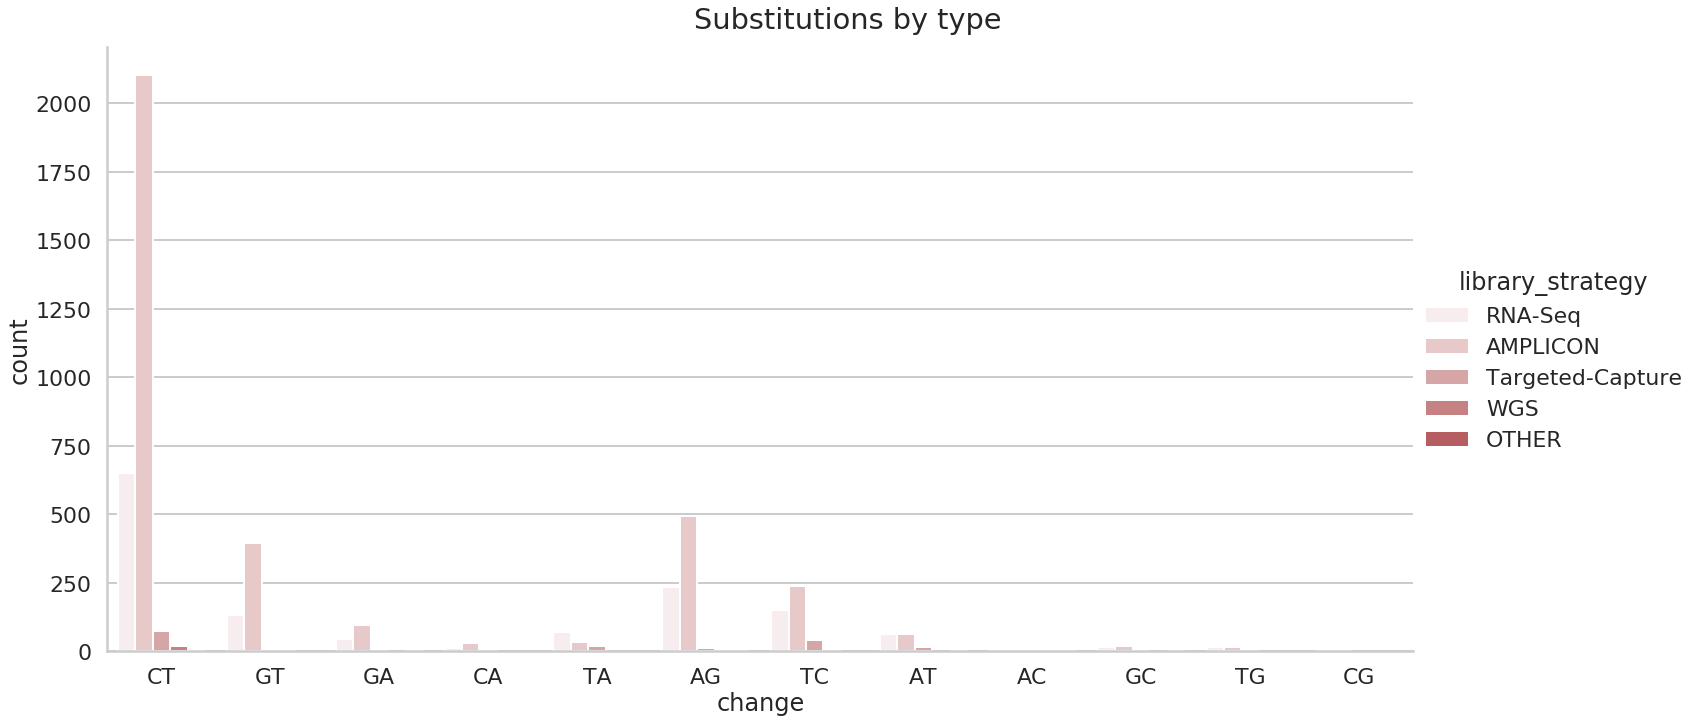

In [80]:
sns.catplot(x='change', data=va, kind="count", color='r', height=10,aspect=2,hue='library_strategy')
plt.suptitle('Substitutions by type',y=1.02)

In [81]:
ct = pysqldf('select POS, count(*) as N, Samples, Studies, Strategies change, GENE, FUNCLASS, type, func, up, down, mid from va where change = "CT" group by POS, change order by Studies desc')

In [82]:
ct

POS    N  Samples  Studies  change    GENE  FUNCLASS         type  \
0     3037  431      431       13       5  orf1ab    SILENT  mat_peptide   
1      241  413      413       12       5       .         .        5'UTR   
2     8782  129      129       11       4  orf1ab    SILENT  mat_peptide   
3    14408  537      537       11       5  orf1ab  MISSENSE  mat_peptide   
4    18060  119      119        7       4  orf1ab    SILENT  mat_peptide   
5    28253   20       20        6       2    ORF8    SILENT          CDS   
6     1059  265      265        5       3  orf1ab  MISSENSE  mat_peptide   
7    18877   22       22        5       2  orf1ab    SILENT  mat_peptide   
8     6696    7        7        4       2  orf1ab  MISSENSE  mat_peptide   
9     9502   33       33        4       2  orf1ab    SILENT  mat_peptide   
10   13225   22       22        4       2  orf1ab    SILENT  mat_peptide   
11   14805   12       12        4       2  orf1ab    SILENT  mat_peptide   
12   17285    6        6        4       2  orf1ab  MISSENSE  mat_peptide   
13   17747   93       93        4       3  orf1ab  MISSENSE  mat_peptide   
14   22062    7        7        4       3       S  MISSENSE          CDS   
15   24034    9        9        4       2       S    SILENT          CDS   
16   29187   33       33        4       2       N  MISSENSE          CDS   
17   29774    5        5        4       2       .         .        3'UTR   
18     203    3        3        3       2       .         .        5'UTR   
19     593    3        3        3       2  orf1ab  MISSENSE  mat_peptide   
20     635    3        3        3       2  orf1ab  MISSENSE  mat_peptide   
21     679    3        3        3       2  orf1ab    SILENT  mat_peptide   
22     683    5        5        3       1  orf1ab    SILENT  mat_peptide   
23     906    7        7        3       2  orf1ab  MISSENSE  mat_peptide   
24    3096    3        3        3       2  orf1ab  MISSENSE  mat_peptide   
25    3177    8        8        3       2  orf1ab  MISSENSE  mat_peptide   
26    4540   10       10        3       1  orf1ab    SILENT  mat_peptide   
27    5784    3        3        3       3  orf1ab  MISSENSE  mat_peptide   
28    6027    3        3        3       2  orf1ab  MISSENSE  mat_peptide   
29    6040    8        8        3       2  orf1ab    SILENT  mat_peptide   
30    7869    3        3        3       2  orf1ab  MISSENSE  mat_peptide   
31   14786    3        3        3       2  orf1ab  MISSENSE  mat_peptide   
32   16080    4        4        3       2  orf1ab    SILENT  mat_peptide   
33   16111    3        3        3       2  orf1ab    SILENT  mat_peptide   
34   16887    3        3        3       2  orf1ab    SILENT  mat_peptide   
35   17288    4        4        3       1  orf1ab  MISSENSE  mat_peptide   
36   17550    3        3        3       2  orf1ab    SILENT  mat_peptide   
37   17676    3        3        3       1  orf1ab    SILENT  mat_peptide   
38   18508    5        5        3       2  orf1ab  MISSENSE  mat_peptide   
39   18881    3        3        3       1  orf1ab  MISSENSE  mat_peptide   
40   21575    6        6        3       2       S  MISSENSE          CDS   
41   23525    6        6        3       2       S  MISSENSE          CDS   
42   23635    3        3        3       1       S    SILENT          CDS   
43   24223    7        7        3       2       S    SILENT          CDS   
44   25433    3        3        3       1   ORF3a  MISSENSE          CDS   
45   25521    5        5        3       2   ORF3a    SILENT          CDS   
46   25603    3        3        3       2   ORF3a    SILENT          CDS   
47   26801    3        3        3       2       M    SILENT          CDS   
48      71    2        2        2       1       .         .        5'UTR   
49     171    2        2        2       1       .         .        5'UTR   
50     222    2        2        2       2       .         .        5'UTR   
51     313    5        5        2       2  orf1ab    SI

In [83]:
ga = pysqldf('select POS, count(*) as N, change, GENE, FUNCLASS, type, func, up, down, mid from va where change = "GA" group by POS')

In [84]:
ct

POS    N  Samples  Studies  change    GENE  FUNCLASS         type  \
0     3037  431      431       13       5  orf1ab    SILENT  mat_peptide   
1      241  413      413       12       5       .         .        5'UTR   
2     8782  129      129       11       4  orf1ab    SILENT  mat_peptide   
3    14408  537      537       11       5  orf1ab  MISSENSE  mat_peptide   
4    18060  119      119        7       4  orf1ab    SILENT  mat_peptide   
5    28253   20       20        6       2    ORF8    SILENT          CDS   
6     1059  265      265        5       3  orf1ab  MISSENSE  mat_peptide   
7    18877   22       22        5       2  orf1ab    SILENT  mat_peptide   
8     6696    7        7        4       2  orf1ab  MISSENSE  mat_peptide   
9     9502   33       33        4       2  orf1ab    SILENT  mat_peptide   
10   13225   22       22        4       2  orf1ab    SILENT  mat_peptide   
11   14805   12       12        4       2  orf1ab    SILENT  mat_peptide   
12   17285    6        6        4       2  orf1ab  MISSENSE  mat_peptide   
13   17747   93       93        4       3  orf1ab  MISSENSE  mat_peptide   
14   22062    7        7        4       3       S  MISSENSE          CDS   
15   24034    9        9        4       2       S    SILENT          CDS   
16   29187   33       33        4       2       N  MISSENSE          CDS   
17   29774    5        5        4       2       .         .        3'UTR   
18     203    3        3        3       2       .         .        5'UTR   
19     593    3        3        3       2  orf1ab  MISSENSE  mat_peptide   
20     635    3        3        3       2  orf1ab  MISSENSE  mat_peptide   
21     679    3        3        3       2  orf1ab    SILENT  mat_peptide   
22     683    5        5        3       1  orf1ab    SILENT  mat_peptide   
23     906    7        7        3       2  orf1ab  MISSENSE  mat_peptide   
24    3096    3        3        3       2  orf1ab  MISSENSE  mat_peptide   
25    3177    8        8        3       2  orf1ab  MISSENSE  mat_peptide   
26    4540   10       10        3       1  orf1ab    SILENT  mat_peptide   
27    5784    3        3        3       3  orf1ab  MISSENSE  mat_peptide   
28    6027    3        3        3       2  orf1ab  MISSENSE  mat_peptide   
29    6040    8        8        3       2  orf1ab    SILENT  mat_peptide   
30    7869    3        3        3       2  orf1ab  MISSENSE  mat_peptide   
31   14786    3        3        3       2  orf1ab  MISSENSE  mat_peptide   
32   16080    4        4        3       2  orf1ab    SILENT  mat_peptide   
33   16111    3        3        3       2  orf1ab    SILENT  mat_peptide   
34   16887    3        3        3       2  orf1ab    SILENT  mat_peptide   
35   17288    4        4        3       1  orf1ab  MISSENSE  mat_peptide   
36   17550    3        3        3       2  orf1ab    SILENT  mat_peptide   
37   17676    3        3        3       1  orf1ab    SILENT  mat_peptide   
38   18508    5        5        3       2  orf1ab  MISSENSE  mat_peptide   
39   18881    3        3        3       1  orf1ab  MISSENSE  mat_peptide   
40   21575    6        6        3       2       S  MISSENSE          CDS   
41   23525    6        6        3       2       S  MISSENSE          CDS   
42   23635    3        3        3       1       S    SILENT          CDS   
43   24223    7        7        3       2       S    SILENT          CDS   
44   25433    3        3        3       1   ORF3a  MISSENSE          CDS   
45   25521    5        5        3       2   ORF3a    SILENT          CDS   
46   25603    3        3        3       2   ORF3a    SILENT          CDS   
47   26801    3        3        3       2       M    SILENT          CDS   
48      71    2        2        2       1       .         .        5'UTR   
49     171    2        2        2       1       .         .        5'UTR   
50     222    2        2        2       2       .         .        5'UTR   
51     313    5        5        2       2  orf1ab    SI

Text(0.5, 0.98, 'Number of Samples with a given C->T substitution vs. upstream motif')

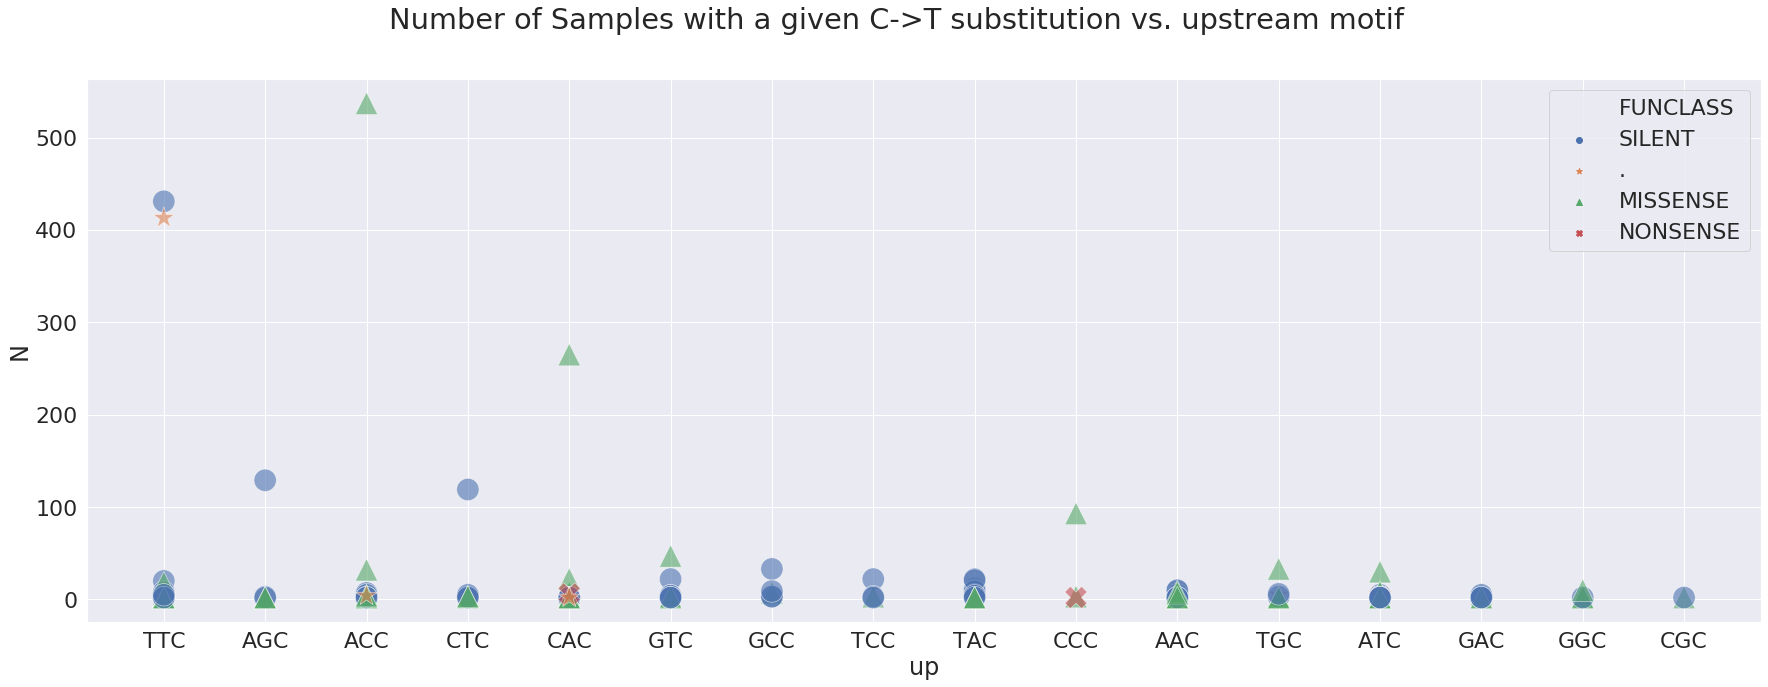

In [85]:
sns.set(font_scale=2)
plt.figure(figsize=(30,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.scatterplot(x='up',y='N',s=500,data=ct,alpha=0.6,style='FUNCLASS',hue='FUNCLASS',markers=markers)
#plt.yscale('log')
plt.suptitle('Number of Samples with a given C->T substitution vs. upstream motif')

Text(0.5, 1.02, 'Distinct C-to-T sites versus upstream context')

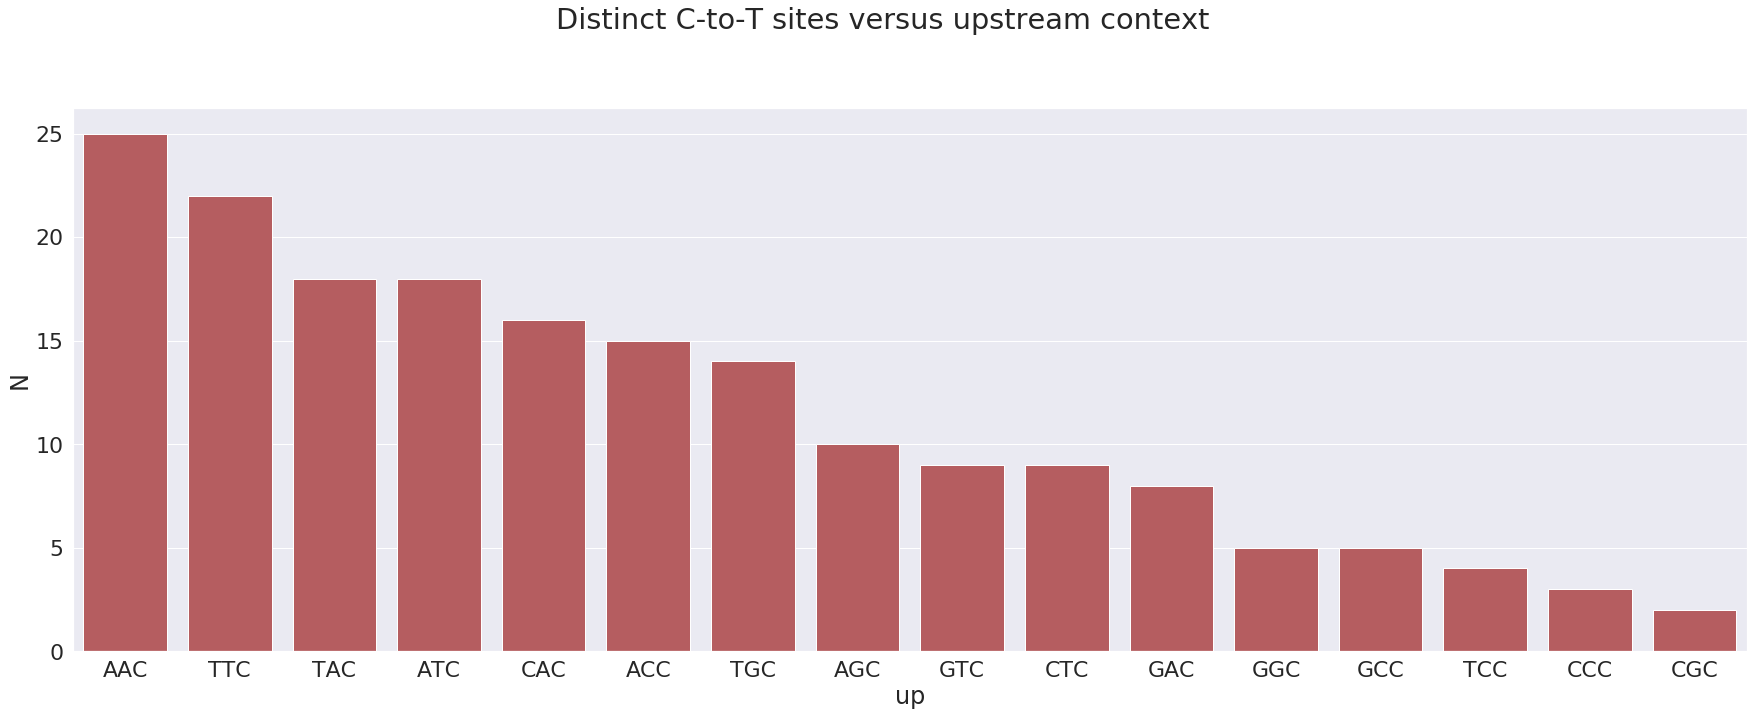

In [86]:
plt.figure(figsize=(30,10))
sns.barplot(x='up',y='N', data=pysqldf('select up, count(*) as N from ct group by up order by N desc'),color='r')
plt.suptitle('Distinct C-to-T sites versus upstream context',y=1.02)

In [87]:
print(pysqldf('select * from ct where N > 100 order by POS').to_markdown())

|    |   POS |   N |   Samples |   Studies |   change | GENE   | FUNCLASS   | type        | func   | up   | down   | mid   |
|---:|------:|----:|----------:|----------:|---------:|:-------|:-----------|:------------|:-------|:-----|:-------|:------|
|  0 |   241 | 413 |       413 |        12 |        5 | .      | .          | 5'UTR       | .      | TTC  | CGT    | TCG   |
|  1 |  1059 | 265 |       265 |         5 |        3 | orf1ab | MISSENSE   | mat_peptide | nsp2   | CAC  | CCT    | ACC   |
|  2 |  3037 | 431 |       431 |        13 |        5 | orf1ab | SILENT     | mat_peptide | nsp3   | TTC  | CTA    | TCT   |
|  3 |  8782 | 129 |       129 |        11 |        4 | orf1ab | SILENT     | mat_peptide | nsp4   | AGC  | CCA    | GCC   |
|  4 | 14408 | 537 |       537 |        11 |        5 | orf1ab | MISSENSE   | mat_peptide | RdRp   | ACC  | CTA    | CCT   |
|  5 | 18060 | 119 |       119 |         7 |        4 | orf1ab | SILENT     | mat_peptide | ExoN   | CTC  | CTT    | TCT   |


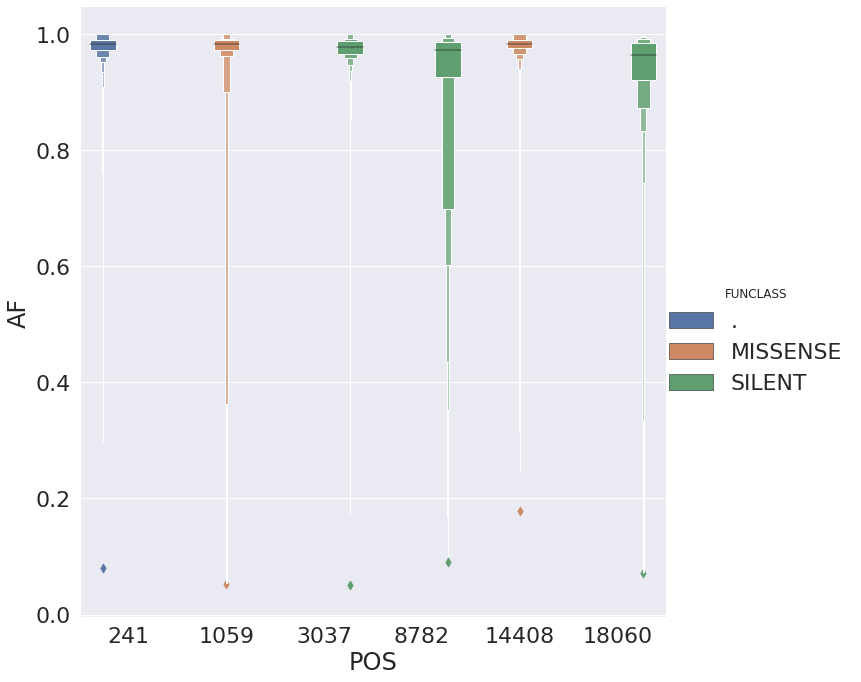

In [88]:
sns.catplot(x='POS',y='AF',height=10,kind='boxen',data=va[ ( va['POS'].isin(ct[ct['N']>100]['POS'].to_numpy()) ) & (va['change']=='CT')],hue='FUNCLASS')

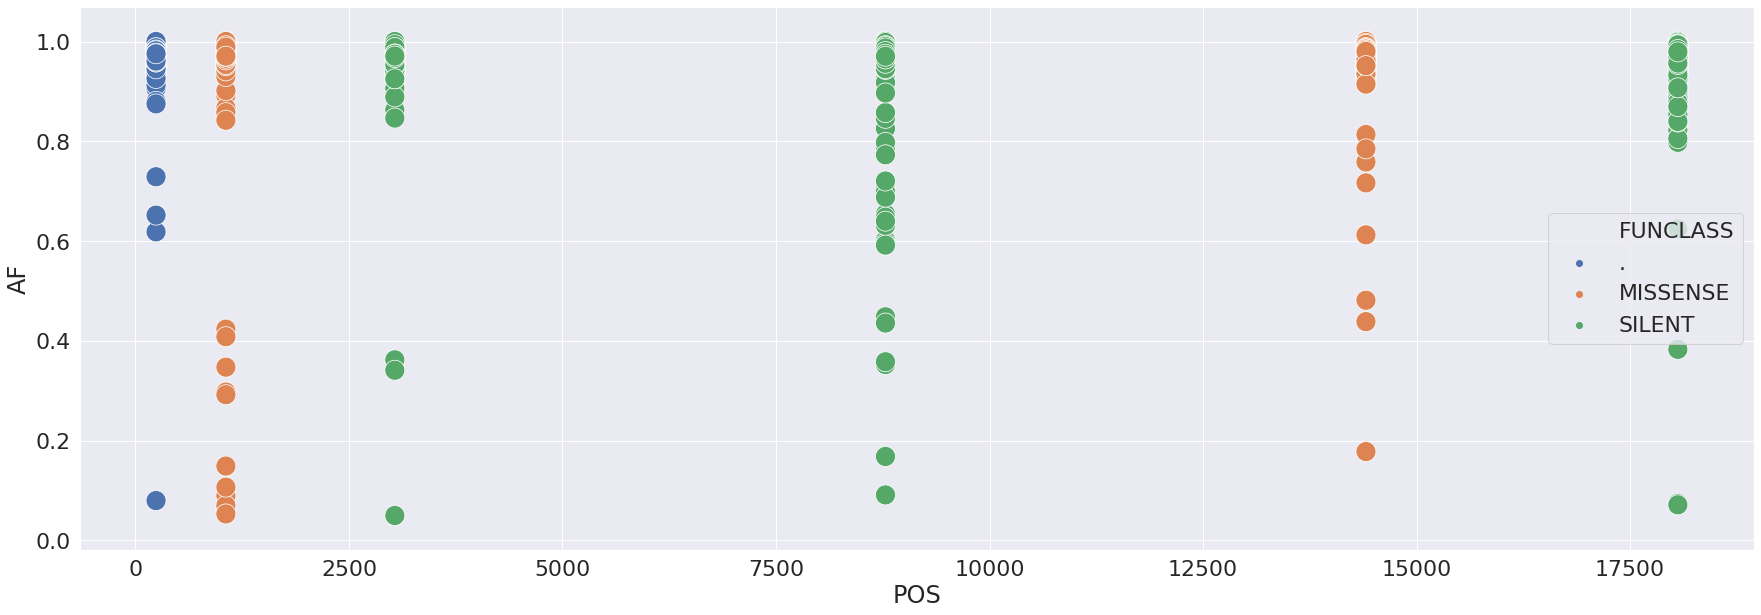

In [89]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='POS',y='AF',data=va[ ( va['POS'].isin(ct[ct['N']>100]['POS'].to_numpy()) ) & (va['change']=='CT')],s=400,hue='FUNCLASS')

In [90]:
ct[ct['N']>100]

POS    N  Samples  Studies  change    GENE  FUNCLASS         type  func  \
0   3037  431      431       13       5  orf1ab    SILENT  mat_peptide  nsp3   
1    241  413      413       12       5       .         .        5'UTR     .   
2   8782  129      129       11       4  orf1ab    SILENT  mat_peptide  nsp4   
3  14408  537      537       11       5  orf1ab  MISSENSE  mat_peptide  RdRp   
4  18060  119      119        7       4  orf1ab    SILENT  mat_peptide  ExoN   
6   1059  265      265        5       3  orf1ab  MISSENSE  mat_peptide  nsp2   

    up down  mid  
0  TTC  CTA  TCT  
1  TTC  CGT  TCG  
2  AGC  CCA  GCC  
3  ACC  CTA  CCT  
4  CTC  CTT  TCT  
6  CAC  CCT  ACC

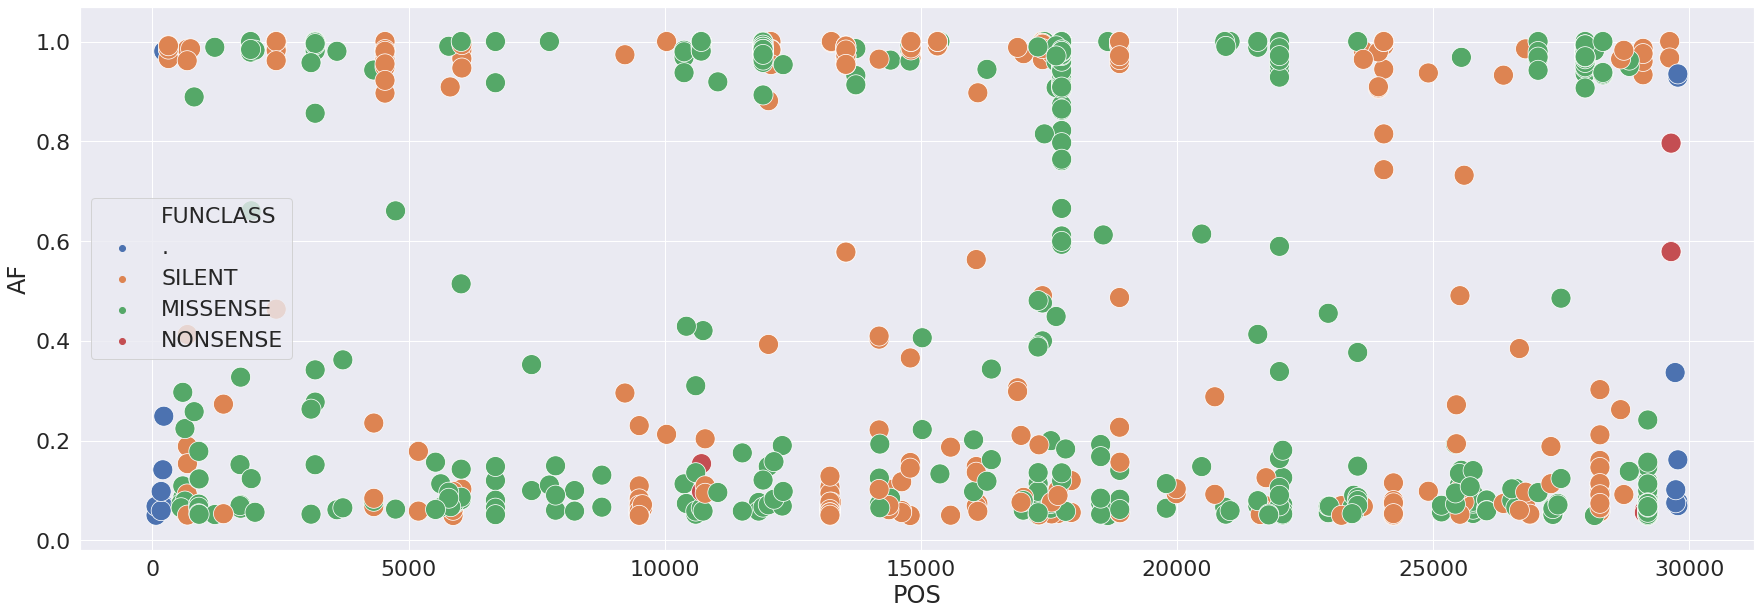

In [91]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='POS',y='AF',data=va[ ( va['POS'].isin(ct[ct['N']<100]['POS'].to_numpy()) ) & (va['change']=='CT')],s=400,hue='FUNCLASS')

Text(0.5, 0.98, 'Number of Samples with a given G->A substitution vs. downstream motif')

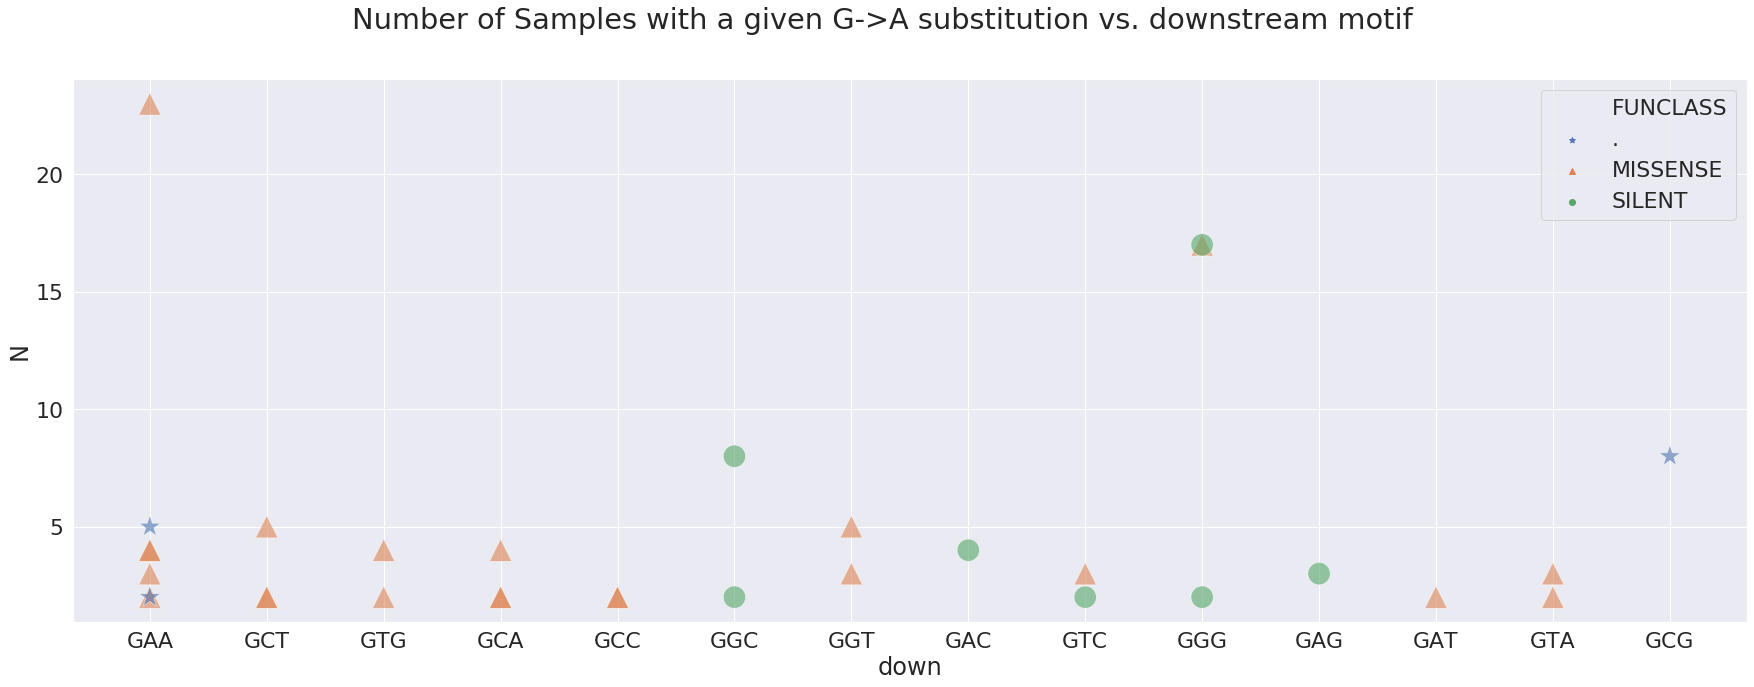

In [92]:
sns.set(font_scale=2)
plt.figure(figsize=(30,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.scatterplot(x='down',y='N',s=500,data=ga,alpha=0.6,style='FUNCLASS',hue='FUNCLASS',markers=markers)
#plt.yscale('log')
plt.suptitle('Number of Samples with a given G->A substitution vs. downstream motif')

Text(0.5, 1.02, 'Distinct G-to-A sites versus downstream context')

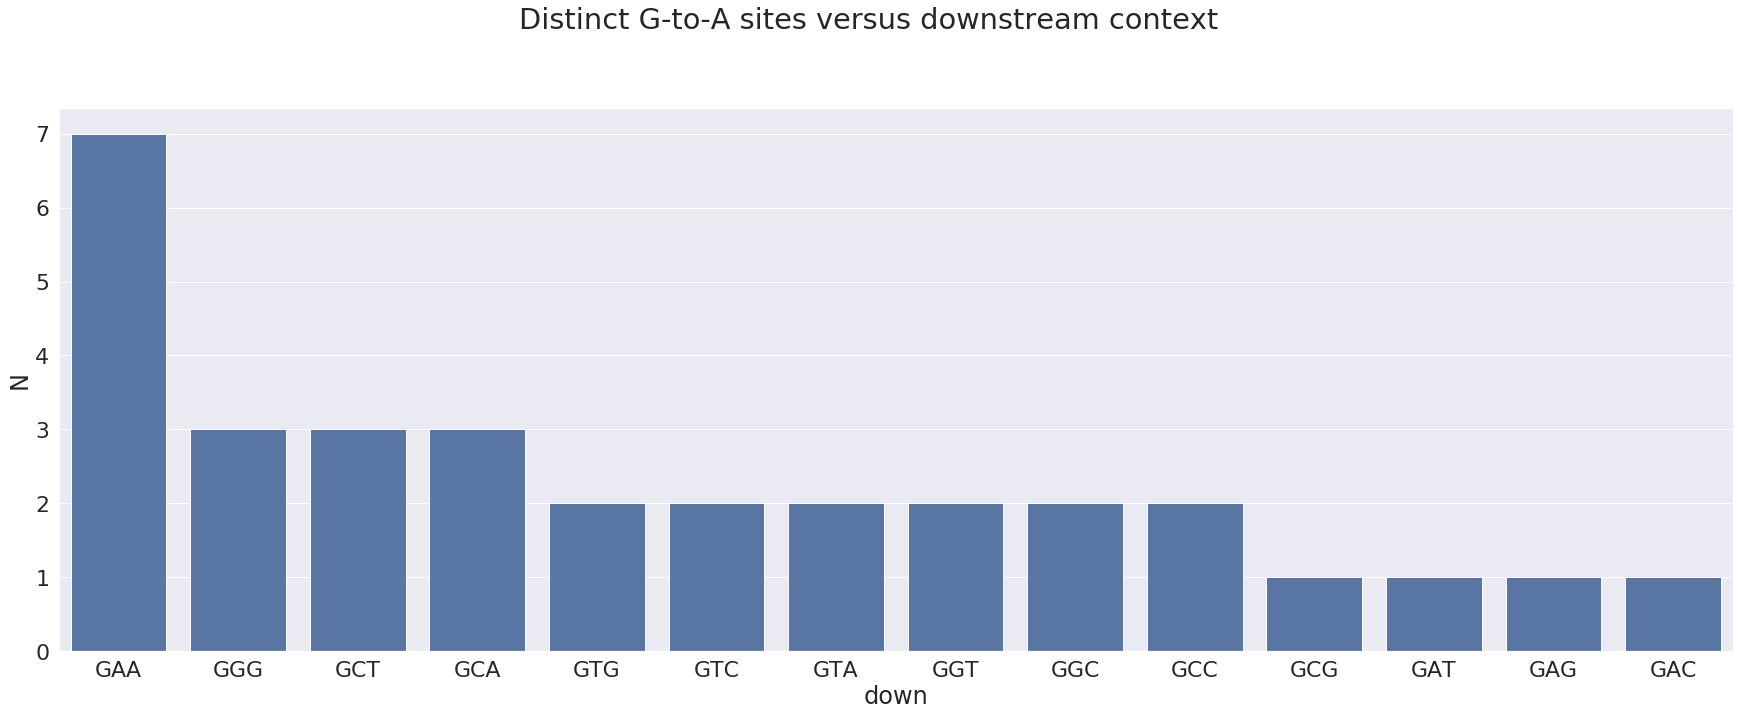

In [93]:
plt.figure(figsize=(30,10))
sns.barplot(x='down',y='N', data=pysqldf('select down, count(*) as N from ga group by down order by N desc'),color='b')
plt.suptitle('Distinct G-to-A sites versus downstream context',y=1.02)

In [94]:
print(ga[ga['N']>15].to_markdown())

|    |   POS |   N | change   | GENE   | FUNCLASS   | type        | func   | up   | down   | mid   |
|---:|------:|----:|:---------|:-------|:-----------|:------------|:-------|:-----|:-------|:------|
|  3 |  1730 |  23 | GA       | orf1ab | MISSENSE   | mat_peptide | nsp2   | TGG  | GAA    | GGA   |
| 26 | 28881 |  17 | GA       | N      | MISSENSE   | CDS         | N      | TAG  | GGG    | AGG   |
| 27 | 28882 |  17 | GA       | N      | SILENT     | CDS         | N      | AGG  | GGG    | GGG   |


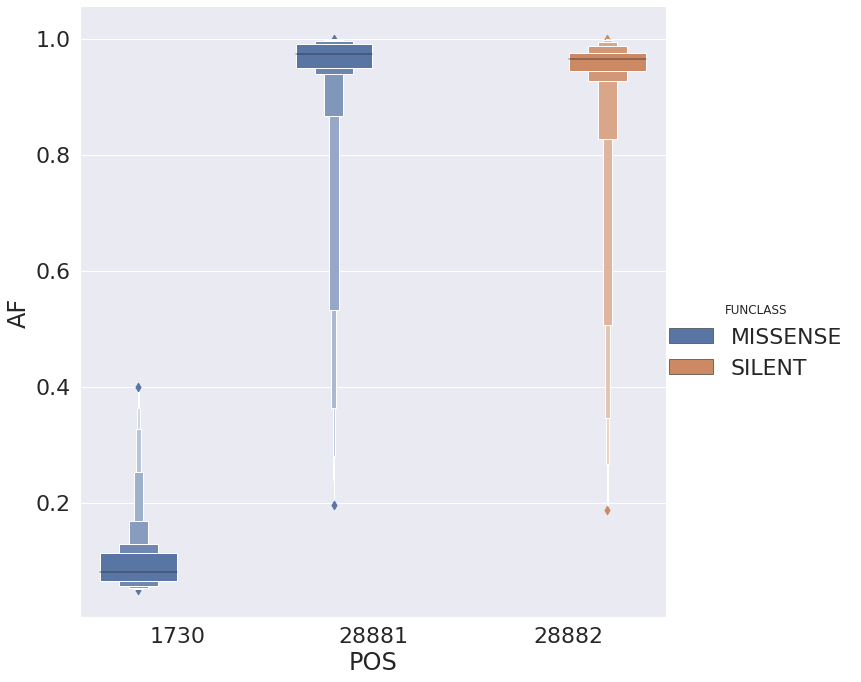

In [95]:
sns.catplot(x='POS',y='AF',height=10,kind='boxen',data=va[ ( va['POS'].isin(ga[ga['N']>15]['POS'].to_numpy()) ) & (va['change']=='GA')],hue='FUNCLASS')

In [96]:
va[ ( va['POS'].isin(ga[ga['N']>15]['POS'].to_numpy()) ) & (va['change']=='GA') & ( ( va['POS']==28882 ) | ( va['POS']==28881 ) ) ].sort_values(by=['Sample','POS'],ascending=True)

Sample    POS REF ALT     QUAL    DP        AF  SB            DP4  \
10677   ERR4082720  28881   G   A   5325.0   142  0.978873   0      0,0,71,71   
10678   ERR4082720  28882   G   A   5182.0   142  0.964789   0      0,0,71,71   
10805  SRR11491747  28881   G   A  15685.0   441  0.938776   0    0,0,206,235   
10806  SRR11491747  28882   G   A  15207.0   440  0.927273   3    0,2,205,232   
10821  SRR11508492  28881   G   A  14220.0   448  0.866071   0    0,0,223,220   
10822  SRR11508492  28882   G   A  13490.0   448  0.825893   3    0,1,224,213   
10327  SRR11517432  28881   G   A   9549.0   287  0.954704   9     7,0,180,99   
10328  SRR11517432  28882   G   A   9572.0   286  0.958042   9     7,0,179,99   
10832  SRR11563851  28881   G   A  14876.0   395  0.989873   0    0,0,177,218   
10833  SRR11563851  28882   G   A  14250.0   389  0.971722   0    0,0,172,217   
10838  SRR11605107  28881   G   A   3183.0   102  1.000000   0      0,0,44,58   
10839  SRR11605107  28882   G   A   3146.0   103  1.000000   0      0,0,44,59   
10685  SRR11607625  28881   G   A  24195.0   653  0.970904   0    0,1,299,352   
10686  SRR11607625  28882   G   A  23548.0   651  0.966206   0    0,1,298,352   
10706  SRR11621812  28881   G   A   2362.0   124  0.967742   0      0,0,55,69   
10707  SRR11621812  28882   G   A   2265.0   124  0.959677   0      0,0,56,67   
10719  SRR11621859  28881   G   A   2510.0   129  0.992248   0      0,0,62,67   
10720  SRR11621859  28882   G   A   2480.0   129  0.984496   0      0,0,62,67   
10666  SRR11652923  28881   G   A  11210.0   292  0.996575   0    0,0,126,166   
10667  SRR11652923  28882   G   A  10919.0   291  0.993127   0    1,1,124,165   
10855  SRR11676299  28881   G   A  14192.0   398  0.942211   0    0,0,186,210   
10856  SRR11676299  28882   G   A  13876.0   397  0.937028   3    0,2,186,206   
10477  SRR11728609  28881   G   A  49314.0  1395  0.974194   0    1,0,761,633   
10478  SRR11728609  28882   G   A  49314.0  1393  0.970567   3    0,1,760,630   
10571  SRR11772002  28881   G   A   2267.0   120  0.975000   0      0,0,60,60   
10572  SRR11772002  28882   G   A   2239.0   120  0.975000   0      0,0,60,60   
10576  SRR11772017  28881   G   A   2255.0   116  0.974138   0      0,0,53,63   
10577  SRR11772017  28882   G   A   2189.0   116  0.956897   0      0,0,54,62   
10626  SRR11772654  28881   G   A   7339.0   224  0.995536   0    0,0,113,111   
10627  SRR11772654  28882   G   A   7168.0   223  0.986547   0    0,0,113,110   
10629  SRR11772680  28881   G   A    463.0   102  0.196078   0     37,45,8,12   
10630  SRR11772680  28882   G   A    459.0   102  0.186275   0     38,44,8,12   
10865  SRR11801823  28881   G   A  49314.0  4842  0.948781   9  7,3,2056,2761   
10866  SRR11801823  28882   G   A  49314.0  4836  0.943342   1  3,3,2059,2756   

         IMPACT  FUNCLASS                 EFFECT GENE    CODON change  \
10677  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING    N  aGg/aAg     GA   
10678       LOW    SILENT      SYNONYMOUS_CODING    N  agG/agA     GA   
10805  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING    N  aGg/aAg     GA   
10806       LOW    SILENT      SYNONYMOUS_CODING    N  agG/agA     GA   
10821  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING    N  aGg/aAg     GA   
10822       LOW    SILENT      SYNONYMOUS_CODING    N  agG/agA     GA   
10327  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING    N  aGg/aAg     GA   
10328       LOW    SILENT      SYNONYMOUS_CODING    N  agG/agA     GA   
10832  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING    N  aGg/aAg     GA   
10833       LOW    SILENT      SYNONYMOUS_CODING    N  agG/agA     GA   
10838  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING    N  aGg/aAg     GA   
10839       LOW    SILENT      SYNONYMOUS_CODING    N  agG/agA     GA   
10685  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING    N  aGg/aAg     GA   
10686       LOW    SILENT      SYNONYMOUS_CODING    N  agG/agA     GA   
10706  MODERATE  MISSENSE  NON_SYNONYMOUS_CODING    N  aGg/aAg     GA   
10707   

In [97]:
a = pysqldf('select Sample, AF as AF1 from va where POS = 28881 and change="GA"')
b = pysqldf('select Sample, AF as AF2 from va where POS = 28882 and change="GA"')
c = pysqldf('select a.Sample, AF1, AF2, (AF1-AF2)/(AF1+AF2) as dif from a left join b on a.Sample = b.Sample')

Text(0.5, 1.02, '(AF_28881-AF_28882)/AF_28881+AF_28882)')

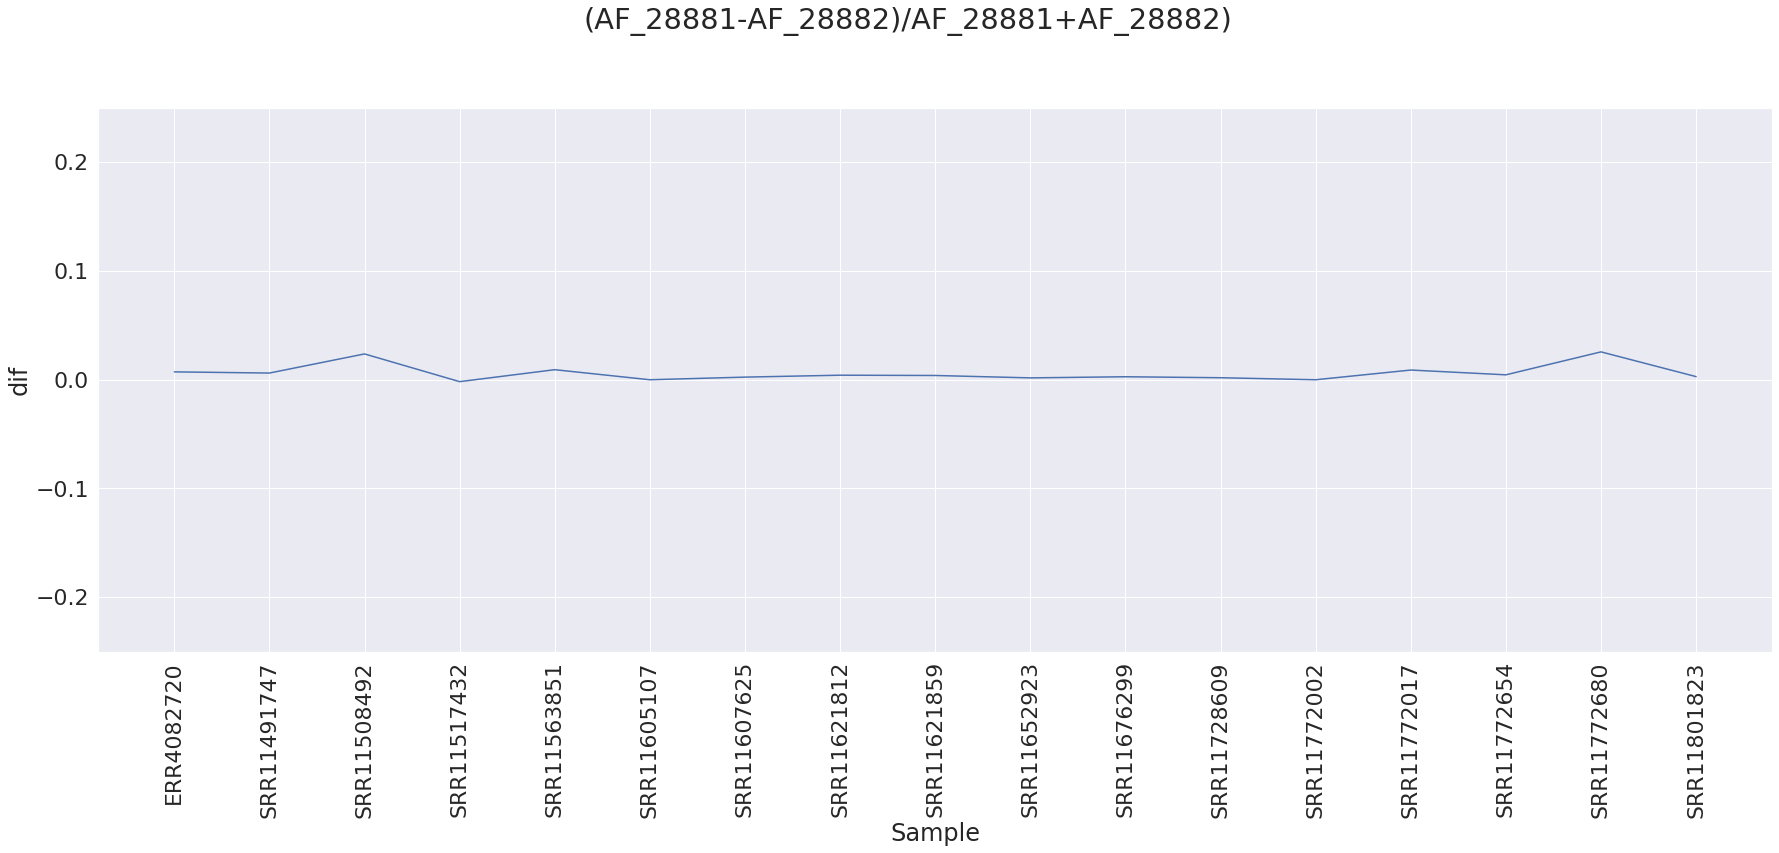

In [98]:
plt.figure(figsize=(30,10))
g = sns.lineplot(x='Sample', y='dif',data=c)
g.set(ylim=(-.25,.25))
plt.xticks(rotation=90)
plt.suptitle('(AF_28881-AF_28882)/AF_28881+AF_28882)',y=1.02)

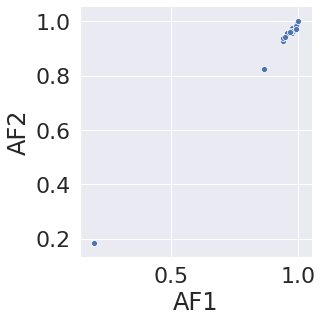

In [99]:
sns.relplot(x='AF1',y='AF2',data=c)

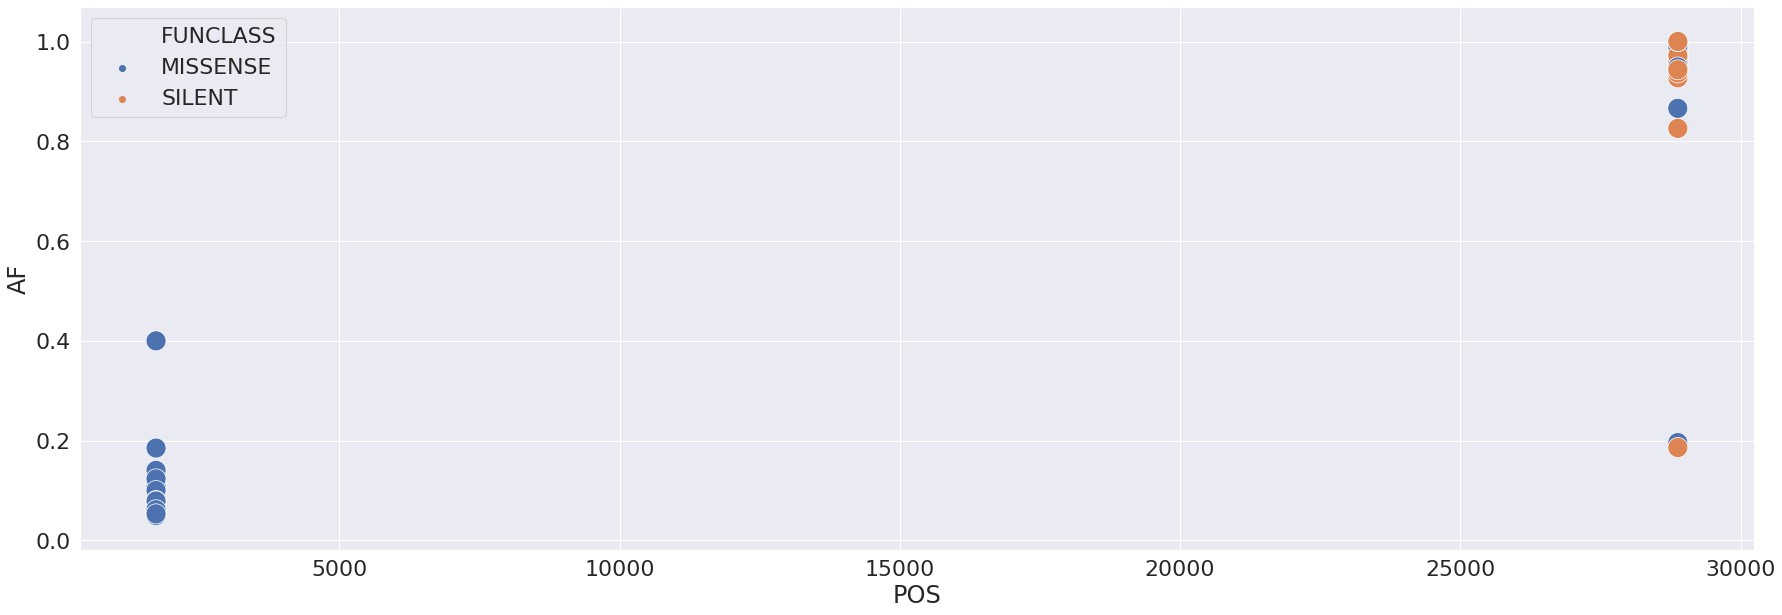

In [100]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='POS',y='AF',data=va[ ( va['POS'].isin(ga[ga['N']>15]['POS'].to_numpy()) ) & (va['change']=='GA')],s=400,hue='FUNCLASS')

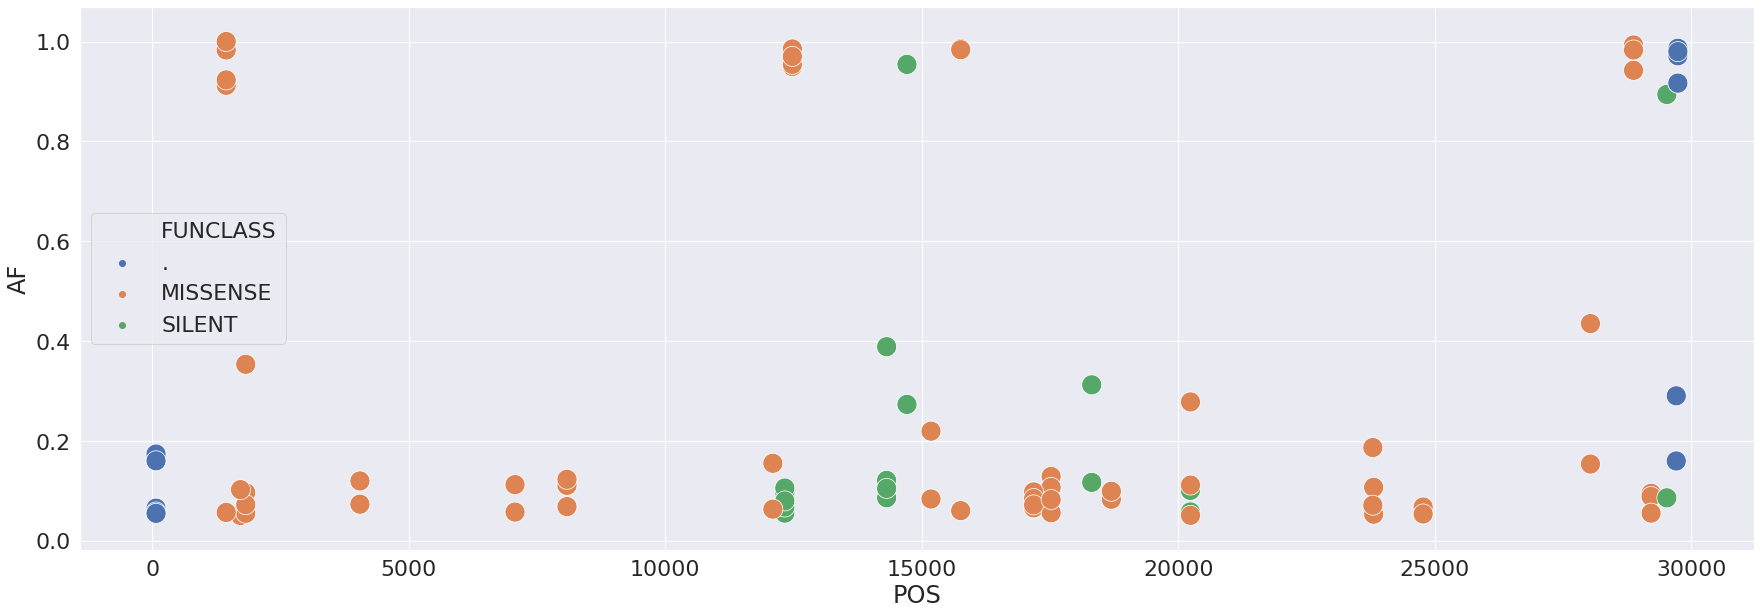

In [101]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='POS',y='AF',data=va[ ( va['POS'].isin(ga[ga['N']<=15]['POS'].to_numpy()) ) & (va['change']=='GA')],s=400,hue='FUNCLASS')

## Analysis of ADAR editing

In [102]:
ag = pysqldf('select POS, count(*) as N, change, GENE, FUNCLASS, type, func, mid,left,right from va where change = "AG" group by POS, change')
tc = pysqldf('select POS, count(*) as N, change, GENE, FUNCLASS, type, func, mid,left,right from va where change = "TC" group by POS, change')

In [103]:
ag['left-right']=ag['left']+ag['right']
tc['left-right']=tc['left']+tc['right']

In [104]:
ag

POS    N change    GENE  FUNCLASS         type      func  mid left  \
0     330    7     AG  orf1ab  MISSENSE  mat_peptide    leader  CAG    C   
1     871    2     AG  orf1ab    SILENT  mat_peptide      nsp2  AAG    A   
2    1049    2     AG  orf1ab  MISSENSE  mat_peptide      nsp2  GAA    G   
3    1637    2     AG  orf1ab  MISSENSE  mat_peptide      nsp2  GAA    G   
4    2018    5     AG  orf1ab  MISSENSE  mat_peptide      nsp2  GAT    G   
5    3337    2     AG  orf1ab    SILENT  mat_peptide      nsp3  AAG    A   
6    3942    2     AG  orf1ab  MISSENSE  mat_peptide      nsp3  AAA    A   
7    6623    2     AG  orf1ab  MISSENSE  mat_peptide      nsp3  GAA    G   
8    7448    5     AG  orf1ab  MISSENSE  mat_peptide      nsp3  GAA    G   
9    7451    2     AG  orf1ab  MISSENSE  mat_peptide      nsp3  AAG    A   
10   8031    2     AG  orf1ab  MISSENSE  mat_peptide      nsp3  AAA    A   
11   8976    2     AG  orf1ab  MISSENSE  mat_peptide      nsp4  GAG    G   
12  10066    3     AG  orf1ab    SILENT  mat_peptide     3Cpro  GAA    G   
13  10699    2     AG  orf1ab    SILENT  mat_peptide     3Cpro  GAG    G   
14  11425    2     AG  orf1ab    SILENT  mat_peptide      nsp6  AAG    A   
15  11991    4     AG  orf1ab  MISSENSE  mat_peptide      nsp7  GAA    G   
16  12764    2     AG  orf1ab  MISSENSE  mat_peptide      nsp9  CAA    C   
17  13512    9     AG  orf1ab    SILENT  mat_peptide      RdRp  CAG    C   
18  13623    2     AG  orf1ab    SILENT  mat_peptide      RdRp  AAG    A   
19  13940    3     AG  orf1ab  MISSENSE  mat_peptide      RdRp  GAA    G   
20  14413    3     AG  orf1ab  MISSENSE  mat_peptide      RdRp  AAG    A   
21  14912    2     AG  orf1ab  MISSENSE  mat_peptide      RdRp  AAC    A   
22  16620    2     AG  orf1ab    SILENT  mat_peptide  helicase  AAA    A   
23  17858   93     AG  orf1ab  MISSENSE  mat_peptide  helicase  TAT    T   
24  18009    2     AG  orf1ab    SILENT  mat_peptide  helicase  AAA    A   
25  20236    2     AG  orf1ab  MISSENSE  mat_peptide     endoR  CAG    C   
26  20268    6     AG  orf1ab    SILENT  mat_peptide     endoR  TAG    T   
27  20667    4     AG  orf1ab    SILENT  mat_peptide    MethTr  AAG    A   
28  22003    4     AG       S    SILENT          CDS         S  AAA    A   
29  22011    4     AG       S  MISSENSE          CDS         S  AAA    A   
30  23403  482     AG       S  MISSENSE          CDS         S  GAT    G   
31  23670    2     AG       S  MISSENSE          CDS         S  AAT    A   
32  23687    3     AG       S  MISSENSE          CDS         S  TAA    T   
33  23736    2     AG       S  MISSENSE          CDS         S  GAA    G   
34  24325    2     AG       S    SILENT          CDS         S  AAT    A   
35  25136    2     AG       S  MISSENSE          CDS         S  GAA    G   
36  25369    2     AG       S    SILENT          CDS         S  AAT    A   
37  25432    2     AG   ORF3a  MISSENSE          CDS     orf3a  AAC    A   
38  25450    2     AG   ORF3a  MISSENSE          CDS     orf3a  AAT    A   
39  27354   12     AG    ORF6    SILENT          CDS      orf6  AAT    A   
40  28316    6     AG       N  MISSENSE          CDS         N  CAT    C   
41  29031    2     AG       N  MISSENSE          CDS         N  GAG    G   
42  29188   34     AG       N    SILENT          CDS         N  CAC    C   
43  29700    7     AG       .         .        3'UTR         .  TAG    T   

   right left-right  
0      G         CG  
1      G         AG  
2      A         GA  
3      A         GA  
4      T         GT  
5      G         AG  
6      A         AA  
7      A         GA  
8      A         GA  
9      G         AG  
10     A         AA  
11     G         GG  
12     A         GA  
13     G         GG  
14     G         AG  
15     A         GA  
16     A         CA  
17     G         CG  
18     G         AG  
19     A         GA  
20     G         AG  
21     C         AC  
22     A         AA  
23     T         TT  
24     A         AA  
25     G     

In [105]:
pysqldf('select "left-right",count(*) as N from ag group by "left-right" order by N desc')["left-right"].to_numpy()

array(['GA', 'AG', 'AA', 'AT', 'GG', 'CG', 'TG', 'GT', 'AC', 'TT', 'TA',
       'CT', 'CC', 'CA'], dtype=object)

Text(0.5, 0.98, 'Number of Samples with a given A->G substitution vs. context')

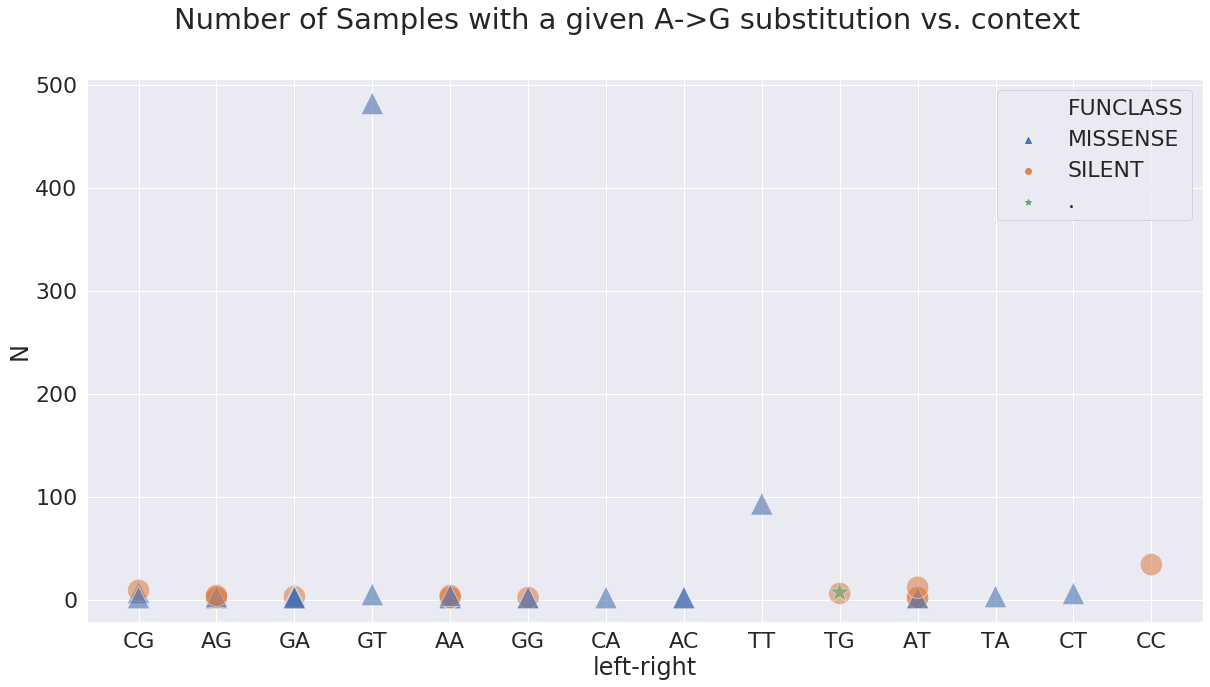

In [106]:
sns.set(font_scale=2)
plt.figure(figsize=(20,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.scatterplot(x='left-right',y='N',s=500,data=ag,alpha=0.6,style='FUNCLASS',hue='FUNCLASS',markers=markers)
#plt.yscale('log')
plt.suptitle('Number of Samples with a given A->G substitution vs. context')

Text(0.5, 1.02, 'Distinct A->G sites vs. -1/+1 context')

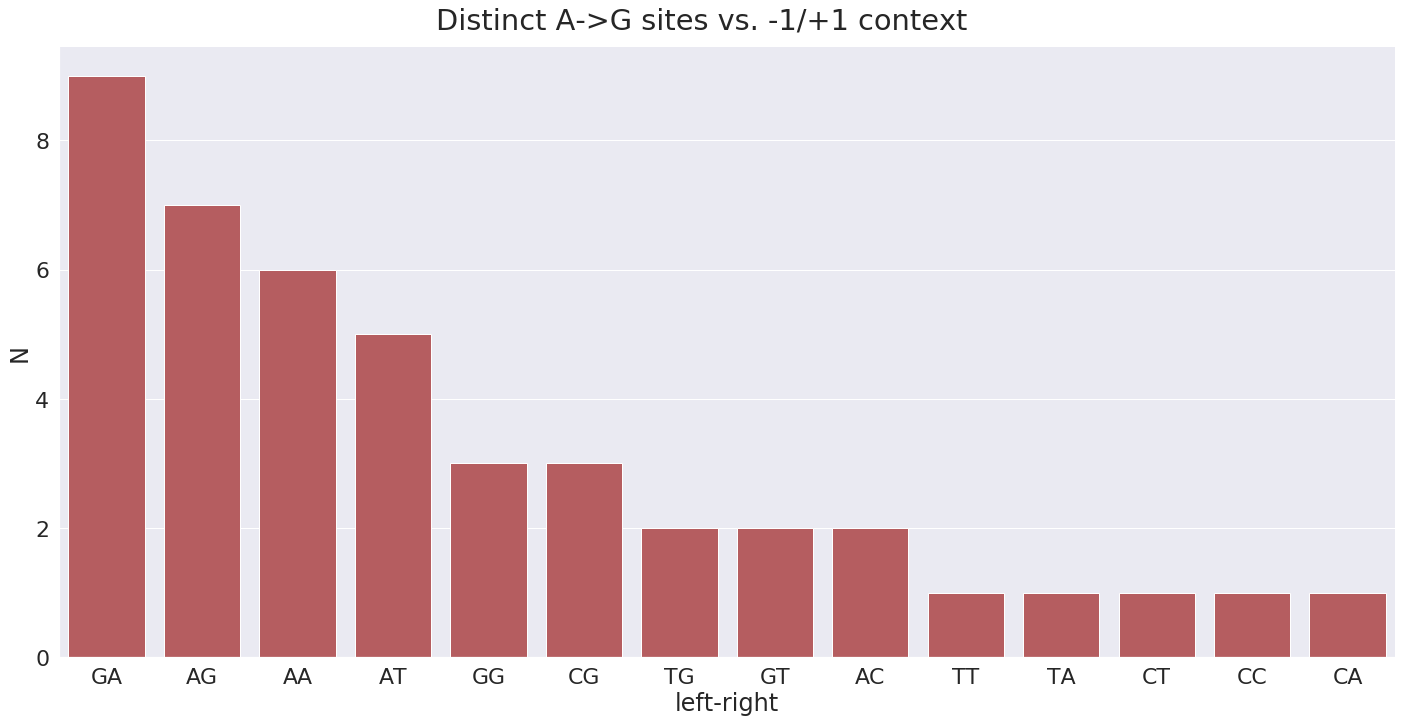

In [107]:
sns.catplot(x='left-right',y='N',kind='bar',data=pysqldf('select "left-right", count(*) as N from ag group by "left-right" order by N desc'),height=10,aspect=2,color='r')
plt.suptitle('Distinct A->G sites vs. -1/+1 context',y=1.02)

In [108]:
print(ag[ag['N']>80].to_markdown())

|    |   POS |   N | change   | GENE   | FUNCLASS   | type        | func     | mid   | left   | right   | left-right   |
|---:|------:|----:|:---------|:-------|:-----------|:------------|:---------|:------|:-------|:--------|:-------------|
| 23 | 17858 |  93 | AG       | orf1ab | MISSENSE   | mat_peptide | helicase | TAT   | T      | T       | TT           |
| 30 | 23403 | 482 | AG       | S      | MISSENSE   | CDS         | S        | GAT   | G      | T       | GT           |


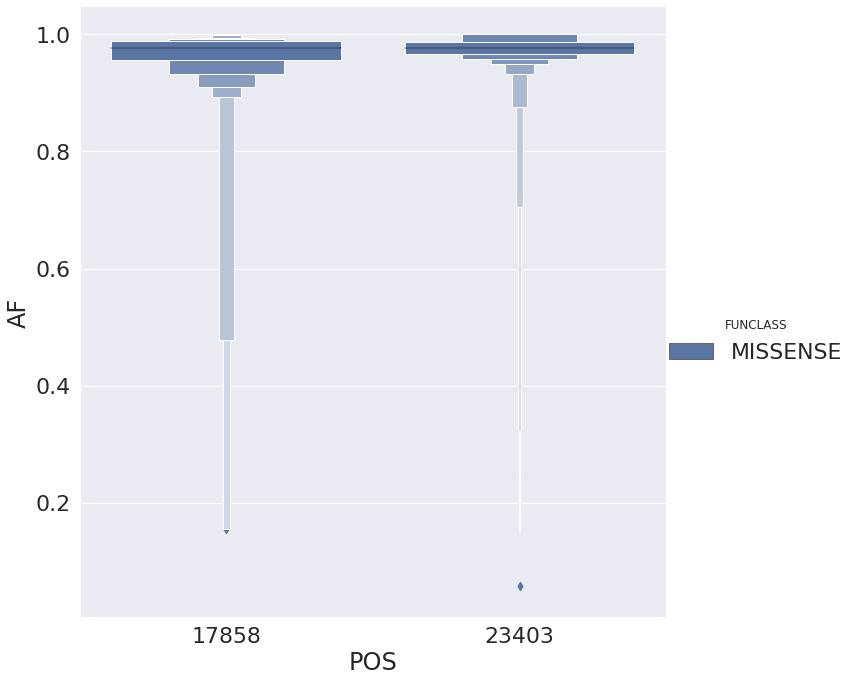

In [109]:
sns.catplot(x='POS',y='AF',height=10,kind='boxen',data=va[ ( va['POS'].isin(ag[ag['N']>80]['POS'].to_numpy()) ) & (va['change']=='AG')],hue='FUNCLASS')

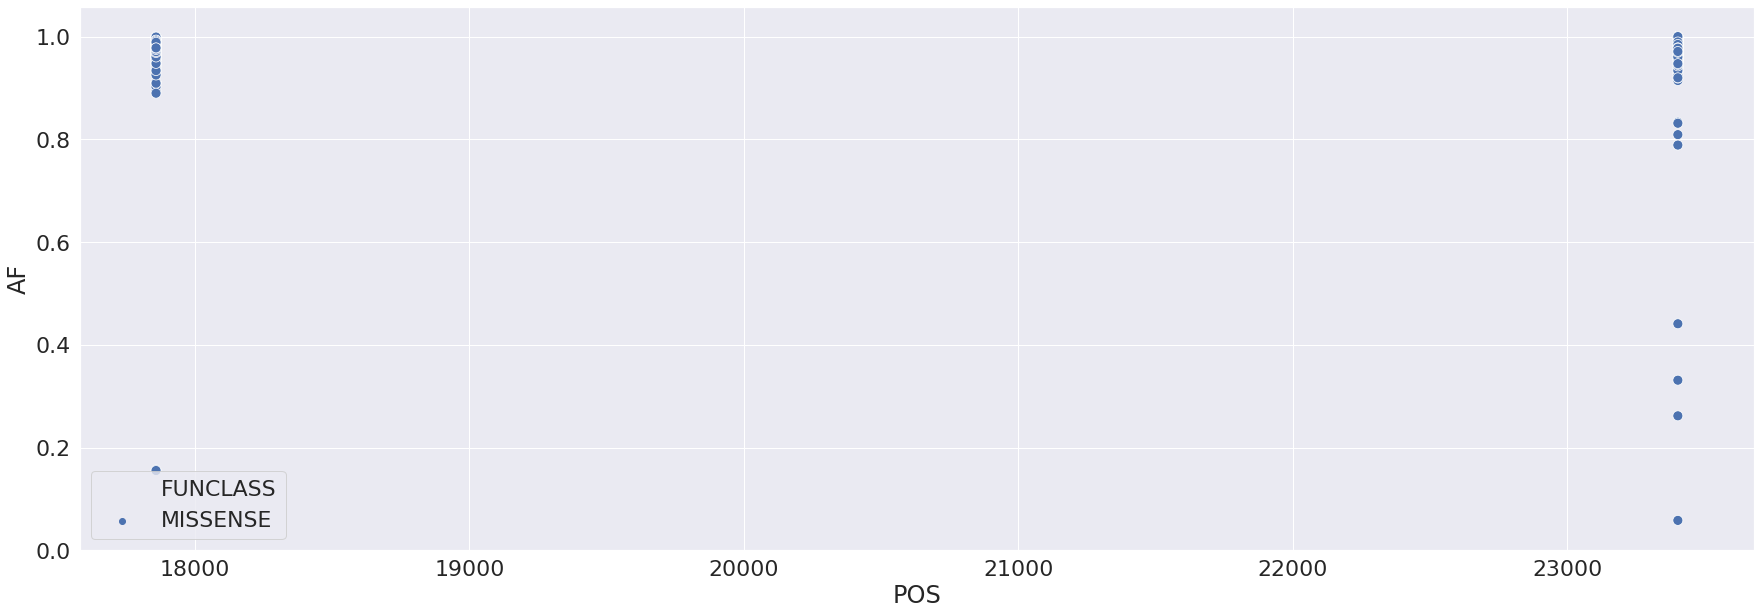

In [110]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='POS',y='AF',data=va[ ( va['POS'].isin(ag[ag['N']>80]['POS'].to_numpy()) ) & (va['change']=='AG')],s=100,hue='FUNCLASS')

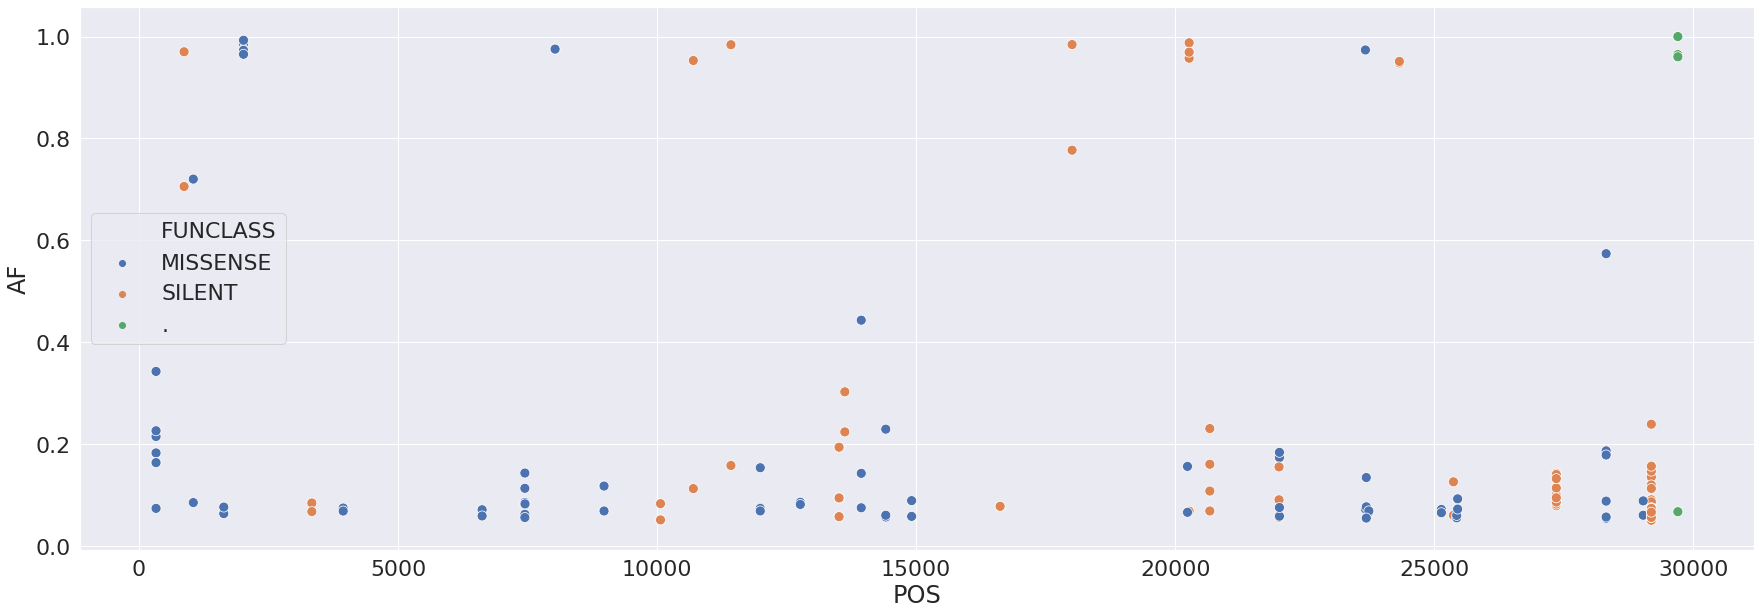

In [111]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='POS',y='AF',data=va[ ( va['POS'].isin(ag[ag['N']<80]['POS'].to_numpy()) ) & (va['change']=='AG')],s=100,hue='FUNCLASS')

Text(0.5, 0.98, 'Number of Samples with a given T->C substitution vs. context')

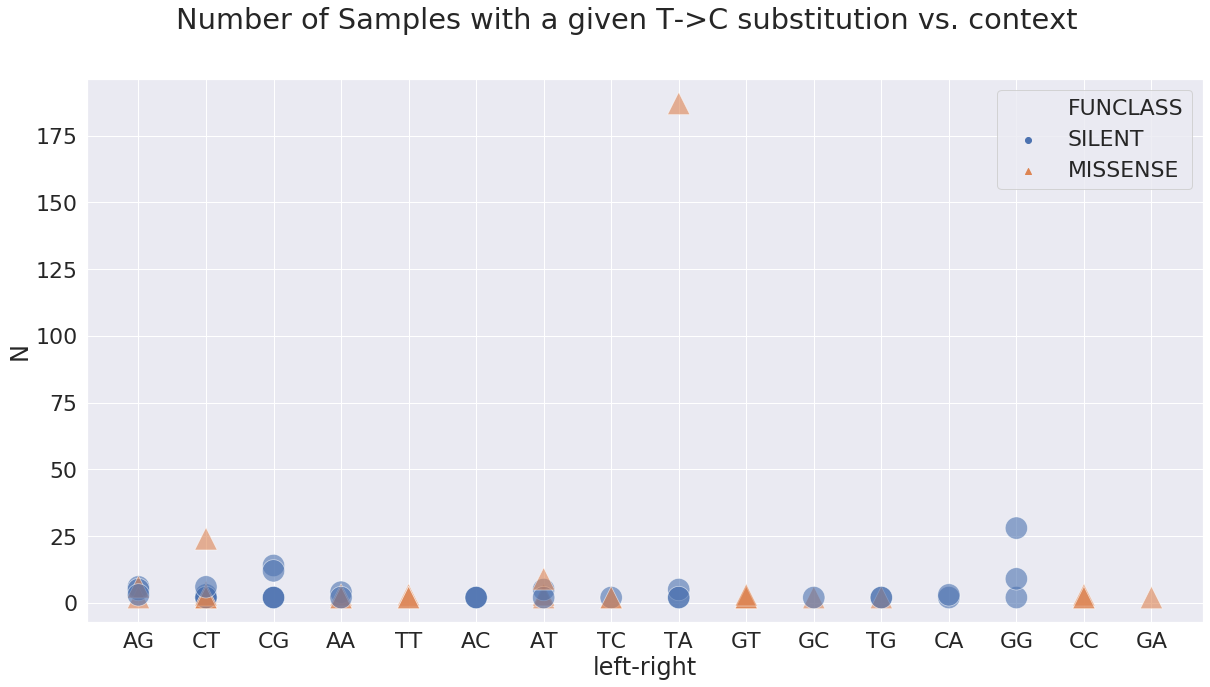

In [112]:
sns.set(font_scale=2)
plt.figure(figsize=(20,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.scatterplot(x='left-right',y='N',s=500,data=tc,alpha=0.6,style='FUNCLASS',hue='FUNCLASS',markers=markers)
#plt.yscale('log')
plt.suptitle('Number of Samples with a given T->C substitution vs. context')

Text(0.5, 1.02, 'Distinct T->C sites vs. context')

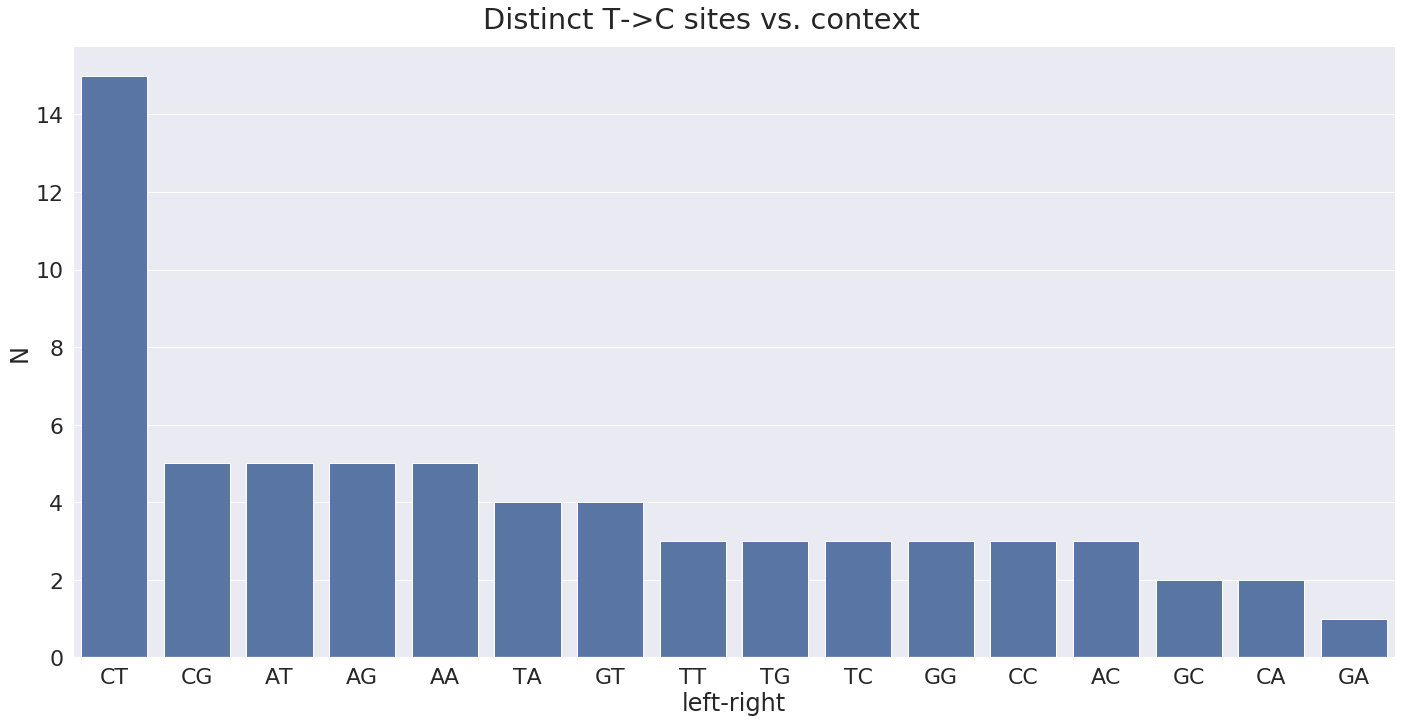

In [113]:
sns.catplot(x='left-right',y='N',kind='bar',data=pysqldf('select "left-right", count(*) as N from tc group by "left-right" order by N desc'),height=10,aspect=2,color='b')
plt.suptitle('Distinct T->C sites vs. context',y=1.02)

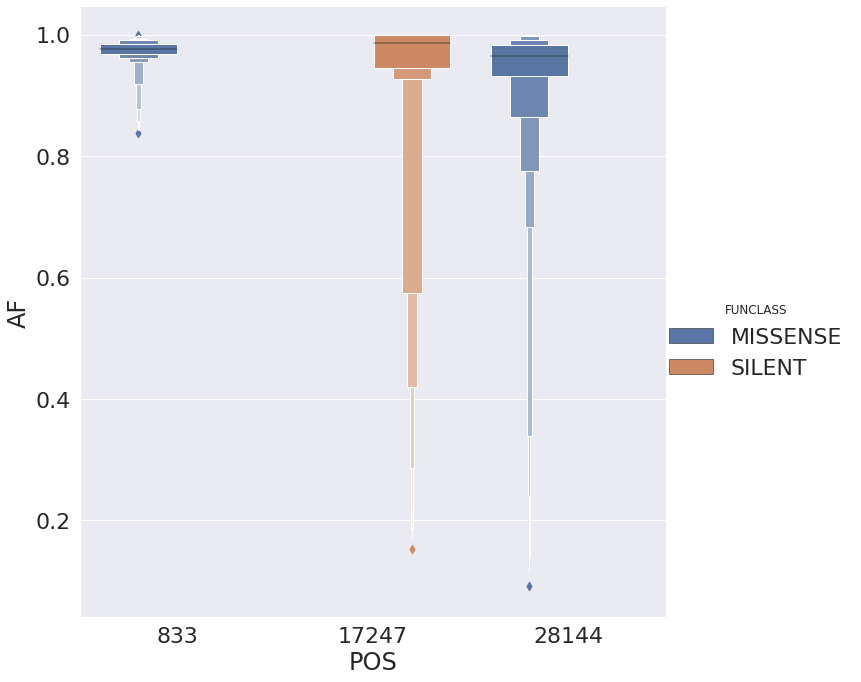

In [114]:
sns.catplot(x='POS',y='AF',height=10,kind='boxen',data=va[ ( va['POS'].isin(tc[tc['N']>20]['POS'].to_numpy()) ) & (va['change']=='TC')],hue='FUNCLASS')

In [115]:
print(tc[tc['N']>20].to_markdown())

|    |   POS |   N | change   | GENE   | FUNCLASS   | type        | func     | mid   | left   | right   | left-right   |
|---:|------:|----:|:---------|:-------|:-----------|:------------|:---------|:------|:-------|:--------|:-------------|
|  1 |   833 |  24 | TC       | orf1ab | MISSENSE   | mat_peptide | nsp2     | CTT   | C      | T       | CT           |
| 41 | 17247 |  28 | TC       | orf1ab | SILENT     | mat_peptide | helicase | GTG   | G      | G       | GG           |
| 61 | 28144 | 187 | TC       | ORF8   | MISSENSE   | CDS         | orf8     | TTA   | T      | A       | TA           |


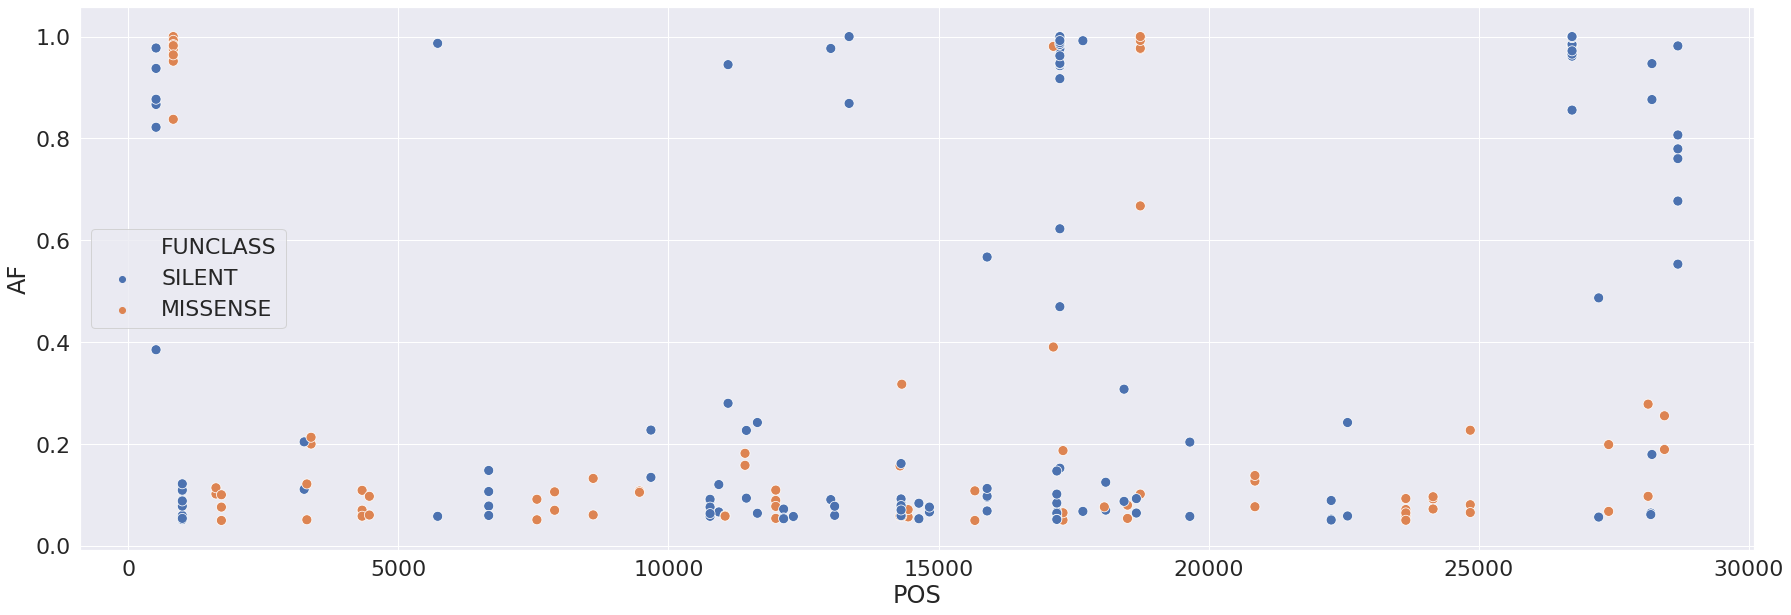

In [116]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='POS',y='AF',data=va[  ( va['POS'].isin(tc[tc['N']<100]['POS'].to_numpy()) ) & (va['change']=='TC')],s=100,hue='FUNCLASS')

In [117]:
pysqldf('select count(POS) from va where Studies > 1 ')

count(POS)
0        5130

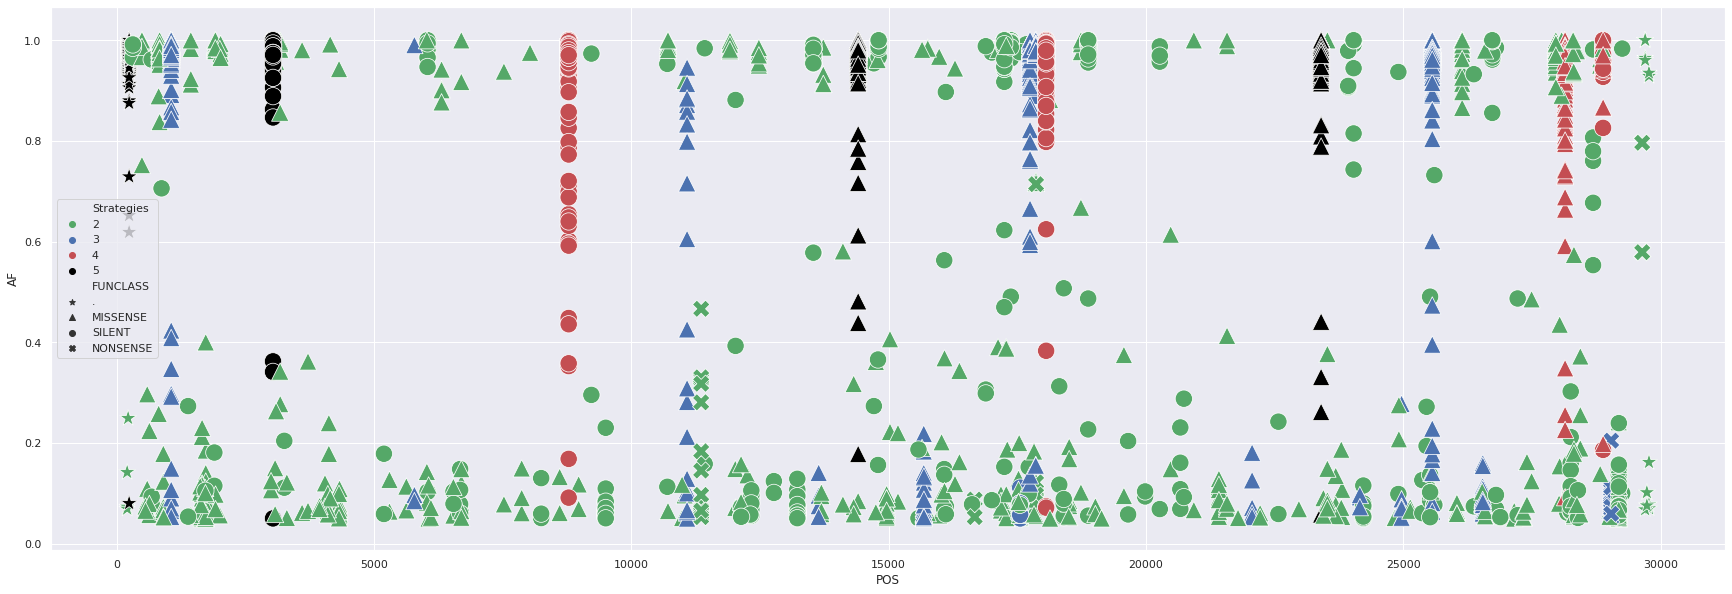

In [118]:
sns.set(font_scale=1)
plt.figure(figsize=(30,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.scatterplot(x='POS',y='AF',data=va[va['Strategies']>=2],hue='Strategies',markers=markers,style='FUNCLASS',s=300,palette={2:'g',3:'b',4:'r',5:'black'})

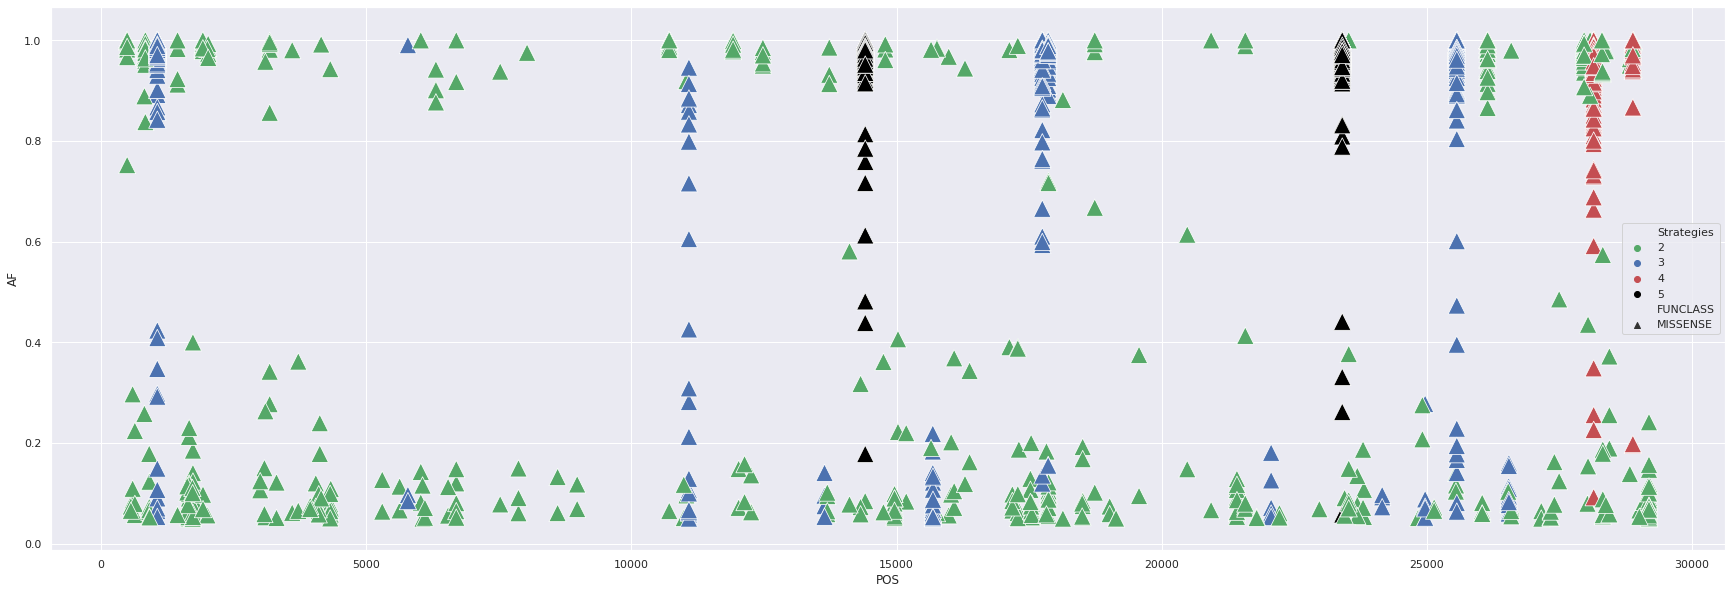

In [119]:
sns.set(font_scale=1)
plt.figure(figsize=(30,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.scatterplot(x='POS',y='AF',data=va[(va['Strategies']>=2) & (va['FUNCLASS']=='MISSENSE')],hue='Strategies',markers=markers,style='FUNCLASS',s=300,palette={2:'g',3:'b',4:'r',5:'black'})

In [120]:
pysqldf('select POS, change,FUNCLASS,IMPACT,GENE,CODON,type,func,Samples, Studies, Strategies, min(AF) as min,max(AF) as max,avg(AF) as mean from va where Strategies>=2 and FUNCLASS = "MISSENSE" group by pos,change order by max-min desc')

POS change  FUNCLASS    IMPACT    GENE    CODON         type      func  \
0     6696     CT  MISSENSE  MODERATE  orf1ab  cCt/cTt  mat_peptide      nsp3   
1     1059     CT  MISSENSE  MODERATE  orf1ab  aCc/aTc  mat_peptide      nsp2   
2     1440     GA  MISSENSE  MODERATE  orf1ab  gGc/gAc  mat_peptide      nsp2   
3    23403     AG  MISSENSE  MODERATE       S  gAt/gGt          CDS         S   
4    17285     CT  MISSENSE  MODERATE  orf1ab  tCa/tTa  mat_peptide  helicase   
5    25563     GT  MISSENSE  MODERATE   ORF3a  caG/caT          CDS     orf3a   
6    10712     CT  MISSENSE  MODERATE  orf1ab  Ctc/Ttc  mat_peptide     3Cpro   
7    20930     CT  MISSENSE  MODERATE  orf1ab  aCg/aTg  mat_peptide    MethTr   
8    21575     CT  MISSENSE  MODERATE       S  Ctt/Ttt          CDS         S   
9    23525     CT  MISSENSE  MODERATE       S  Cat/Tat          CDS         S   
10    2003     CT  MISSENSE  MODERATE  orf1ab  Ctc/Ttc  mat_peptide      nsp2   
11   26589     GT  MISSENSE  MODERATE       M  Gta/Tta          CDS         M   
12   15760     GA  MISSENSE  MODERATE  orf1ab  Ggt/Agt  mat_peptide      RdRp   
13    3602     CT  MISSENSE  MODERATE  orf1ab  Cac/Tac  mat_peptide      nsp3   
14    6027     CT  MISSENSE  MODERATE  orf1ab  cCa/cTa  mat_peptide      nsp3   
15    4148     GT  MISSENSE  MODERATE  orf1ab  Gtt/Ttt  mat_peptide      nsp3   
16   15982     GT  MISSENSE  MODERATE  orf1ab  Gta/Tta  mat_peptide      RdRp   
17   28144     TC  MISSENSE  MODERATE    ORF8  tTa/tCa          CDS      orf8   
18    5784     CT  MISSENSE  MODERATE  orf1ab  aCt/aTt  mat_peptide      nsp3   
19    3096     CT  MISSENSE  MODERATE  orf1ab  tCa/tTa  mat_peptide      nsp3   
20   28374     GT  MISSENSE  MODERATE       N  gGg/gTg          CDS         N   
21   18736     TC  MISSENSE  MODERATE  orf1ab  Ttt/Ctt  mat_peptide      ExoN   
22   11083     GT  MISSENSE  MODERATE  orf1ab  ttG/ttT  mat_peptide      nsp6   
23   17747     CT  MISSENSE  MODERATE  orf1ab  cCt/cTt  mat_peptide  helicase   
24   14407     CT  MISSENSE  MODERATE  orf1ab  Cct/Tct  mat_peptide      RdRp   
25   28027     GC  MISSENSE  MODERATE    ORF8  tGg/tCg          CDS      orf8   
26    4320     CT  MISSENSE  MODERATE  orf1ab  gCc/gTc  mat_peptide      nsp3   
27    7524     GT  MISSENSE  MODERATE  orf1ab  aGa/aTa  mat_peptide      nsp3   
28   25549     CT  MISSENSE  MODERATE   ORF3a  Ctt/Ttt          CDS     orf3a   
29   17858     AG  MISSENSE  MODERATE  orf1ab  tAt/tGt  mat_peptide  helicase   
30   18135     AT  MISSENSE  MODERATE  orf1ab  aaA/aaT  mat_peptide      ExoN   
31   16289     CT  MISSENSE  MODERATE  orf1ab  gCt/gTt  mat_peptide  helicase   
32   28826     CT  MISSENSE  MODERATE       N  Cgt/Tgt          CDS         N   
33   11036     CT  MISSENSE  MODERATE  orf1ab  Ctt/Ttt  mat_peptide      nsp6   
34   14408     CT  MISSENSE  MODERATE  orf1ab  cCt/cTt  mat_peptide      RdRp   
35   28881     GA  MISSENSE  MODERATE       N  aGg/aAg          CDS         N   
36   28883     GC  MISSENSE  MODERATE       N  Gga/Cga          CDS         N   
37   15649     GT  MISSENSE  MODERATE  orf1ab  Gtt/Ttt  mat_peptide      RdRp   
38    3177     CT  MISSENSE  MODERATE  orf1ab  cCt/cTt  mat_peptide      nsp3   
39   17863     TA  MISSENSE  MODERATE  orf1ab  Tat/Aat  mat_peptide  helicase   
40   17864     AT  MISSENSE  MODERATE  orf1ab  tAt/tTt  mat_peptide  helicase   
41     815     CT  MISSENSE  MODERATE  orf1ab  Cgc/Tgc  mat_peptide      nsp2   
42   17126     TC  MISSENSE  MODERATE  orf1ab  cTc/cCc  mat_peptide  helicase   
43   28316     AG  MISSENSE  MODERATE       N  Att/Gtt          CDS         N   
44   14111     AC  MISSENSE  MODERATE  orf1ab  cAa/cCa  mat_peptide      RdRp   
45   20480     CT  MISSENSE  MODERATE  orf1ab  tCa/tTa  mat_peptide     endoR   
46   27493     CT  MISSENSE  MODERATE   ORF7a  Cct/Tct          CDS     orf7a   
47    1730     GA  MISSENSE  MODERATE  orf1ab  Gaa/Aaa  mat_peptide      nsp2   
48   28440     TA  MISSENSE  MODERATE 

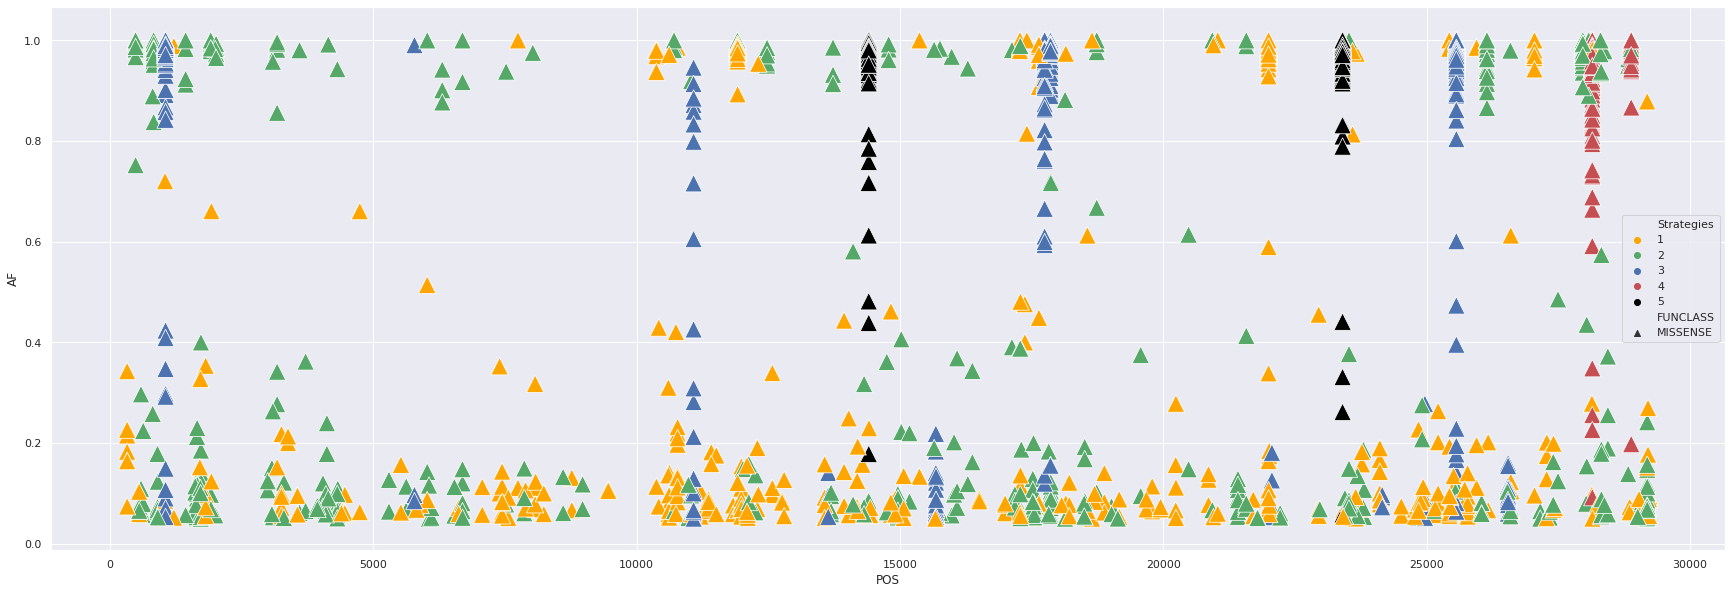

In [121]:
sns.set(font_scale=1)
plt.figure(figsize=(30,10))
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.scatterplot(x='POS',y='AF',data=va[(va['Studies']>=2) & (va['FUNCLASS']=='MISSENSE')],hue='Strategies',markers=markers,style='FUNCLASS',s=300,palette={1:'orange',2:'g',3:'b',4:'r',5:'black'})

In [122]:
va['library_strategy'].unique()

array(['RNA-Seq', 'AMPLICON', 'Targeted-Capture', 'WGS', 'OTHER'],
      dtype=object)

## Interesting sites

In [123]:
pysqldf('select * from va limit10 ')

Sample    POS REF ALT     QUAL    DP        AF  SB             DP4  \
0     SRR11517432    241   C   T   9603.0   291  0.958763   0     0,0,147,140   
1     SRR11676316    241   C   T  28423.0   834  0.962830   0     0,0,362,472   
2     SRR11728606    241   C   T  34744.0   985  0.984772   0     0,0,430,554   
3     SRR11728607    241   C   T  49314.0  1765  0.981303   0     1,1,803,959   
4     SRR11728608    241   C   T  49314.0  1644  0.989051   0     0,1,721,921   
...           ...    ...  ..  ..      ...   ...       ...  ..             ...   
5125  SRR11728647  13536   C   T  49314.0  2753  0.963676   7  25,31,960,1736   
5126  SRR11728648  13536   C   T  49314.0  2419  0.990905   0    0,1,892,1526   
5127  SRR11621877  13536   C   T   3423.0   105  0.971429   0       0,0,58,47   
5128  SRR11676288  13536   C   T  47807.0  1296  0.983025   0     0,1,371,923   
5129  SRR11676289  13536   C   T  49314.0  1638  0.954212   2  15,31,443,1149   

     IMPACT FUNCLASS             EFFECT    GENE    CODON change  \
0         .        .                  .       .        .     CT   
1         .        .                  .       .        .     CT   
2         .        .                  .       .        .     CT   
3         .        .                  .       .        .     CT   
4         .        .                  .       .        .     CT   
...     ...      ...                ...     ...      ...    ...   
5125    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   
5126    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   
5127    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   
5128    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   
5129    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   

     study_accession library_strategy      library_source library_selection  \
0          SRP255853          RNA-Seq  METATRANSCRIPTOMIC            RANDOM   
1          SRP253926         AMPLICON           VIRAL RNA               PCR   
2          SRP253926         AMPLICON           VIRAL RNA               PCR   
3          SRP253926         AMPLICON           VIRAL RNA               PCR   
4          SRP253926         AMPLICON           VIRAL RNA               PCR   
...              ...              ...                 ...               ...   
5125       SRP253926         AMPLICON           VIRAL RNA               PCR   
5126       SRP253926         AMPLICON           VIRAL RNA               PCR   
5127       SRP251618          RNA-Seq           VIRAL RNA       unspecified   
5128       SRP253926         AMPLICON           VIRAL RNA               PCR   
5129       SRP253926         AMPLICON           VIRAL RNA               PCR   

     collection_date geo_loc_name   type func  start    end   A   C   G   T  \
0        19-MAR-2020      Germany  5'UTR    .      0    265  67  63  55  80   
1               None         None  5'UTR    .      0    265  67  63  55  80   
2               None         None  5'UTR    .      0    265  67  63  55  80   
3               None         None  5'UTR    .      0    265  67  63  55  80   
4               None         None  5'UTR    .      0    265  67  63  55  80   
...              ...          ...    ...  ...    ...    ...  ..  ..  ..  ..   
5125            None         None   stem  S2b  13535  13542   1   2   3   1   
5126            None         None   stem  S2b  13535  13542   1   2   3   1   
5127         missing          USA   stem  S2b  13535  13542   1   2   3   1   
5128            None         None   stem  S2b  13535  13542   1   2   3   1   
5129            None         None   stem  S2b  13535  13542   1   2   3   1   

      Samples  Studies  Strategies   up down  mid left right  
0         413       12           5  TTC  CGT  TCG    T     G  
1         413       12           5  TTC  CGT  TCG    T     G  
2         413       12           5  TTC  CGT  TCG    T     G  
3         413       12           5  TTC  CGT  TCG    T     G  
4         413       

In [124]:
a = pysqldf('select POS, change, min(AF) as minAF, max(AF) as maxAF from va group by POS, change')
va = pysqldf('select va.*, minAF, maxAF, maxAF-minAF as rangeAF from va left join a on va.POS = a.POS and va.change = a.change')

In [125]:
va

Sample    POS REF ALT     QUAL    DP        AF  SB             DP4  \
0     SRR11517432    241   C   T   9603.0   291  0.958763   0     0,0,147,140   
1     SRR11676316    241   C   T  28423.0   834  0.962830   0     0,0,362,472   
2     SRR11728606    241   C   T  34744.0   985  0.984772   0     0,0,430,554   
3     SRR11728607    241   C   T  49314.0  1765  0.981303   0     1,1,803,959   
4     SRR11728608    241   C   T  49314.0  1644  0.989051   0     0,1,721,921   
...           ...    ...  ..  ..      ...   ...       ...  ..             ...   
5125  SRR11728647  13536   C   T  49314.0  2753  0.963676   7  25,31,960,1736   
5126  SRR11728648  13536   C   T  49314.0  2419  0.990905   0    0,1,892,1526   
5127  SRR11621877  13536   C   T   3423.0   105  0.971429   0       0,0,58,47   
5128  SRR11676288  13536   C   T  47807.0  1296  0.983025   0     0,1,371,923   
5129  SRR11676289  13536   C   T  49314.0  1638  0.954212   2  15,31,443,1149   

     IMPACT FUNCLASS             EFFECT    GENE    CODON change  \
0         .        .                  .       .        .     CT   
1         .        .                  .       .        .     CT   
2         .        .                  .       .        .     CT   
3         .        .                  .       .        .     CT   
4         .        .                  .       .        .     CT   
...     ...      ...                ...     ...      ...    ...   
5125    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   
5126    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   
5127    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   
5128    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   
5129    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   

     study_accession library_strategy      library_source library_selection  \
0          SRP255853          RNA-Seq  METATRANSCRIPTOMIC            RANDOM   
1          SRP253926         AMPLICON           VIRAL RNA               PCR   
2          SRP253926         AMPLICON           VIRAL RNA               PCR   
3          SRP253926         AMPLICON           VIRAL RNA               PCR   
4          SRP253926         AMPLICON           VIRAL RNA               PCR   
...              ...              ...                 ...               ...   
5125       SRP253926         AMPLICON           VIRAL RNA               PCR   
5126       SRP253926         AMPLICON           VIRAL RNA               PCR   
5127       SRP251618          RNA-Seq           VIRAL RNA       unspecified   
5128       SRP253926         AMPLICON           VIRAL RNA               PCR   
5129       SRP253926         AMPLICON           VIRAL RNA               PCR   

     collection_date geo_loc_name   type func  start    end   A   C   G   T  \
0        19-MAR-2020      Germany  5'UTR    .      0    265  67  63  55  80   
1               None         None  5'UTR    .      0    265  67  63  55  80   
2               None         None  5'UTR    .      0    265  67  63  55  80   
3               None         None  5'UTR    .      0    265  67  63  55  80   
4               None         None  5'UTR    .      0    265  67  63  55  80   
...              ...          ...    ...  ...    ...    ...  ..  ..  ..  ..   
5125            None         None   stem  S2b  13535  13542   1   2   3   1   
5126            None         None   stem  S2b  13535  13542   1   2   3   1   
5127         missing          USA   stem  S2b  13535  13542   1   2   3   1   
5128            None         None   stem  S2b  13535  13542   1   2   3   1   
5129            None         None   stem  S2b  13535  13542   1   2   3   1   

      Samples  Studies  Strategies   up down  mid left right     minAF  \
0         413       12           5  TTC  CGT  TCG    T     G  0.080000   
1         413       12           5  TTC  CGT  TCG    T     G  0.080000   
2         413       12           5  TTC  CGT  TCG    T     G  0.080000   
3         413       12           5  TTC

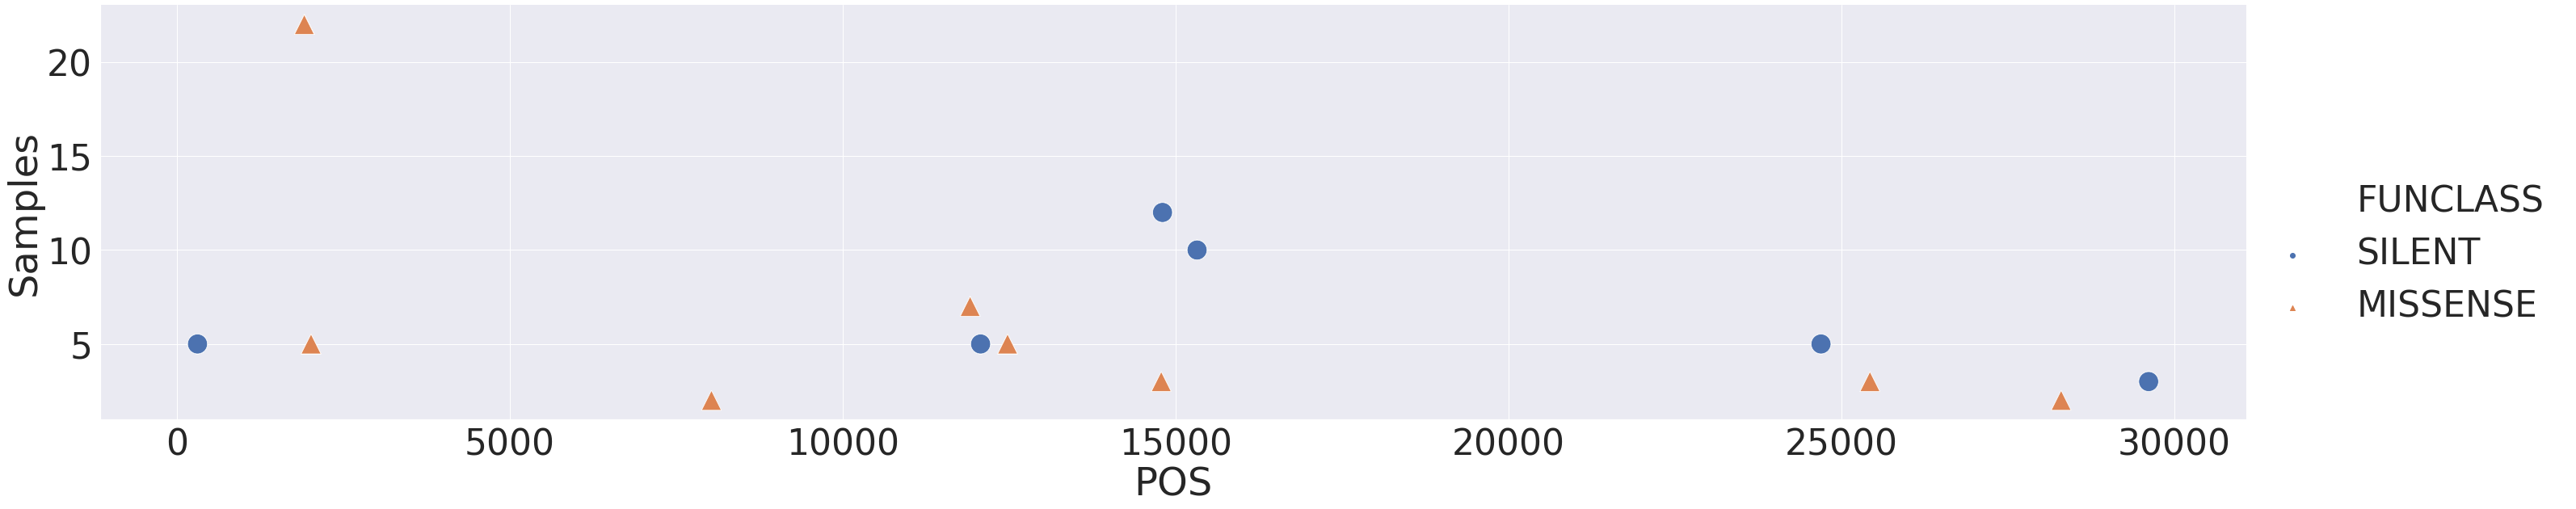

In [126]:
sns.set(font_scale=4)
sns.relplot(x='POS',y='Samples',data=pysqldf('select * from va where minAF >= 0.95'),height=10,aspect=4,s=600,style='FUNCLASS',hue='FUNCLASS',markers=markers)

In [127]:
pysqldf('select POS, change, FUNCLASS, GENE, CODON, func, library_strategy, Samples, Studies, Strategies, minAF, maxAF from va where minAF >= 0.95 group by POS, change')

POS change  FUNCLASS    GENE    CODON    func library_strategy  Samples  \
0     313     CT    SILENT  orf1ab  ctC/ctT  leader         AMPLICON        5   
1    1917     CT  MISSENSE  orf1ab  aCt/aTt    nsp2         AMPLICON       22   
2    2018     AG  MISSENSE  orf1ab  Atg/Gtg    nsp2         AMPLICON        5   
3    8031     AG  MISSENSE  orf1ab  aAa/aGa    nsp3          RNA-Seq        2   
4   11916     CT  MISSENSE  orf1ab  tCa/tTa    nsp7          RNA-Seq        7   
5   12073     CT    SILENT  orf1ab  gaC/gaT    nsp7         AMPLICON        5   
6   12478     GA  MISSENSE  orf1ab  atG/atA    nsp8          RNA-Seq        5   
7   14786     CT  MISSENSE  orf1ab  gCt/gTt    RdRp         AMPLICON        3   
8   14805     CT    SILENT  orf1ab  taC/taT    RdRp         AMPLICON       12   
9   15324     CT    SILENT  orf1ab  aaC/aaT    RdRp         AMPLICON       10   
10  24694     AT    SILENT       S  ggA/ggT       S         AMPLICON        5   
11  25429     GT  MISSENSE   ORF3a  Gta/Tta   orf3a         AMPLICON        3   
12  28300     GT  MISSENSE       N  caG/caT       N          RNA-Seq        2   
13  29614     CT    SILENT   ORF10  tgC/tgT   orf10         AMPLICON        3   

    Studies  Strategies     minAF     maxAF  
0         2           2  0.965812  0.992188  
1         2           2  0.978723  1.000000  
2         2           2  0.965238  0.992806  
3         2           2  0.975375  0.975410  
4         2           2  0.978417  1.000000  
5         2           1  0.953795  1.000000  
6         2           2  0.950000  0.985075  
7         3           2  0.960784  0.991935  
8         4           2  0.966859  1.000000  
9         2           1  0.990826  1.000000  
10        2           1  0.971888  0.993084  
11        2           1  0.983417  1.000000  
12        2           2  0.972603  1.000000  
13        2           1  0.967073  1.000000

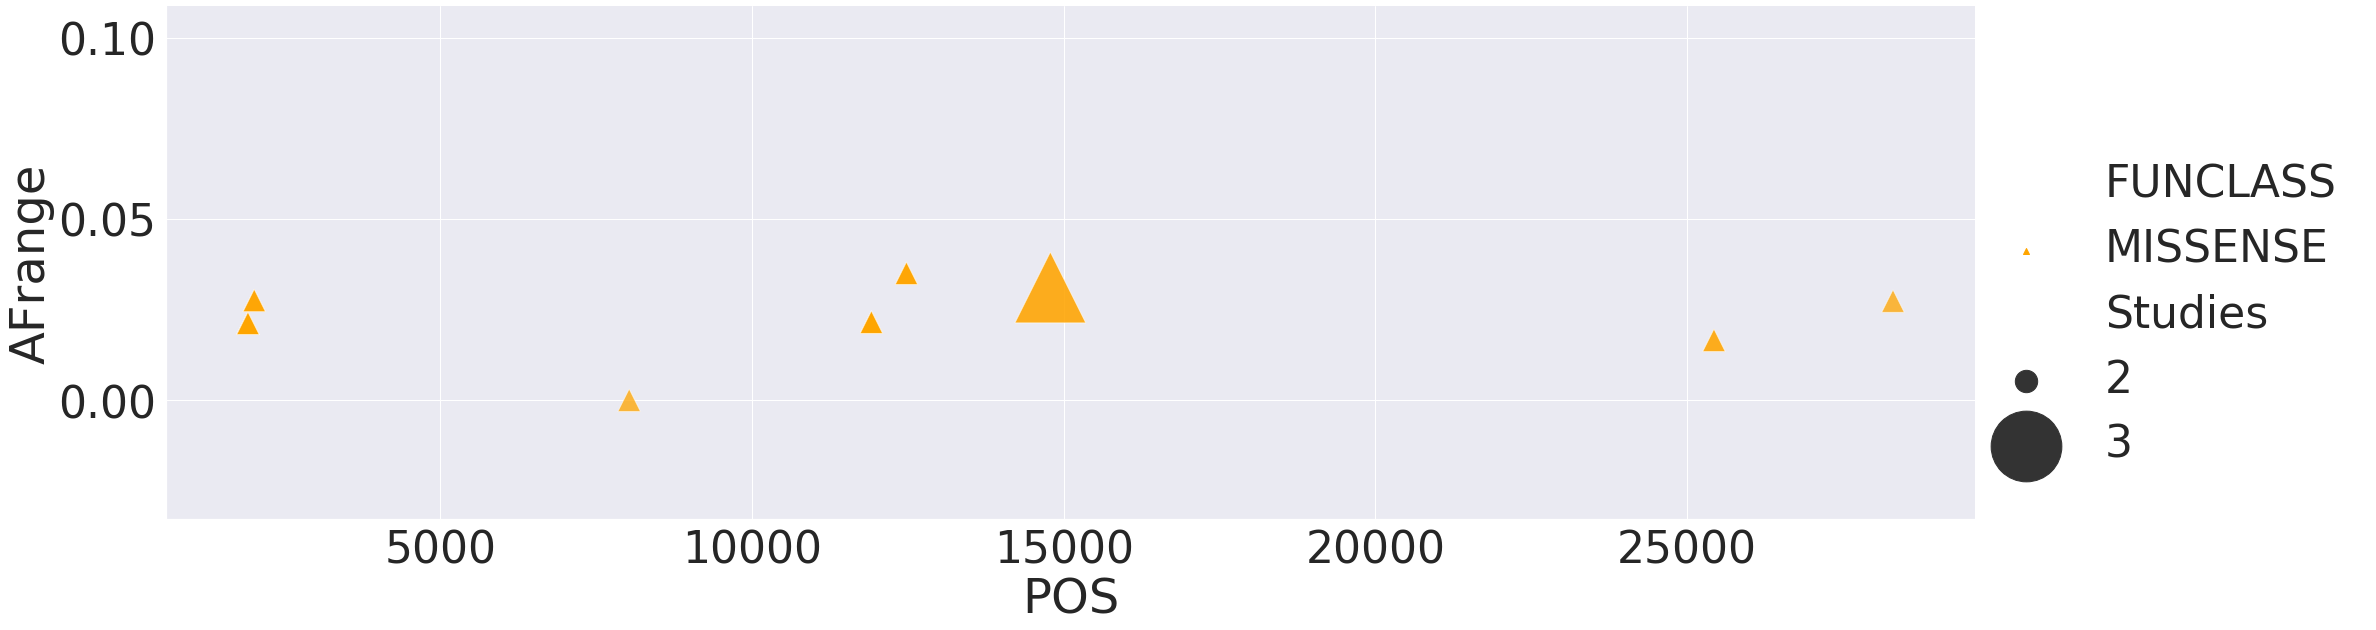

In [128]:
sns.relplot(x='POS',y='AFrange',data=pysqldf('select *, maxAF-minAF as AFrange from va where minAF >= 0.95 and FUNCLASS != "SILENT"'),height=10,aspect=3,size="Studies",sizes=(500,5000),style='FUNCLASS',alpha=0.5,hue='FUNCLASS',palette=fc_palette,markers=markers)

<Figure size 2160x720 with 0 Axes>

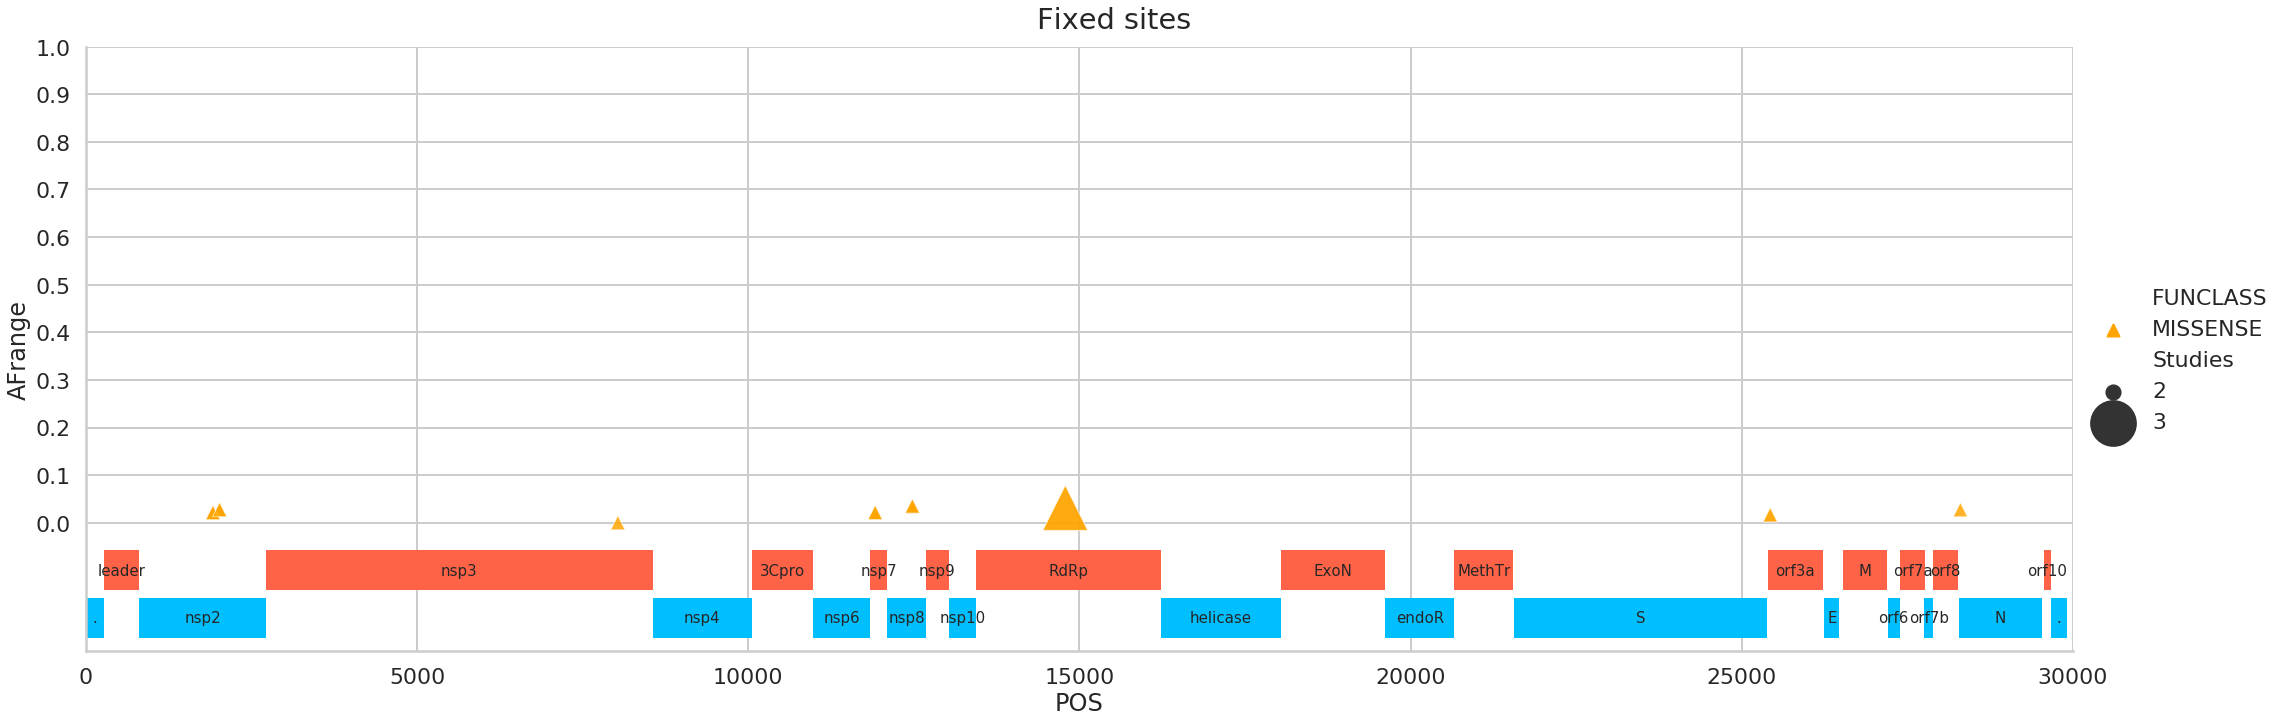

In [129]:
minimap(pysqldf('select *, maxAF-minAF as AFrange from va where minAF >= 0.95 and FUNCLASS != "SILENT"'),'POS','AFrange',annot[annot['L']>100],'Studies','FUNCLASS','FUNCLASS','Fixed sites')

In [130]:
print(pysqldf('select POS, change, FUNCLASS, func, Samples, Studies, Strategies, maxAF-minAF as AFrange from va where minAF >= 0.95 and FUNCLASS != "SILENT" group by POS, change order by POS').to_markdown())

|    |   POS | change   | FUNCLASS   | func   |   Samples |   Studies |   Strategies |   AFrange |
|---:|------:|:---------|:-----------|:-------|----------:|----------:|-------------:|----------:|
|  0 |  1917 | CT       | MISSENSE   | nsp2   |        22 |         2 |            2 |  0.021277 |
|  1 |  2018 | AG       | MISSENSE   | nsp2   |         5 |         2 |            2 |  0.027568 |
|  2 |  8031 | AG       | MISSENSE   | nsp3   |         2 |         2 |            2 |  3.5e-05  |
|  3 | 11916 | CT       | MISSENSE   | nsp7   |         7 |         2 |            2 |  0.021583 |
|  4 | 12478 | GA       | MISSENSE   | nsp8   |         5 |         2 |            2 |  0.035075 |
|  5 | 14786 | CT       | MISSENSE   | RdRp   |         3 |         3 |            2 |  0.031151 |
|  6 | 25429 | GT       | MISSENSE   | orf3a  |         3 |         2 |            1 |  0.016583 |
|  7 | 28300 | GT       | MISSENSE   | N      |         2 |         2 |            2 |  0.027397 |


In [131]:
pysqldf('select distinct library_strategy from va').to_numpy()

array([['RNA-Seq'],
       ['AMPLICON'],
       ['Targeted-Capture'],
       ['WGS'],
       ['OTHER']], dtype=object)

<Figure size 2160x720 with 0 Axes>

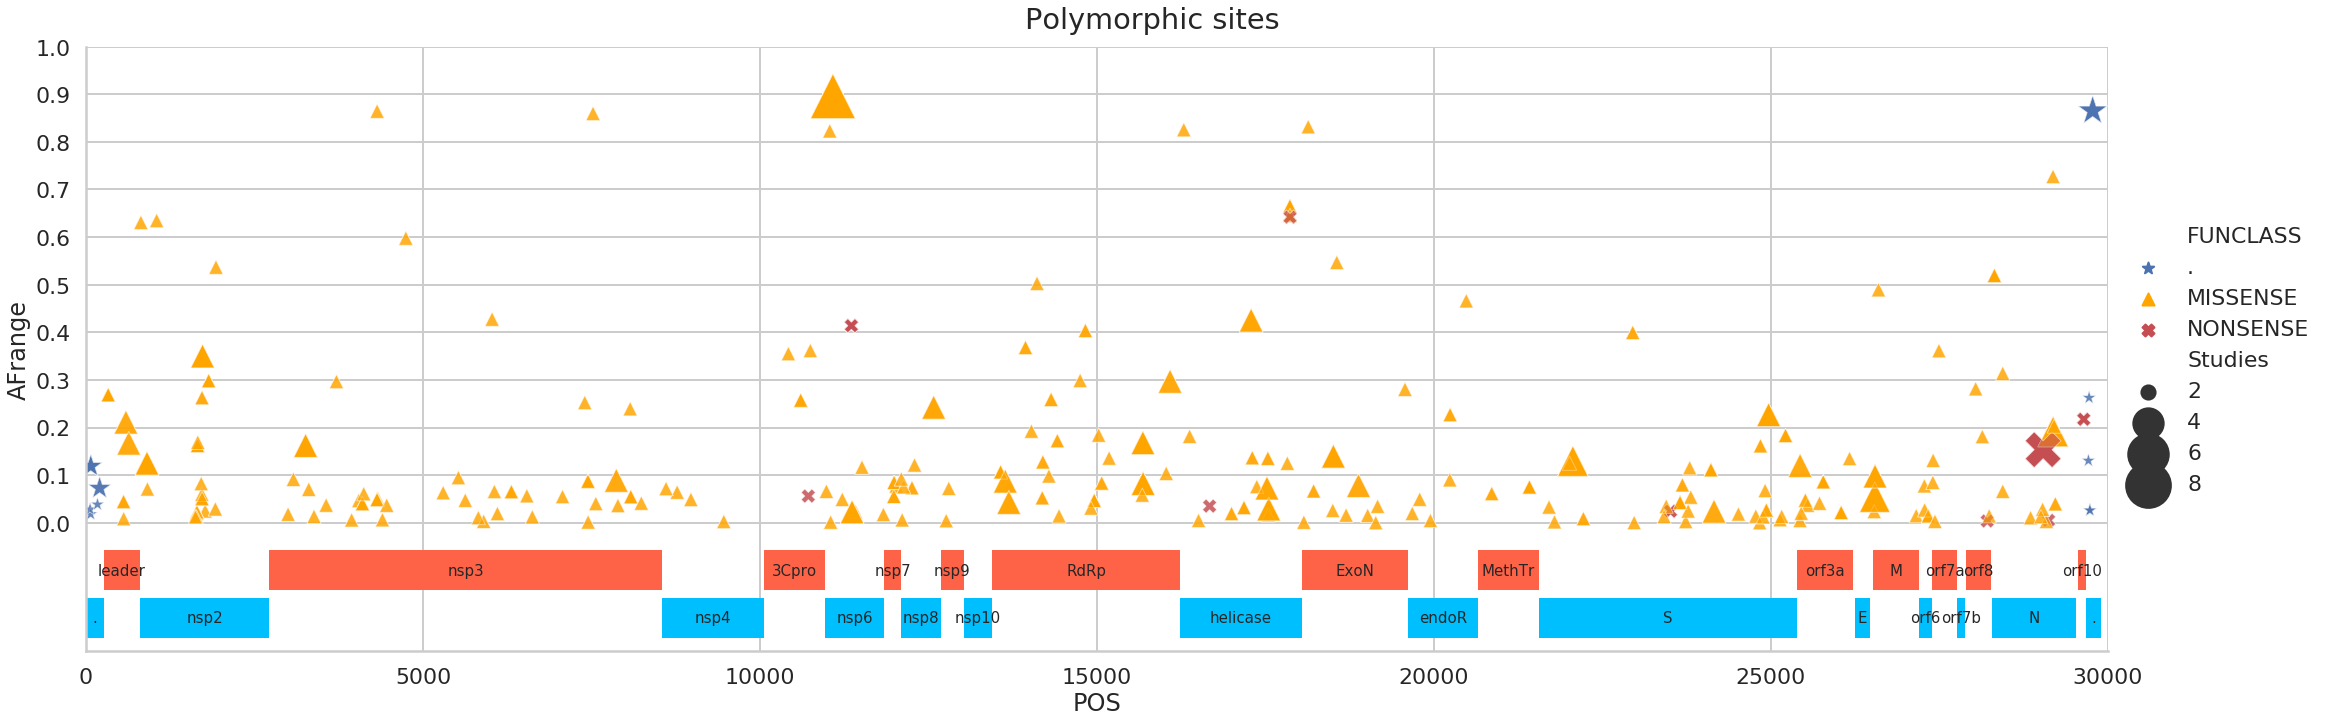

In [132]:
minimap(pysqldf('select *, maxAF-minAF as AFrange from va where maxAF < 0.95 and FUNCLASS != "SILENT"'),'POS','AFrange',annot[annot['L']>100],'Studies','FUNCLASS','FUNCLASS', 'Polymorphic sites')

In [133]:
print(pysqldf('select POS, change, FUNCLASS, func, Samples, Studies, Strategies, maxAF-minAF as AFrange from va where maxAF < 0.95 and FUNCLASS != "SILENT" and Studies > 2 group by POS, change order by POS').to_markdown())

|    |   POS | change   | FUNCLASS   | func     |   Samples |   Studies |   Strategies |   AFrange |
|---:|------:|:---------|:-----------|:---------|----------:|----------:|-------------:|----------:|
|  0 |    72 | GA       | .          | .        |         5 |         3 |            1 |  0.11878  |
|  1 |   203 | CT       | .          | .        |         3 |         3 |            2 |  0.072665 |
|  2 |   593 | CT       | MISSENSE   | leader   |         3 |         3 |            2 |  0.211161 |
|  3 |   635 | CT       | MISSENSE   | leader   |         3 |         3 |            2 |  0.166995 |
|  4 |   906 | CT       | MISSENSE   | nsp2     |         7 |         3 |            2 |  0.125    |
|  5 |  1730 | GA       | MISSENSE   | nsp2     |        23 |         3 |            2 |  0.35     |
|  6 |  3259 | GT       | MISSENSE   | nsp3     |         5 |         3 |            1 |  0.162266 |
|  7 |  7869 | CT       | MISSENSE   | nsp3     |         3 |         3 |            2 |  0

In [134]:
pysqldf('select * from va where POS = 29039')

Sample    POS REF ALT    QUAL    DP        AF   SB               DP4  \
0   SRR11597150  29039   A   T    70.0    52  0.057692    2         31,18,3,0   
1   SRR11597171  29039   A   T   146.0    62  0.096774    2         43,12,6,0   
2   SRR11597195  29039   A   T    69.0    53  0.056604    5         32,16,1,2   
3   SRR11783573  29039   A   T  3037.0  2015  0.074442  146   834,1003,28,148   
4   SRR11783615  29039   A   T  5622.0  1095  0.204566  291    530,317,53,189   
5   SRR11783623  29039   A   T  5021.0  5373  0.051182  223  2603,2420,272,75   
6   SRR11771993  29039   A   T   123.0   105  0.066667    0         50,48,4,3   
7   SRR11772009  29039   A   T   147.0   140  0.064286    0         64,67,4,5   
8   SRR11772020  29039   A   T   239.0   122  0.106557    4         52,56,8,5   
9   SRR11772031  29039   A   T   192.0   136  0.080882    9         59,66,8,3   
10  SRR11772045  29039   A   T   116.0   145  0.055172   14         65,72,7,1   
11  SRR11772046  29039   A   T   202.0   136  0.080882    1         64,61,5,6   
12  SRR11772048  29039   A   T   141.0   122  0.065574    0         53,61,4,4   
13  SRR11772051  29039   A   T   191.0   121  0.082645    0         53,58,5,5   
14  SRR11772053  29039   A   T   164.0   140  0.071429    7         61,69,7,3   
15  SRR11772055  29039   A   T   263.0   143  0.097902   16        58,71,11,3   
16  SRR11772057  29039   A   T   279.0   125  0.112000   12        47,63,10,4   
17  SRR11772058  29039   A   T   168.0   147  0.068027    6         66,71,7,3   
18  SRR11772059  29039   A   T   179.0   130  0.076923    4         58,62,7,3   
19  SRR11772061  29039   A   T   164.0   128  0.070312    1         56,62,5,4   
20  SRR11772063  29039   A   T   140.0   136  0.058824    1         64,64,5,3   
21  SRR11772064  29039   A   T   150.0   116  0.068966    1         54,54,5,3   
22  SRR11772065  29039   A   T   115.0   117  0.059829   12         49,61,6,1   
23  SRR11780016  29039   A   T   120.0   134  0.059701    1         61,65,3,5   
24  SRR11780045  29039   A   T   160.0   135  0.066667   10         60,66,7,2   
25  SRR11780080  29039   A   T   124.0   136  0.051471    1         63,66,4,3   
26  SRR11607615  29039   A   T   553.0   355  0.073239    1      219,110,19,7   
27   ERR4085376  29039   A   T    69.0    58  0.051724    0         38,17,2,1   
28  SRR11491766  29039   A   T   146.0   118  0.059322    0         41,70,3,4   

   IMPACT  FUNCLASS       EFFECT GENE    CODON change study_accession  \
0    HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP258105   
1    HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP258105   
2    HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP258105   
3    HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP261417   
4    HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP261417   
5    HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP261417   
6    HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP251618   
7    HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP251618   
8    HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP251618   
9    HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP251618   
10   HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP251618   
11   HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP251618   
12   HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP251618   
13   HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP251618   
14   HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP251618   
15   HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP251618   
16   HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP251618   
17   HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP251618   
18   HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP251618   
19   HIGH  NONSENSE  STOP_GAINED    N  Aag/Tag     AT       SRP251618   
20   HIGH  NONSENSE  STOP_GAINED    N  Aag/Ta

<Figure size 2160x720 with 0 Axes>

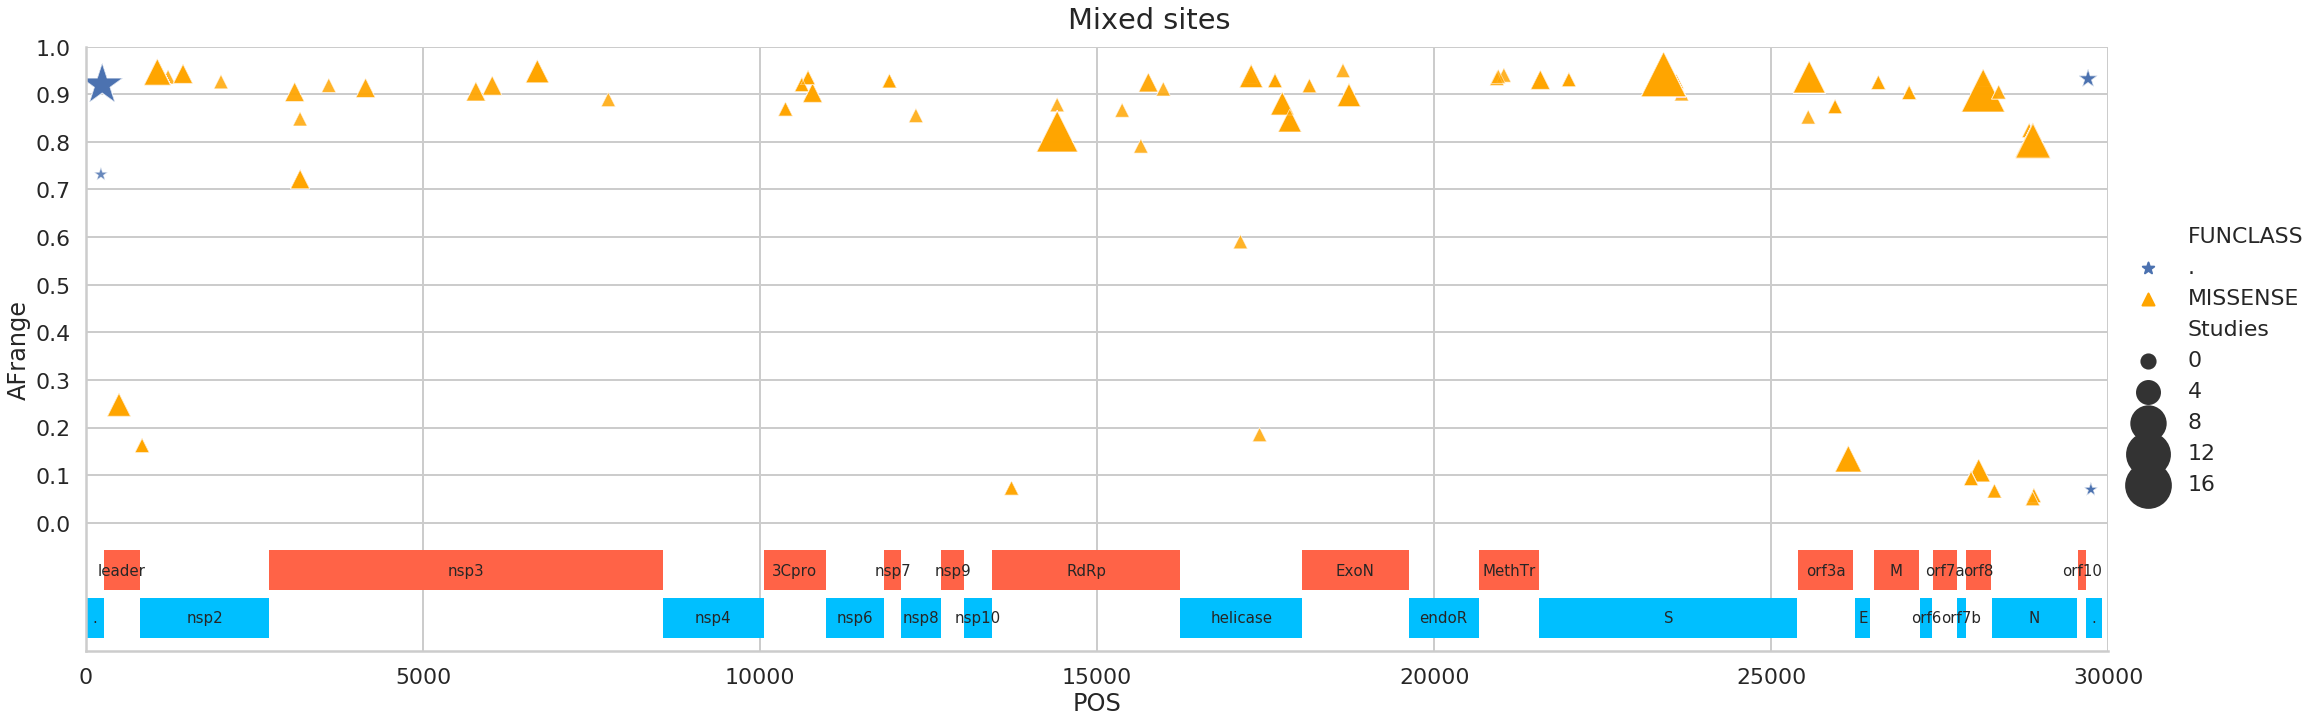

In [135]:
minimap(pysqldf('select *, maxAF-minAF as AFrange from va where maxAF >= 0.95 and minAF < 0.95 and FUNCLASS != "SILENT"'),'POS','AFrange',annot[annot['L']>100],'Studies','FUNCLASS','FUNCLASS', 'Mixed sites')

In [136]:
print(pysqldf('select POS, change, FUNCLASS, GENE, func, Samples, Studies, Strategies, maxAF-minAF as AFrange from va where maxAF >= 0.95 and minAF < 0.95 and FUNCLASS != "SILENT" and Studies > 2 group by POS, change order by POS').to_markdown())

|    |   POS | change   | FUNCLASS   | GENE   | func     |   Samples |   Studies |   Strategies |   AFrange |
|---:|------:|:---------|:-----------|:-------|:---------|----------:|----------:|-------------:|----------:|
|  0 |   241 | CT       | .          | .      | .        |       413 |        12 |            5 |  0.92     |
|  1 |   490 | TA       | MISSENSE   | orf1ab | leader   |        11 |         4 |            2 |  0.247869 |
|  2 |  1059 | CT       | MISSENSE   | orf1ab | nsp2     |       265 |         5 |            3 |  0.946809 |
|  3 |  1440 | GA       | MISSENSE   | orf1ab | nsp2     |         5 |         3 |            2 |  0.943015 |
|  4 |  3096 | CT       | MISSENSE   | orf1ab | nsp3     |         3 |         3 |            2 |  0.904995 |
|  5 |  3177 | CT       | MISSENSE   | orf1ab | nsp3     |         8 |         3 |            2 |  0.721506 |
|  6 |  4148 | GT       | MISSENSE   | orf1ab | nsp3     |         3 |         3 |            2 |  0.913439 |
|  7 |  57

In [137]:
pysqldf('select distinct study_accession from va where maxAF >= 0.95 and minAF < 0.95 and FUNCLASS != "SILENT" and Studies > 2 ')['study_accession'].to_list()

['SRP255853',
 'SRP253926',
 'SRP256957',
 'SRP261417',
 'SRP251618',
 'SRP261139',
 'ERP121228',
 'SRP252988',
 'SRP255672',
 'SRP257865',
 'SRP258006',
 'SRP261949',
 'SRP258105',
 'SRP248092',
 'SRP242226',
 'SRP254688',
 'SRP259532',
 'SRP253783',
 'SRP258386',
 'SRP040661',
 'SRP255151']

In [138]:
pysqldf('select distinct study_accession from va where maxAF >= 0.95 and minAF < 0.95 and FUNCLASS != "SILENT" and Studies > 2 ')

study_accession
0        SRP255853
1        SRP253926
2        SRP256957
3        SRP261417
4        SRP251618
5        SRP261139
6        ERP121228
7        SRP252988
8        SRP255672
9        SRP257865
10       SRP258006
11       SRP261949
12       SRP258105
13       SRP248092
14       SRP242226
15       SRP254688
16       SRP259532
17       SRP253783
18       SRP258386
19       SRP040661
20       SRP255151

In [139]:
pysqldf('select distinct geo_loc_name from va')

geo_loc_name
0                  Germany
1                     None
2             USA:Virginia
3        USA: Hamilton, MT
4                      USA
5            USA:Minnesota
6          USA: Washington
7               Peru: Lima
8            USA: New York
9      Germany: Dusseldorf
10              Bangladesh
11          China:Shanghai
12                Malaysia
13           India: Rajkot
14      Germany: Heinsberg
15         USA:Los Angeles
16                 USA: WA
17            China: Hubei
18  Malaysia: Kuala Lumpur
19                  Israel
20                   Egypt
21        USA: Seattle, WA
22            China: Wuhan
23        Nepal: Kathmandu
24  Cambodia:Sihanoukville

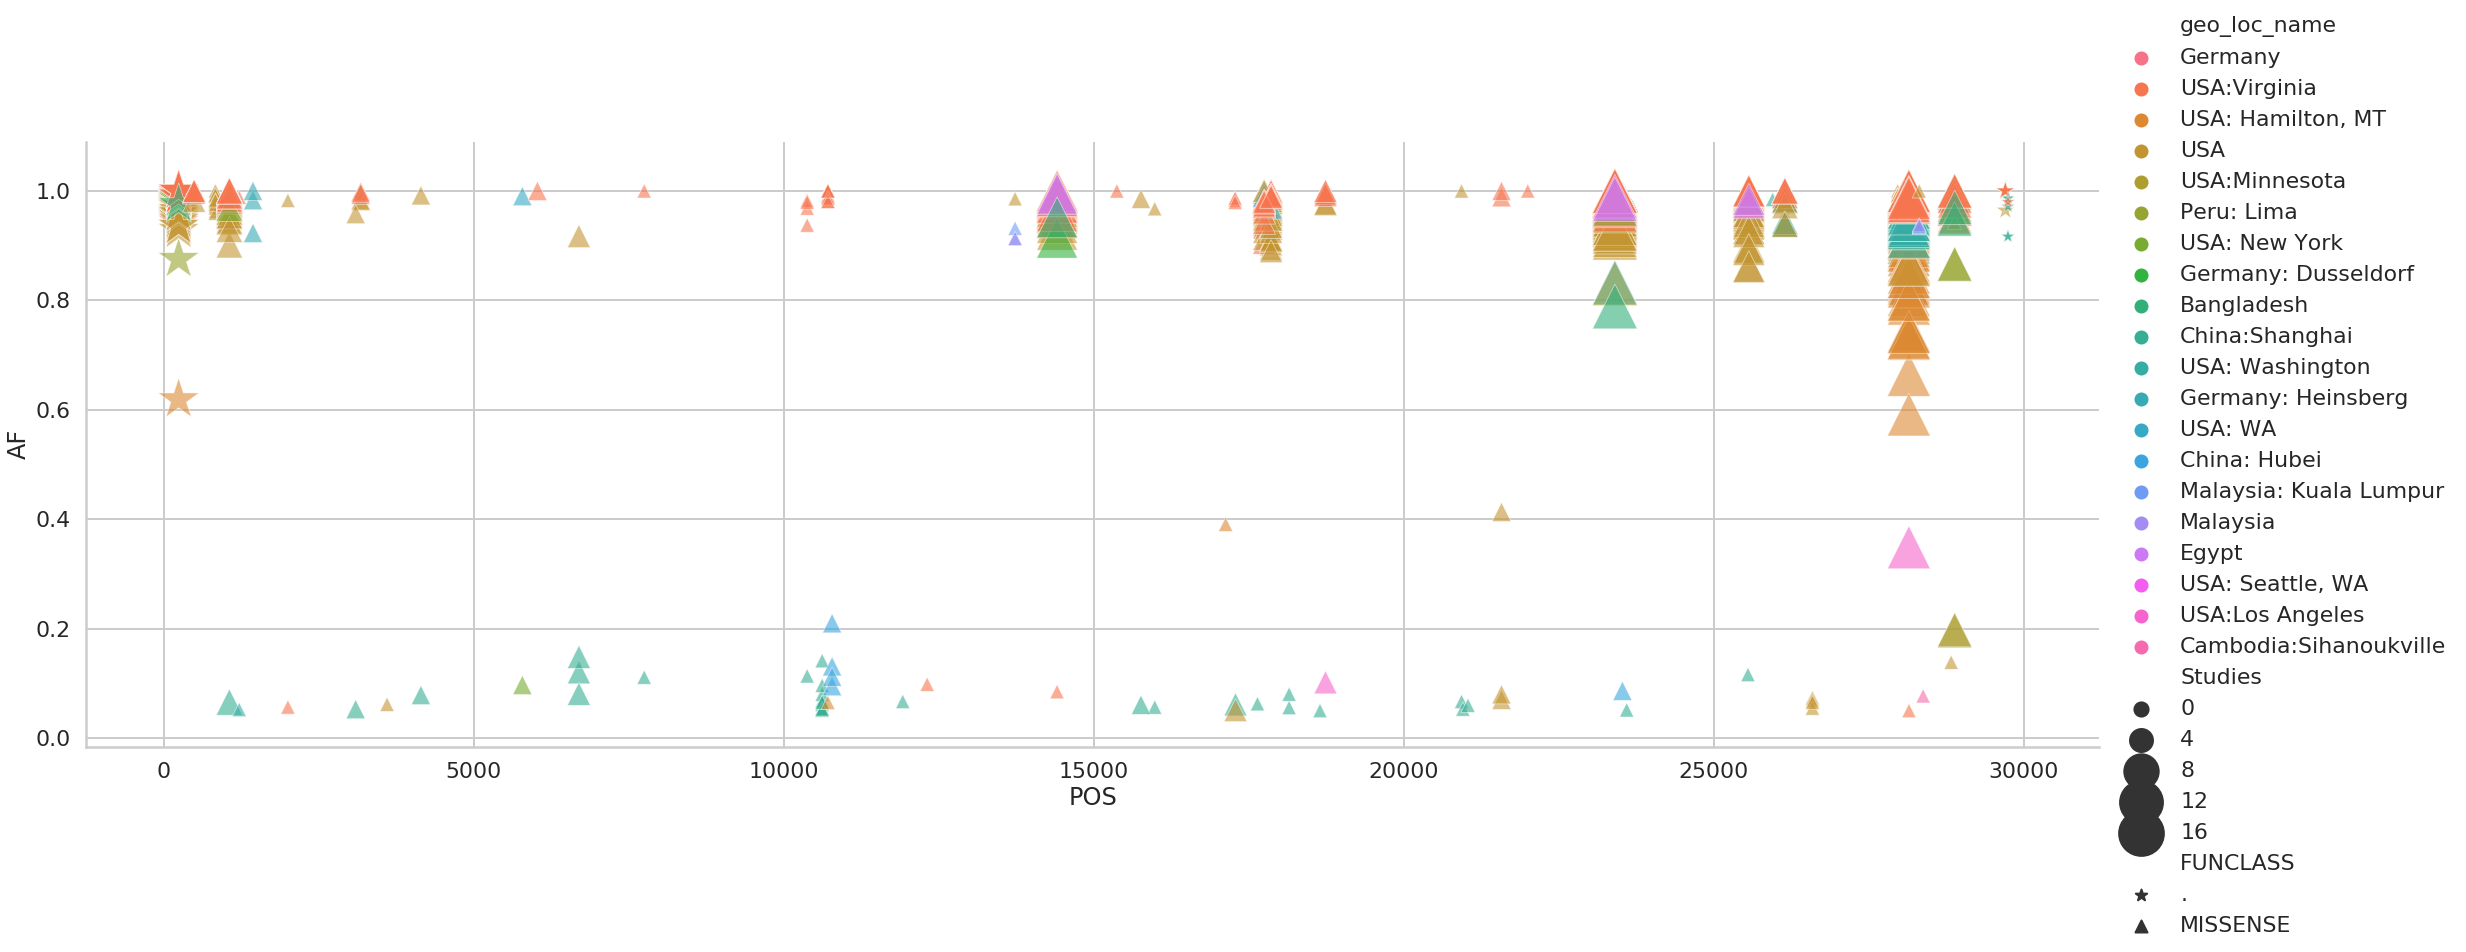

In [140]:
markers = {".":"*", "MISSENSE":"^", "NONSENSE":"X", "SILENT":"o", "NONE":"."}
sns.relplot(x='POS',y='AF',data=pysqldf('select *, maxAF-minAF as AFrange from va where maxAF >= 0.95 and minAF < 0.95 and Studies > 1 and FUNCLASS != "SILENT"'),legend='brief',alpha=0.6,sizes=(200,2000),markers=markers,height=10,aspect=3,size='Studies',hue='geo_loc_name',style="FUNCLASS")

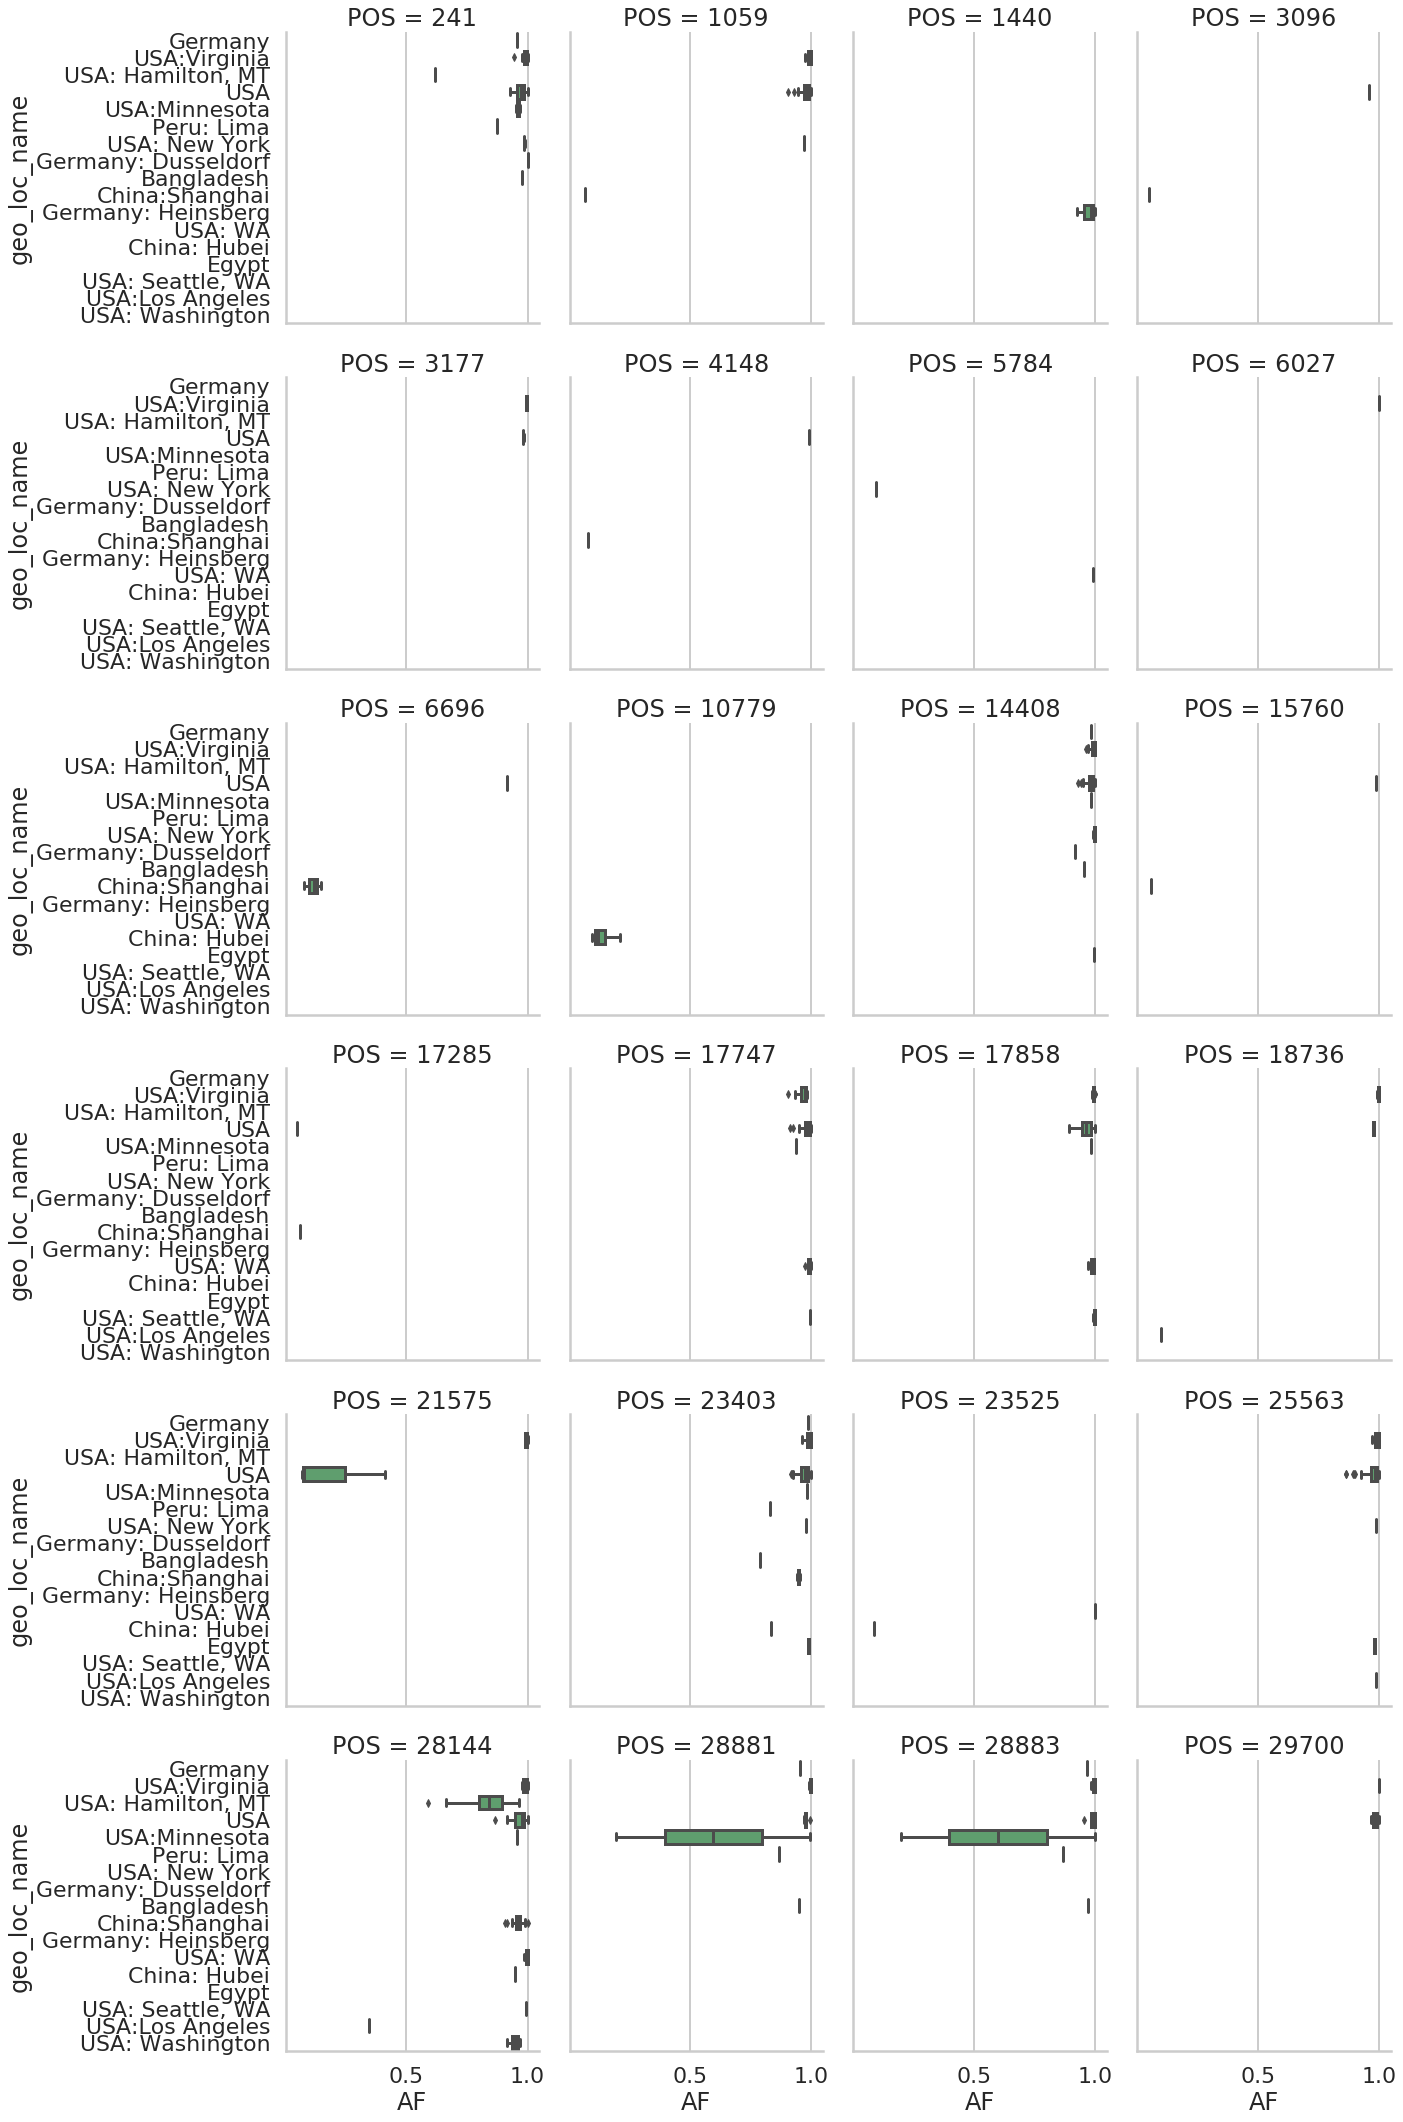

In [141]:
a = pysqldf('select POS, change, rangeAF, Studies from va where Studies > 2 and minAF < .95 and maxAF > 0.95 and rangeAF > .5 and FUNCLASS != "SILENT" group by POS, change order by Studies desc')[['POS','change']]
sns.catplot(x = 'AF', y='geo_loc_name', data = pysqldf('select va.* from va join a on va.POS = a.POS and va.change = a.change'),height=5,col="POS",kind='box',color='g',col_wrap=4)

## Comparison with sites under selection

In [142]:
sel = pd.read_csv('https://raw.githubusercontent.com/veg/SARS-CoV-2/segmented/data/comparative-annotation.tsv',sep='\t')

In [143]:
sel

genomic_coordinate   gene  codon_in_gene consensus consensus_aa  \
0                    266  ORF1a              1       ATG            M   
1                    269  ORF1a              2       GAG            E   
2                    272  ORF1a              3       AGC            S   
3                    275  ORF1a              4       CTT            L   
4                    278  ORF1a              5       GTC            V   
...                  ...    ...            ...       ...          ...   
9658               29516      N            415       GAC            D   
9659               29519      N            416       TCA            S   
9660               29522      N            417       ACT            T   
9661               29525      N            418       CAG            Q   
9662               29528      N            419       GCC            A   

      genomes  syn_sites  nonsyn_sites  \
0       32346   0.004294       2.99507   
1       32346   0.687112       2.00756   
2       32346   0.938948       2.06062   
3       32346   0.999615       2.00038   
4       32346   0.999986       2.00001   
...       ...        ...           ...   
9658    32580   0.830707       2.16929   
9659    32580   1.000100       1.83086   
9660    32580   0.999590       2.00041   
9661    32580   0.422513       1.74722   
9662    32580   1.000000       2.00000   

                                           variants          aa_variants  \
0                                   ATG:32345|TTG:1          M:32345|L:1   
1                       GAG:32339|GAT:5|AAG:1|GGG:1  E:32339|D:5|K:1|G:1   
2                            AGC:32332|AGT:12|AGA:2          S:32344|R:2   
3                                   CTT:32343|ATT:3          L:32343|I:3   
4                             GTC:32341|GTT:4|ATC:1          V:32345|I:1   
...                                             ...                  ...   
9658                    GAC:32572|GAT:5|GAN:2|NNN:1              D:32577   
9659              TCA:32574|TCN:2|TCT:2|TTA:1|NNN:1          S:32578|L:1   
9660                    ACT:32573|ATT:5|NNN:1|NCT:1          T:32573|I:5   
9661              CAG:32569|CAA:5|CAT:3|NAG:2|NNN:1          Q:32574|H:3   
9662  GCC:32570|ACC:3|GCT:2|TCC:2|GCA:1|NNN:1|GNC:1      A:32573|T:3|S:2   

      total_maf  selection  epidosic_selection  multiple_clades  trend  \
0      0.000031          0                   0                0    NaN   
1      0.000216          0                   0                0    NaN   
2      0.000433          0                   0                0    1.0   
3      0.000093          0                   0                0    1.0   
4      0.000155          0                   0                0    1.0   
...         ...        ...                 ...              ...    ...   
9658   0.000246          0                   0                0    NaN   
9659   0.000184          0                   0                0    NaN   
9660   0.000215          1                   0                0    NaN   
9661   0.000338          0                   0                0    NaN   
9662   0.000307          0                   0                0    NaN   

      epitopes                                related_selection  \
0          0.0                                              NaN   
1          0.0                                              NaN   
2          0.0                                              NaN   
3          0.0                                              NaN   
4          0.0  GTC:GTT:GCT:CAC:CCC:CTC:GCA:GCC:GCG:GGC:GTA:GTG   
...        ...                                              ...   
9658      -1.0                                          GAT:GAC   
9659       0.0                                  TCA:TCT:TCC:TCG   
9660       0.0                                  ACT:ACC:ACA:ACG   
9661       0.0                                              NaN   
9662       0.0                                  GCT:GCC:GCA:GCG   

     predicted_va

In [144]:
sel['score'].fillna(0,inplace=True)

In [145]:
pysqldf('select count(*) from sel where score>0')

count(*)
0       108

In [146]:
pysqldf('select count(*) from sel where score>4')

count(*)
0        17

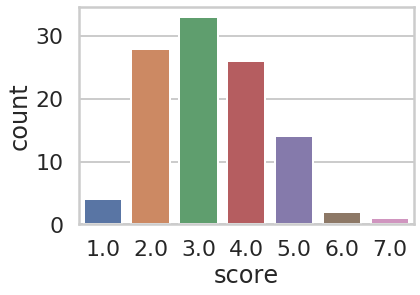

In [147]:
sns.countplot(x='score',data=sel[sel['score']>0])
#plt.yscale('log')

In [148]:
va = pysqldf('select va.*,consensus, score, aa_variants,multiple_clades, related_selection from va left join sel on POS >= genomic_coordinate and POS <= genomic_coordinate+2')

In [149]:
va['score'].fillna(0,inplace=True)

In [150]:
pysqldf('select count(distinct POS) from va')

count(distinct POS)
0                  456

In [151]:
pysqldf('select count(distinct POS) from va where FUNCLASS = "MISSENSE"')

count(distinct POS)
0                  286

In [152]:
pysqldf('select count(distinct POS) from va where score > 0 and FUNCLASS = "MISSENSE"')

count(distinct POS)
0                   27

In [153]:
pysqldf('select count(distinct POS) from va where score > 4 and FUNCLASS = "MISSENSE"')

count(distinct POS)
0                    7

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

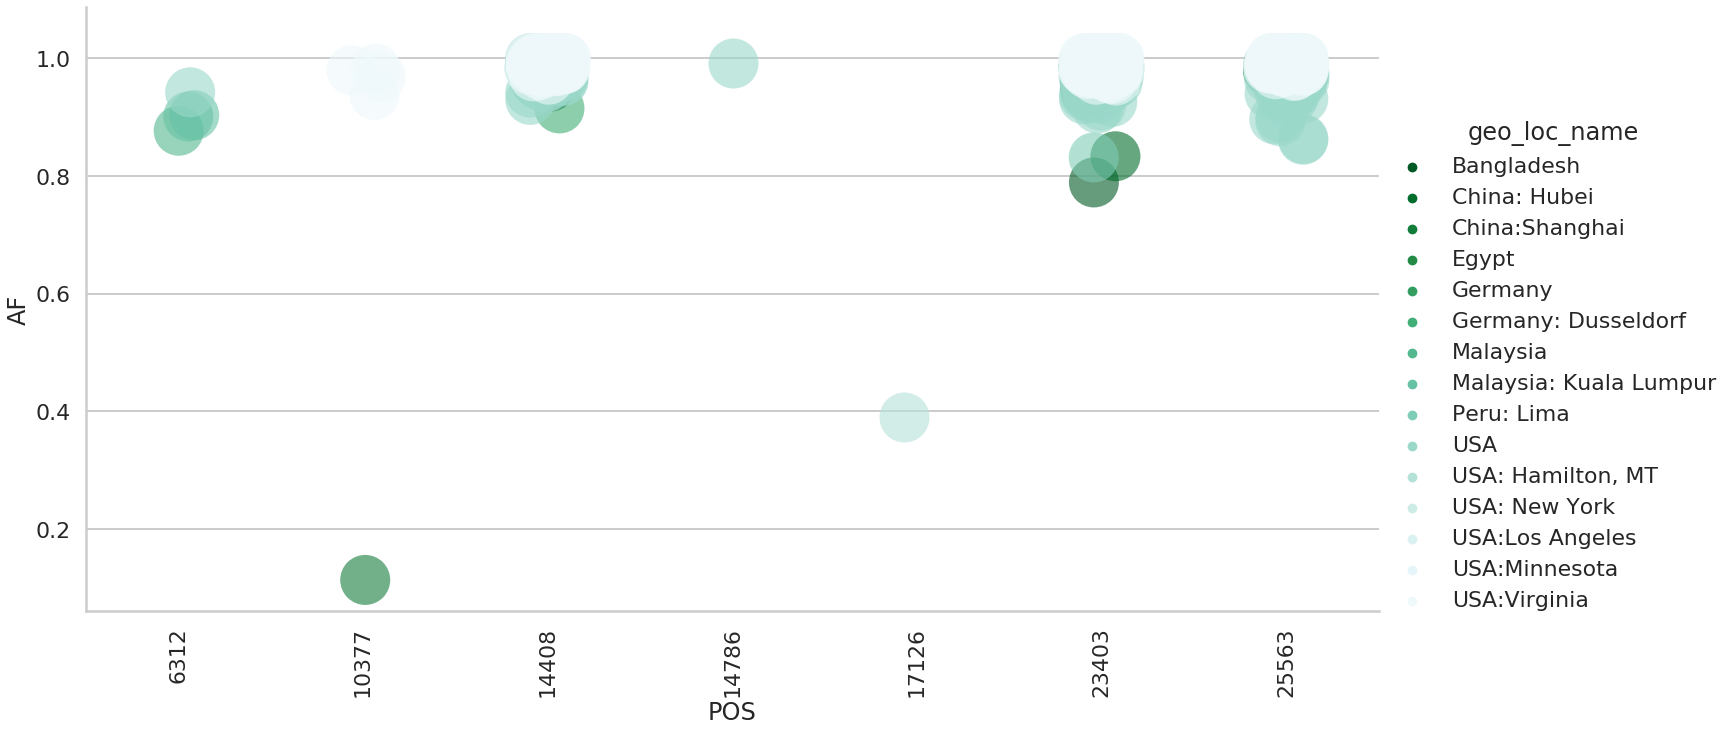

In [154]:
sns.catplot(x='POS', y = 'AF', data = pysqldf('select * from va where score > 4 and FUNCLASS = "MISSENSE" order by geo_loc_name'),height=10, aspect=2,hue='geo_loc_name',s=50,alpha=.6,palette="BuGn_r")
plt.xticks(rotation=90)

In [155]:
va.head()

Sample  POS REF ALT     QUAL    DP        AF  SB          DP4 IMPACT  \
0  SRR11517432  241   C   T   9603.0   291  0.958763   0  0,0,147,140      .   
1  SRR11676316  241   C   T  28423.0   834  0.962830   0  0,0,362,472      .   
2  SRR11728606  241   C   T  34744.0   985  0.984772   0  0,0,430,554      .   
3  SRR11728607  241   C   T  49314.0  1765  0.981303   0  1,1,803,959      .   
4  SRR11728608  241   C   T  49314.0  1644  0.989051   0  0,1,721,921      .   

  FUNCLASS EFFECT GENE CODON change study_accession library_strategy  \
0        .      .    .     .     CT       SRP255853          RNA-Seq   
1        .      .    .     .     CT       SRP253926         AMPLICON   
2        .      .    .     .     CT       SRP253926         AMPLICON   
3        .      .    .     .     CT       SRP253926         AMPLICON   
4        .      .    .     .     CT       SRP253926         AMPLICON   

       library_source library_selection collection_date geo_loc_name   type  \
0  METATRANSCRIPTOMIC            RANDOM     19-MAR-2020      Germany  5'UTR   
1           VIRAL RNA               PCR            None         None  5'UTR   
2           VIRAL RNA               PCR            None         None  5'UTR   
3           VIRAL RNA               PCR            None         None  5'UTR   
4           VIRAL RNA               PCR            None         None  5'UTR   

  func  start  end   A   C   G   T  Samples  Studies  Strategies   up down  \
0    .      0  265  67  63  55  80      413       12           5  TTC  CGT   
1    .      0  265  67  63  55  80      413       12           5  TTC  CGT   
2    .      0  265  67  63  55  80      413       12           5  TTC  CGT   
3    .      0  265  67  63  55  80      413       12           5  TTC  CGT   
4    .      0  265  67  63  55  80      413       12           5  TTC  CGT   

   mid left right  minAF  maxAF  rangeAF consensus  score aa_variants  \
0  TCG    T     G   0.08    1.0     0.92      None    0.0        None   
1  TCG    T     G   0.08    1.0     0.92      None    0.0        None   
2  TCG    T     G   0.08    1.0     0.92      None    0.0        None   
3  TCG    T     G   0.08    1.0     0.92      None    0.0        None   
4  TCG    T     G   0.08    1.0     0.92      None    0.0        None   

   multiple_clades related_selection  
0              NaN              None  
1              NaN              None  
2              NaN              None  
3              NaN              None  
4              NaN              None

In [156]:
pysqldf('select * from sel where genomic_coordinate > 25560 and genomic_coordinate < 25565')

genomic_coordinate   gene  codon_in_gene consensus consensus_aa  genomes  \
0               25561  ORF3a             57       CAG            Q    32717   
1               25564  ORF3a             58       AGC            S    32717   

   syn_sites  nonsyn_sites                               variants  \
0   0.297041       2.07184  CAG:25317|CAT:7368|CAK:29|CAC:2|CAN:1   
1   0.809408       2.19059            AGC:32712|AGY:2|AGT:2|ARC:1   

      aa_variants  total_maf  selection  epidosic_selection  multiple_clades  \
0  Q:25317|H:7370   0.226182          1                   1                7   
1         S:32716   0.000153          0                   0                0   

   trend  epitopes                                  related_selection  \
0    1.0       1.0                                                  1   
1    2.0       0.0  AGC:AAT:AAA:AAC:ACC:AGA:AGG:AGT:ATA:ATC:CGC:CG...   

                                  predicted_variants unusual_variants  score  
0  CAG:CAA:CAC:AAA:AGA:AGG:CAT:CCC:CCT:CGA:CGC:CG...             None    6.0  
1                                               None                1    0.0

In [157]:
pysqldf('select * from sel where score > 5 order by genomic_coordinate ')

genomic_coordinate   gene  codon_in_gene consensus consensus_aa  genomes  \
0               14408  ORF1b            314       CTT            L    31185   
1               17126  ORF1b           1220       CTC            L    31341   
2               25561  ORF3a             57       CAG            Q    32717   

   syn_sites  nonsyn_sites                                           variants  \
0   0.999316       2.00068  CTT:22532|CCT:8620|CYT:23|TTT:6|CTC:2|ACT:1|TCT:1   
1   0.999829       2.00017                 CTC:31258|CCC:74|TTC:6|ATC:2|NCC:1   
2   0.297041       2.07184              CAG:25317|CAT:7368|CAK:29|CAC:2|CAN:1   

                  aa_variants  total_maf  selection  epidosic_selection  \
0  L:22534|P:8620|F:6|T:1|S:1   0.723585          1                   1   
1        L:31258|P:74|F:6|I:2   0.002648          1                   1   
2              Q:25317|H:7370   0.226182          1                   1   

   multiple_clades  trend  epitopes related_selection  \
0               15    1.0       1.0                 1   
1                2    1.0       3.0                 1   
2                7    1.0       1.0                 1   

                                  predicted_variants     unusual_variants  \
0                                    CCA:CCT:CCC:CCG  CTT:ACT:TCT:TTT:CTC   
1                            TTG:CTC:CTT:CTA:CTG:TTA          ATC:TTC:CCC   
2  CAG:CAA:CAC:AAA:AGA:AGG:CAT:CCC:CCT:CGA:CGC:CG...                 None   

   score  
0    7.0  
1    6.0  
2    6.0

In [158]:
print(pysqldf('select POS, change, func, Samples, Studies, Strategies, score, multiple_clades, related_selection from va where score > 4 and FUNCLASS = "MISSENSE" group by POS, change').to_markdown())

|    |   POS | change   | func     |   Samples |   Studies |   Strategies |   score |   multiple_clades |   related_selection |
|---:|------:|:---------|:---------|----------:|----------:|-------------:|--------:|------------------:|--------------------:|
|  0 |  6312 | CA       | nsp3     |         4 |         2 |            2 |       5 |                 5 |                   1 |
|  1 | 10377 | CT       | 3Cpro    |         5 |         2 |            1 |       5 |                 2 |                   1 |
|  2 | 14408 | CT       | RdRp     |       537 |        11 |            5 |       7 |                15 |                   1 |
|  3 | 14786 | CT       | RdRp     |         3 |         3 |            2 |       5 |                 4 |                   0 |
|  4 | 17126 | TC       | helicase |         2 |         2 |            2 |       6 |                 2 |                   1 |
|  5 | 23403 | AG       | S        |       482 |        13 |            5 |       5 |                31 

In [161]:
va

Sample    POS REF ALT     QUAL    DP        AF  SB             DP4  \
0     SRR11517432    241   C   T   9603.0   291  0.958763   0     0,0,147,140   
1     SRR11676316    241   C   T  28423.0   834  0.962830   0     0,0,362,472   
2     SRR11728606    241   C   T  34744.0   985  0.984772   0     0,0,430,554   
3     SRR11728607    241   C   T  49314.0  1765  0.981303   0     1,1,803,959   
4     SRR11728608    241   C   T  49314.0  1644  0.989051   0     0,1,721,921   
...           ...    ...  ..  ..      ...   ...       ...  ..             ...   
5125  SRR11728647  13536   C   T  49314.0  2753  0.963676   7  25,31,960,1736   
5126  SRR11728648  13536   C   T  49314.0  2419  0.990905   0    0,1,892,1526   
5127  SRR11621877  13536   C   T   3423.0   105  0.971429   0       0,0,58,47   
5128  SRR11676288  13536   C   T  47807.0  1296  0.983025   0     0,1,371,923   
5129  SRR11676289  13536   C   T  49314.0  1638  0.954212   2  15,31,443,1149   

     IMPACT FUNCLASS             EFFECT    GENE    CODON change  \
0         .        .                  .       .        .     CT   
1         .        .                  .       .        .     CT   
2         .        .                  .       .        .     CT   
3         .        .                  .       .        .     CT   
4         .        .                  .       .        .     CT   
...     ...      ...                ...     ...      ...    ...   
5125    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   
5126    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   
5127    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   
5128    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   
5129    LOW   SILENT  SYNONYMOUS_CODING  orf1ab  taC/taT     CT   

     study_accession library_strategy      library_source library_selection  \
0          SRP255853          RNA-Seq  METATRANSCRIPTOMIC            RANDOM   
1          SRP253926         AMPLICON           VIRAL RNA               PCR   
2          SRP253926         AMPLICON           VIRAL RNA               PCR   
3          SRP253926         AMPLICON           VIRAL RNA               PCR   
4          SRP253926         AMPLICON           VIRAL RNA               PCR   
...              ...              ...                 ...               ...   
5125       SRP253926         AMPLICON           VIRAL RNA               PCR   
5126       SRP253926         AMPLICON           VIRAL RNA               PCR   
5127       SRP251618          RNA-Seq           VIRAL RNA       unspecified   
5128       SRP253926         AMPLICON           VIRAL RNA               PCR   
5129       SRP253926         AMPLICON           VIRAL RNA               PCR   

     collection_date geo_loc_name   type func  start    end   A   C   G   T  \
0        19-MAR-2020      Germany  5'UTR    .      0    265  67  63  55  80   
1               None         None  5'UTR    .      0    265  67  63  55  80   
2               None         None  5'UTR    .      0    265  67  63  55  80   
3               None         None  5'UTR    .      0    265  67  63  55  80   
4               None         None  5'UTR    .      0    265  67  63  55  80   
...              ...          ...    ...  ...    ...    ...  ..  ..  ..  ..   
5125            None         None   stem  S2b  13535  13542   1   2   3   1   
5126            None         None   stem  S2b  13535  13542   1   2   3   1   
5127         missing          USA   stem  S2b  13535  13542   1   2   3   1   
5128            None         None   stem  S2b  13535  13542   1   2   3   1   
5129            None         None   stem  S2b  13535  13542   1   2   3   1   

      Samples  Studies  Strategies   up down  mid left right     minAF  \
0         413       12           5  TTC  CGT  TCG    T     G  0.080000   
1         413       12           5  TTC  CGT  TCG    T     G  0.080000   
2         413       12           5  TTC  CGT  TCG    T     G  0.080000   
3         413       12           5  TTC

In [162]:
va.to_csv('variant_list.05.tsv',sep='\t')